In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Uma camada de convolução: demonstração
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=(1,2))

Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 2))

In [3]:
# Classe para o modelo de convolução:
class ModeloCnn(nn.Module): # hereins from nn.Module
    def __init__(self):
        super().__init__()
        # Camada de entrada
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Primeira Camada Oculta
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Segunda Camada Oculta
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # camada convolução
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Transform linear 1
        self.linear1 = nn.Linear(in_features= 64 * 4 * 4, out_features=512)
        # Transform Linear 2
        self.linear2 = nn.Linear(in_features=512, out_features=10)
        # Dropout
        self.dropout = nn.Dropout(p = 0.3)
    
    def forward(self, x):
        # primeira parte - convolução
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        # segunda parte - Dense Layer
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return( x )

### Preparando os dados

In [4]:
# pipeline de transformações:
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

### ETL and split of Data

In [5]:
# Load trains and test data
train_data = datasets.CIFAR10("CIFAR10", train = True, download = False, transform = transformations )
test_data = datasets.CIFAR10("CIFAR10", train = False, download = False, transform = transformations )

In [6]:
len(train_data), len(test_data)

(50000, 10000)

In [7]:
validation_size = 0.2 
training_size = len(train_data)

In [8]:
# index for training and validation
indices = list(range(training_size))
np.random.shuffle(indices)
index_split = int(np.floor(training_size * validation_size))

In [9]:
# creating subset sampler for training and validation objects
validation_indices, training_indices = indices[:index_split], indices[index_split:]
training_sample, validation_sample = SubsetRandomSampler(training_indices), SubsetRandomSampler(validation_indices)

In [10]:
# Geras as amostras de dados para treino e validação e os devidos batches
train_loader = DataLoader(train_data, batch_size = 16, sampler = training_sample)
valid_loader = DataLoader(train_data, batch_size = 16, sampler = validation_sample)
test_loader = DataLoader(test_data, batch_size=16)

### Otimização do modelo

In [11]:
model = ModeloCnn()
model

ModeloCnn(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [12]:
# identificação do dispositivo:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cpu'

In [13]:
# se o device for gpu, faça:
# model = model.to(device)

In [14]:
# Função de custo:
criterion = nn.CrossEntropyLoss()

In [15]:
# optmizer backward
optmizer = optim.SGD(params= model.parameters(), lr = 0.01)

In [16]:
# Accuracy Function
# o modelo retorna a probabilidade de cada classe (preds)
def accuracy(preds, y):
    _, pred = torch.argmax(preds, 1)
    correct = pred.eq(target.data.view_as(pred))
    acc = correct.sum() / len(correct)
    return acc

### Training

In [17]:
for epochs in range(1, 10):
    # inicializa o erro
    train_loss = 0
    valid_loss = 0
    
    # CALL o método de treino
    model.train()
    # Batch Training
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optmizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optmizer.step()
        train_loss += loss.item() * data.size(0)
        
    # call evaluation method
    model.eval()
    # Batch eval
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    # Calcula o Erro na Epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print(f" Epoch: {epochs}, Train Error: {train_loss}, Validation Error: {valid_loss}")

 Epoch: 1, Train Error: 2.098631987857819, Validation Error: 1.7990942100524903
 Epoch: 2, Train Error: 1.6832998691558838, Validation Error: 1.5503588768005372
 Epoch: 3, Train Error: 1.522220448422432, Validation Error: 1.4324162773132325
 Epoch: 4, Train Error: 1.430957935166359, Validation Error: 1.351475235557556
 Epoch: 5, Train Error: 1.3530837240219116, Validation Error: 1.2618505249023437
 Epoch: 6, Train Error: 1.2983977076530457, Validation Error: 1.2361011005401612
 Epoch: 7, Train Error: 1.2416022868394851, Validation Error: 1.1599028892040253
 Epoch: 8, Train Error: 1.197393273448944, Validation Error: 1.1383673133850098
 Epoch: 9, Train Error: 1.1598195328593255, Validation Error: 1.1023143096923829


### Prediction Test and Image Visualizations

tensor([[-0.0902, -0.0118,  0.0745,  ...,  0.2941,  0.2471,  0.2392],
        [-0.0667, -0.0196,  0.0667,  ...,  0.2471,  0.1843,  0.1922],
        [-0.0588,  0.0196,  0.0902,  ...,  0.2392,  0.1843,  0.1843],
        ...,
        [-0.6863, -0.8980, -0.7020,  ..., -0.7569, -0.6706, -0.4667],
        [-0.8431, -0.7725, -0.7961,  ..., -0.7255, -0.6157, -0.5216],
        [-0.8353, -0.7333, -0.8118,  ..., -0.6471, -0.5608, -0.5765]]) tensor(3)
tensor([-0.8003, -3.4647,  0.9199,  4.7450,  0.6639,  3.9124,  1.1406, -0.8846,
        -2.3297, -3.8192], grad_fn=<SelectBackward0>)


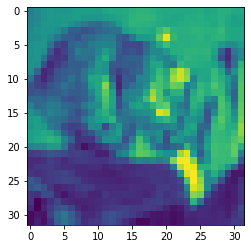

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.2063, -1.0775,  0.1813,  2.7137, -1.5681,  2.8801, -1.9524,  1.1648,
        -1.3023, -0.6821], grad_fn=<SelectBackward0>)


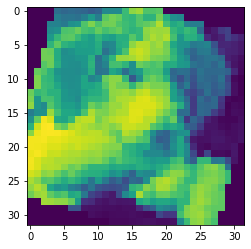

tensor([[-1.0000, -1.0000, -0.0510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2392,  ..., -0.2392, -0.2706, -0.3020],
        ...,
        [ 0.0902,  0.1373,  0.1059,  ...,  0.0431, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0902, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.5242, -1.6783,  1.7409, -0.0332,  2.6627, -0.6750, -0.1410, -0.4961,
         0.0175, -2.5143], grad_fn=<SelectBackward0>)


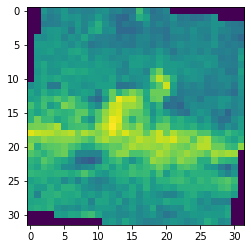

tensor([[-1.0000, -1.0000, -0.6235,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.7098, -0.8745,  ..., -0.2392, -0.2627, -1.0000],
        [-1.0000, -0.7255, -0.9137,  ..., -0.5137, -0.5373, -0.3098],
        ...,
        [ 0.1216, -0.0431, -0.0118,  ..., -0.1451,  0.0902, -1.0000],
        [-1.0000,  0.0745,  0.1216,  ..., -0.0980,  0.0588, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0431, -1.0000, -1.0000]]) tensor(7)
tensor([-2.6157, -3.4027,  1.6825, -0.3288,  5.0415,  1.6673,  2.2153,  5.0259,
        -6.5878, -3.3552], grad_fn=<SelectBackward0>)


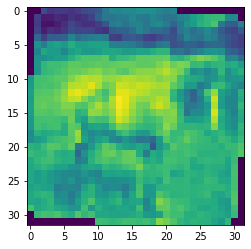

tensor([[ 0.1059,  0.1059,  0.1686,  ...,  0.1059,  0.0745,  0.0118],
        [ 0.1216,  0.2157,  0.1529,  ...,  0.2627,  0.2627,  0.1765],
        [ 0.2235,  0.2784,  0.2157,  ...,  0.1922,  0.2784,  0.3569],
        ...,
        [-0.0510, -0.1529, -0.2235,  ..., -0.2314, -0.2863, -0.3882],
        [ 0.0196,  0.1373,  0.1294,  ..., -0.2235, -0.2314, -0.2627],
        [ 0.0353,  0.1608,  0.1608,  ..., -0.0824, -0.0980, -0.1059]]) tensor(6)
tensor([-2.2052, -1.9716,  0.8311,  1.3109,  1.6043,  1.4631,  3.0717,  0.6564,
        -4.1215, -0.6884], grad_fn=<SelectBackward0>)


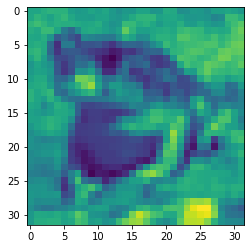

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6941,  ...,  0.8902,  0.8667, -1.0000],
        ...,
        [-1.0000, -0.0431, -0.0667,  ..., -0.3961, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5686, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 2.9829,  0.9780,  0.3574, -1.2386, -0.5346, -2.8784, -2.9915, -2.7708,
         5.2451,  0.8450], grad_fn=<SelectBackward0>)


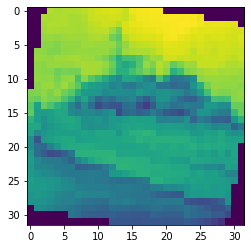

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.5702, -0.8820,  1.0619, -0.1660,  2.0626, -1.1798,  4.1928,  0.4535,
        -3.6923, -1.3406], grad_fn=<SelectBackward0>)


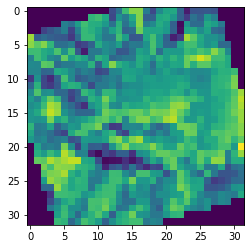

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([ 0.5517, -2.4065,  3.2663, -0.1481,  2.4604, -0.2829,  0.9811, -0.5387,
        -2.1227, -1.8715], grad_fn=<SelectBackward0>)


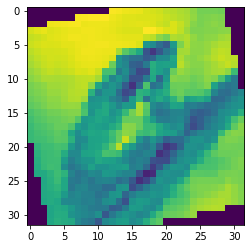

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3020, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2706, -1.0000, -1.0000],
        [-0.2627, -0.5137, -0.4667,  ..., -0.2549, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4902,  ...,  0.6549,  0.6000,  0.5843],
        [-1.0000, -1.0000,  0.4824,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4588,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([ 0.6498, -2.3797,  0.0894,  3.9279, -0.2994,  3.2345,  0.8528, -0.6524,
        -2.9392, -2.9615], grad_fn=<SelectBackward0>)


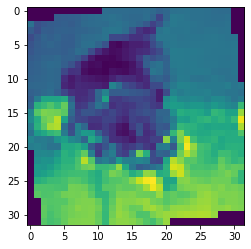

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.7266,  2.0143, -0.1316, -1.5192, -1.3162, -2.1282, -2.7636, -0.5958,
         2.1125,  1.3884], grad_fn=<SelectBackward0>)


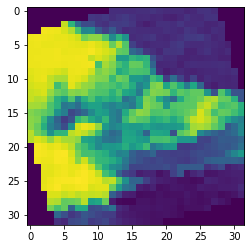

tensor([[0.3490, 0.3647, 0.3412,  ..., 0.3412, 0.3569, 0.3333],
        [0.3255, 0.3412, 0.3255,  ..., 0.3176, 0.3333, 0.3176],
        [0.3255, 0.3412, 0.3255,  ..., 0.3176, 0.3333, 0.3176],
        ...,
        [0.3569, 0.3647, 0.3412,  ..., 0.3647, 0.3804, 0.3647],
        [0.3490, 0.3647, 0.3490,  ..., 0.3725, 0.3882, 0.3725],
        [0.3490, 0.3647, 0.3569,  ..., 0.3804, 0.3961, 0.3804]]) tensor(2)
tensor([ 2.8291, -5.2334,  3.3325,  2.1299,  0.6778,  1.6445, -1.3883, -0.2270,
        -2.0056, -3.3489], grad_fn=<SelectBackward0>)


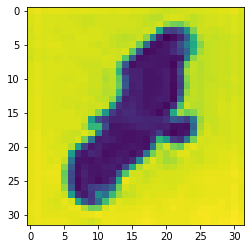

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 1.4460, -5.5990,  2.1753,  2.0184,  1.9573,  2.3118,  1.4283, -1.0792,
        -0.8304, -4.3478], grad_fn=<SelectBackward0>)


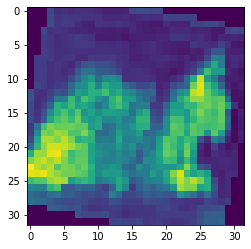

tensor([[-1.0000, -1.0000, -0.0353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1216,  ..., -0.2941, -1.0000, -1.0000],
        [-1.0000,  0.3333,  0.3569,  ..., -0.2157, -0.3176, -0.3569],
        ...,
        [-0.0588, -0.0431,  0.0431,  ..., -0.6941, -0.7804, -1.0000],
        [-1.0000, -1.0000, -0.0431,  ..., -0.8510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.3126,  1.1001, -0.3824, -0.0611, -0.1706, -0.6724, -1.1100, -0.6902,
        -0.9090,  0.8078], grad_fn=<SelectBackward0>)


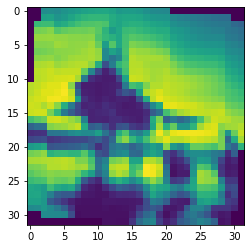

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6157,  0.3490, -1.0000],
        [ 0.6157,  0.6392,  0.5765,  ...,  0.3647, -0.0039, -1.0000],
        [ 0.5765,  0.5922,  0.5608,  ...,  0.3569,  0.2863, -1.0000],
        ...,
        [-1.0000,  0.3176,  0.3255,  ...,  0.4275,  0.3961,  0.4510],
        [-1.0000,  0.3020,  0.3176,  ...,  0.4745,  0.4667,  0.4196],
        [-1.0000,  0.3569,  0.3804,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-2.1676, -2.8227,  1.1509,  0.8155,  3.5480,  1.7445,  0.0794,  5.4097,
        -5.2964, -2.9107], grad_fn=<SelectBackward0>)


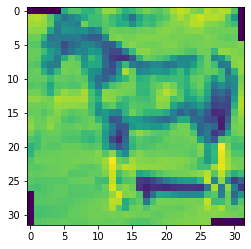

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.5046, -2.2170,  0.0323,  1.9970,  0.6804,  1.9912, -2.0042,  1.1850,
        -1.3731,  0.5097], grad_fn=<SelectBackward0>)


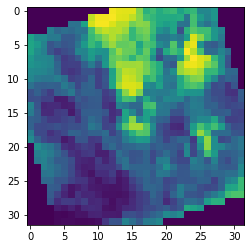

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.9021,  5.4982,  0.1615, -2.8352, -1.1322, -3.8545, -0.9288, -2.0591,
        -0.1547,  2.1258], grad_fn=<SelectBackward0>)


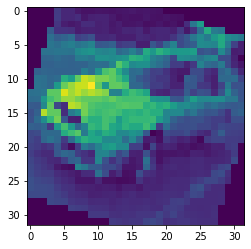

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2706,  ...,  0.0667, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4902,  ..., -0.4980, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-2.2581, -1.4826,  0.5435,  3.1726,  0.9989,  1.4576,  3.2470, -1.6260,
        -1.8678, -2.0064], grad_fn=<SelectBackward0>)


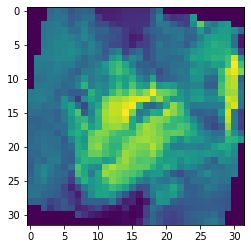

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.2166, -0.1538,  0.8797,  0.1283,  0.2633, -0.2398,  4.8682, -0.8389,
        -2.6841,  0.3005], grad_fn=<SelectBackward0>)


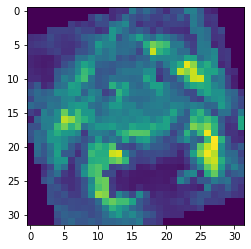

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2706, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2706, -1.0000, -1.0000],
        [ 0.3098,  0.3333,  0.3569,  ...,  0.2784, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1843,  ..., -0.4588, -0.4902, -0.3333],
        [-1.0000, -1.0000,  0.1059,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5216,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([ 0.1061, -2.7094, -0.2355,  1.2313,  1.7439,  1.9021, -2.6736,  5.8796,
        -4.7811, -0.1106], grad_fn=<SelectBackward0>)


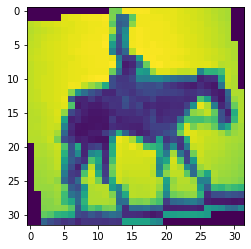

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2000, -0.2314, -1.0000],
        [-0.4510, -0.4039, -0.3804,  ..., -0.2078, -0.1922, -1.0000],
        [-0.3725, -0.3176, -0.3333,  ..., -0.2157, -0.1608, -1.0000],
        ...,
        [-1.0000, -0.0824, -0.0667,  ...,  0.1373,  0.1059,  0.0196],
        [-1.0000, -0.0353,  0.0275,  ...,  0.0510, -0.0118, -0.0039],
        [-1.0000,  0.0039,  0.0824,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-0.1737, -3.9668,  2.8950,  0.7230,  3.2935,  0.8083,  2.1866, -0.9021,
        -1.7828, -4.0321], grad_fn=<SelectBackward0>)


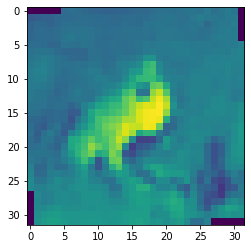

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.2472, -4.5909,  2.0972,  3.5913,  1.6837,  3.4840, -0.9102,  0.3018,
        -2.3984, -4.0927], grad_fn=<SelectBackward0>)


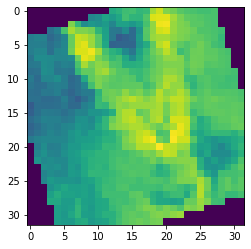

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-2.3360, -3.6911,  1.6257,  2.6743,  1.8011,  1.3977,  3.3841, -0.0075,
        -2.7218, -2.4399], grad_fn=<SelectBackward0>)


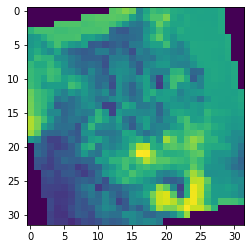

tensor([[-1.0000,  1.0000,  1.0000,  ...,  0.5059,  0.5059, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.5373,  0.5373,  0.5608],
        [ 0.9373,  0.8824,  0.9451,  ...,  0.5529,  0.5765,  0.6314],
        ...,
        [-0.5843, -0.5922, -0.5922,  ..., -0.5922, -0.6000, -0.6157],
        [-0.5843, -0.5922, -0.6078,  ..., -0.5922, -0.6078, -0.6235],
        [-1.0000, -0.5922, -0.5922,  ..., -0.6078, -0.6235, -1.0000]]) tensor(0)
tensor([ 5.5795,  3.2025, -0.9237, -2.2855, -1.3773, -5.2730, -5.5207, -3.9077,
         6.8278,  1.9970], grad_fn=<SelectBackward0>)


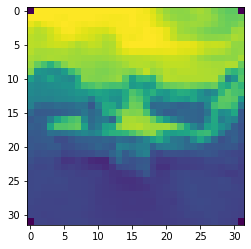

tensor([[-0.6941, -0.7098, -0.7255,  ..., -0.7176, -0.7098, -0.7804],
        [-0.7333, -0.7725, -0.7804,  ..., -0.7804, -0.8118, -0.7490],
        [-0.7725, -0.7961, -0.7098,  ..., -0.7725, -0.8196, -0.7647],
        ...,
        [ 0.8745,  0.8902,  0.8510,  ..., -0.0667, -0.0196,  0.0118],
        [ 0.5216,  0.5529,  0.5294,  ..., -0.1216, -0.1059, -0.0902],
        [-0.0196, -0.0353, -0.0588,  ..., -0.1608, -0.0980, -0.0353]]) tensor(8)
tensor([ 2.6336, -2.5005,  1.9064,  0.1537,  2.5253, -0.7552, -0.6898, -1.6690,
        -0.5744, -2.3850], grad_fn=<SelectBackward0>)


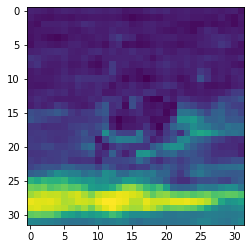

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0824, -1.0000, -1.0000],
        [-0.3725, -0.2235, -0.2471,  ..., -0.0431, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.5922,  ...,  0.1843, -0.2941, -0.2706],
        [-1.0000, -1.0000, -0.5451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-1.7063, -3.9981,  3.4408,  1.8839,  1.2266,  3.8510, -1.6874,  2.6040,
        -3.4238, -2.8250], grad_fn=<SelectBackward0>)


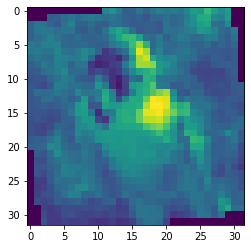

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.4973,  1.1637, -0.9946,  0.1467,  0.0448, -0.6811,  0.4180, -1.2564,
        -0.8160,  3.1335], grad_fn=<SelectBackward0>)


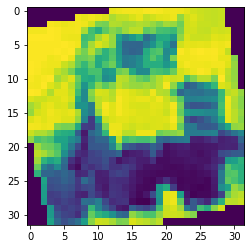

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6941, -1.0000, -1.0000],
        [ 0.5686,  0.5922,  0.6157,  ...,  0.7020, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.7020,  ...,  0.6941,  0.6784,  0.6627],
        [-1.0000, -1.0000,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7255,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.1547, -4.1593,  1.1443,  1.7706,  1.8441,  1.9237,  0.9027,  0.0485,
        -2.6153, -2.6788], grad_fn=<SelectBackward0>)


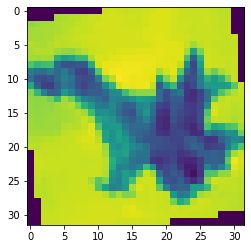

tensor([[-1.0000, -0.2235, -0.2157,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.2235, -0.2157,  ..., -0.0824, -0.0824, -0.0980],
        [-1.0000, -0.2235, -0.2157,  ..., -0.0980, -0.0980, -0.1137],
        ...,
        [-0.2471, -0.2392, -0.2549,  ..., -0.2157, -0.2157, -1.0000],
        [-0.2627, -0.2549, -0.2549,  ..., -0.2078, -0.2078, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2078, -0.2000, -1.0000]]) tensor(3)
tensor([-1.3003, -3.9026,  0.7724,  2.9574,  0.9000,  2.9312,  0.1568,  0.1353,
        -0.3502, -3.0185], grad_fn=<SelectBackward0>)


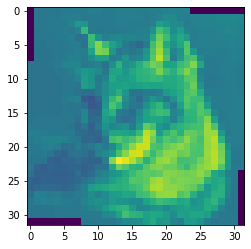

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7569,  ...,  0.4118, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1922,  ...,  0.3333, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.1622, -4.4720,  3.8565,  1.8102,  2.6862,  1.6542,  0.5146,  0.6675,
        -3.5291, -3.9460], grad_fn=<SelectBackward0>)


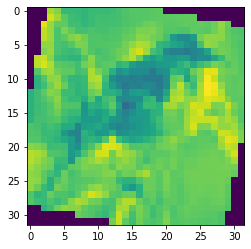

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.6370, -2.9642,  0.3206,  1.8363,  0.6786,  2.2101, -1.4937,  1.5161,
        -1.5270,  0.0394], grad_fn=<SelectBackward0>)


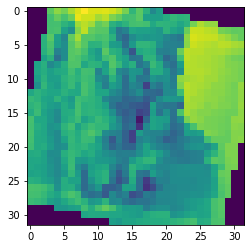

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8824,  ...,  0.9529, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.6941,  ...,  0.6941, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.0127,  1.4625, -1.1851,  0.4832, -1.6357, -1.4948, -0.4573, -2.5415,
         2.5782,  2.8274], grad_fn=<SelectBackward0>)


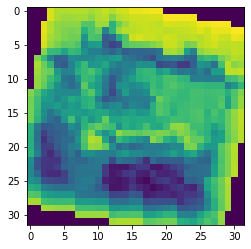

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 2.5814,  2.3624, -0.8354, -0.5976, -0.3368, -2.2537, -2.8114, -1.5303,
         2.1902,  0.4840], grad_fn=<SelectBackward0>)


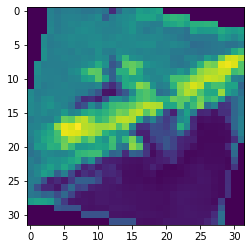

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-3.5506, -3.3508,  0.9051,  1.2293,  3.0997,  0.9247,  5.4804,  0.3951,
        -3.3080, -1.7490], grad_fn=<SelectBackward0>)


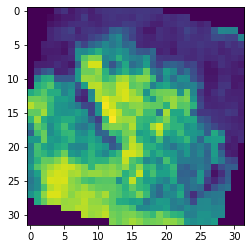

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3882, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4039, -1.0000, -1.0000],
        [-0.2392, -0.2627, -0.2784,  ..., -0.4353, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0353,  ..., -0.6000, -0.6000, -0.5529],
        [-1.0000, -1.0000, -0.0667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3412,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 1.4307, -0.6139,  0.0930, -0.1233,  1.5519, -0.6218, -1.4492, -0.0862,
         0.7527, -0.7383], grad_fn=<SelectBackward0>)


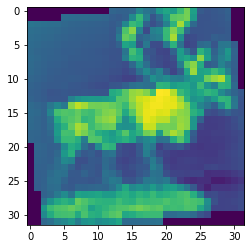

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.4479, -4.0882,  2.2703,  2.8844,  0.5630,  5.6905, -1.5358,  0.3783,
        -2.8372, -3.5603], grad_fn=<SelectBackward0>)


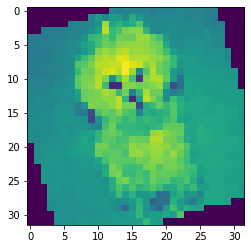

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 4.3543, -1.2440,  1.3758, -0.2634,  1.2781, -1.2428, -1.1960, -1.5049,
        -0.2051, -1.6742], grad_fn=<SelectBackward0>)


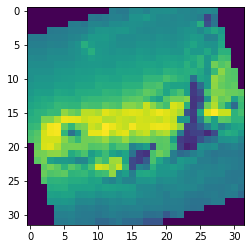

tensor([[-1.0000,  0.0667,  0.0667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0353,  0.0353,  ..., -0.1451, -0.1529, -0.1686],
        [-1.0000,  0.0196,  0.0275,  ..., -0.1608, -0.1686, -0.1843],
        ...,
        [-0.5529, -0.5451, -0.5529,  ..., -0.6706, -0.6863, -1.0000],
        [-0.5686, -0.5608, -0.5608,  ..., -0.7176, -0.6784, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7412, -0.6863, -1.0000]]) tensor(8)
tensor([ 2.6937,  0.1237, -0.3058, -0.3296, -0.2575, -1.6666, -2.3949, -1.8742,
         3.4469, -0.1268], grad_fn=<SelectBackward0>)


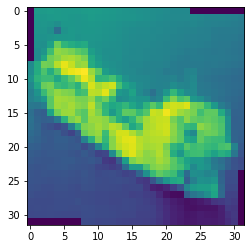

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 0.8350, -5.4749,  5.0473,  1.3698,  2.9218,  1.2970, -0.1122, -0.4186,
        -1.7529, -4.7450], grad_fn=<SelectBackward0>)


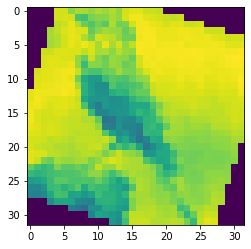

tensor([[ 0.0980,  0.2784, -0.0196,  ...,  0.1373,  0.1529,  0.1294],
        [ 0.2392,  0.3333,  0.2314,  ...,  0.4824,  0.4431,  0.4118],
        [-0.3804, -0.3804, -0.3961,  ...,  0.7961,  0.7882,  0.7333],
        ...,
        [-0.8196, -0.8824, -0.9216,  ..., -0.6392, -0.7176, -0.7490],
        [-0.8902, -0.8667, -0.8431,  ..., -0.6157, -0.8196, -0.7569],
        [-0.8353, -0.8667, -0.8510,  ..., -0.6549, -0.8431, -0.7961]]) tensor(3)
tensor([-1.4509, -4.7897,  0.8093,  3.6131,  0.7054,  2.9533,  0.9821,  1.2905,
        -2.0964, -1.9818], grad_fn=<SelectBackward0>)


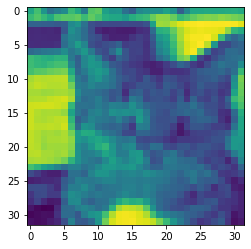

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-1.7581, -2.5589,  0.5108,  1.5163,  3.9897,  2.9677, -3.0925,  5.7225,
        -4.6940, -3.0323], grad_fn=<SelectBackward0>)


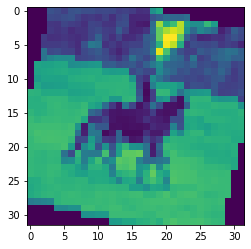

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.5948, -2.8494,  1.0330,  3.9983,  1.8811,  3.0406,  0.7168,  0.4531,
        -3.0243, -3.8544], grad_fn=<SelectBackward0>)


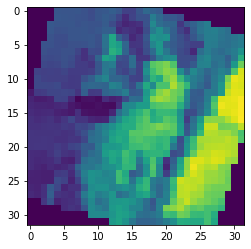

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.8275, -1.0000, -1.0000],
        [-1.0000,  0.8510,  0.8353,  ...,  0.8588, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.3020,  ..., -0.3882, -0.3882, -1.0000],
        [-1.0000, -1.0000, -0.2078,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.6443,  7.4083, -2.5731, -1.0493, -2.6933, -2.6938, -3.4834, -1.7964,
         0.3852,  5.6845], grad_fn=<SelectBackward0>)


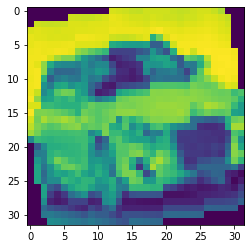

tensor([[-1.0000, -1.0000,  0.0353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1059,  ..., -0.4353, -1.0000, -1.0000],
        [-1.0000,  0.1059,  0.0588,  ..., -0.5059, -0.3569, -0.3569],
        ...,
        [ 0.8667,  0.7098,  0.7804,  ...,  0.6471,  0.7569, -1.0000],
        [-1.0000, -1.0000,  0.7333,  ...,  0.6627, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5922, -1.0000, -1.0000]]) tensor(6)
tensor([-0.5193, -3.2805,  0.1058,  2.3692,  2.2360,  3.0436,  0.4536,  2.1877,
        -4.2766, -2.8020], grad_fn=<SelectBackward0>)


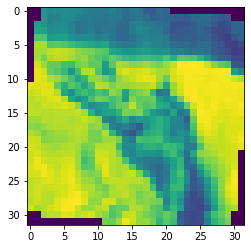

tensor([[-1.0000, -0.0039,  0.0039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0039,  0.0118,  ...,  0.0196,  0.0196,  0.0196],
        [-1.0000, -0.0039,  0.0118,  ..., -0.0039, -0.0039, -0.0196],
        ...,
        [-0.0039, -0.0039, -0.0039,  ..., -0.0039, -0.0118, -1.0000],
        [ 0.0039,  0.0039,  0.0118,  ..., -0.0039, -0.0118, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0039, -0.0118, -1.0000]]) tensor(3)
tensor([-1.5595, -2.7680,  1.0535,  2.0713,  3.4424,  1.7623,  2.3700,  1.0490,
        -4.2341, -3.3925], grad_fn=<SelectBackward0>)


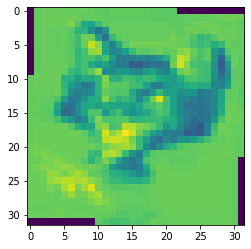

tensor([[-1.0000, -1.0000,  0.2078,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0667,  ..., -0.5686, -1.0000, -1.0000],
        [-1.0000, -0.2784, -0.4510,  ..., -0.5765, -0.5608, -0.5922],
        ...,
        [ 0.1765,  0.2078,  0.0118,  ...,  0.0196,  0.0118, -1.0000],
        [-1.0000, -1.0000,  0.1373,  ...,  0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0902, -1.0000, -1.0000]]) tensor(7)
tensor([-0.2030, -1.2473,  0.8592,  0.2913,  2.2926,  0.7083, -1.8698,  3.1972,
        -3.1212, -0.6484], grad_fn=<SelectBackward0>)


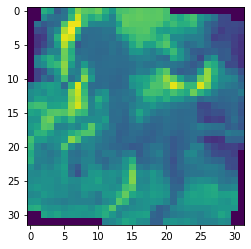

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-1.0492, -1.9664, -0.3481,  0.6798,  1.4703,  0.5595, -0.7613,  2.6681,
        -2.2454,  1.2538], grad_fn=<SelectBackward0>)


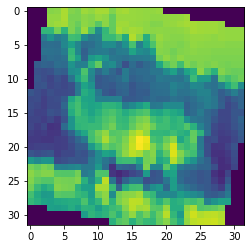

tensor([[-0.3569, -0.3569, -0.3333,  ..., -0.5686, -0.3098, -0.2627],
        [-0.3725, -0.3804, -0.3490,  ..., -0.5373, -0.2784, -0.2392],
        [-0.4039, -0.4118, -0.4039,  ..., -0.5216, -0.2706, -0.2392],
        ...,
        [ 0.0902,  0.1608,  0.1922,  ...,  0.2549,  0.2314,  0.2235],
        [ 0.1294,  0.1529,  0.1922,  ...,  0.2392,  0.2157,  0.2078],
        [ 0.1137,  0.1294,  0.2000,  ...,  0.2157,  0.1922,  0.1843]]) tensor(1)
tensor([ 1.5838,  1.9706, -1.1617,  0.1888,  0.3939, -0.7557, -1.0256, -1.8226,
        -0.5292,  1.0799], grad_fn=<SelectBackward0>)


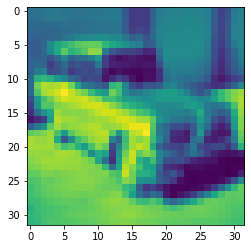

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.0886,  1.0849, -0.9129,  0.7075, -1.7238, -0.3012,  0.0284, -1.6702,
        -0.0411,  2.9088], grad_fn=<SelectBackward0>)


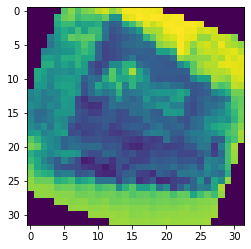

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([ 0.9124, -3.1860,  3.2379,  2.4420,  1.6538,  2.9111, -3.4481,  1.5443,
        -2.9947, -3.6656], grad_fn=<SelectBackward0>)


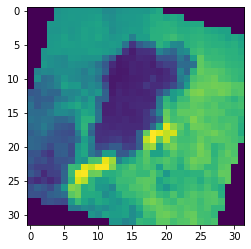

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1137,  ...,  0.1765, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.7569,  ..., -0.6941, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-0.0582,  1.3801,  0.7037, -1.1639,  0.7661, -0.8554, -0.1943,  0.7472,
        -1.3956,  0.0337], grad_fn=<SelectBackward0>)


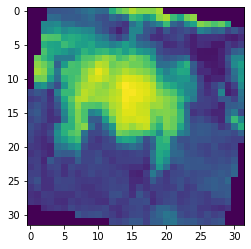

tensor([[ 0.2784,  0.2863,  0.2784,  ...,  0.2471,  0.3098,  0.2863],
        [ 0.3176,  0.3569,  0.3490,  ...,  0.0196,  0.4039,  0.3569],
        [ 0.3176,  0.3725,  0.3569,  ...,  0.1765,  0.3647,  0.3804],
        ...,
        [ 0.0824,  0.0431, -0.2549,  ...,  0.1529,  0.1216,  0.1451],
        [ 0.0588,  0.0745,  0.0431,  ...,  0.1686,  0.1294,  0.1059],
        [ 0.0510,  0.0588,  0.1059,  ...,  0.1059,  0.1608,  0.1765]]) tensor(7)
tensor([-0.0212, -2.0809, -0.2000, -0.1328,  1.1949,  0.8495, -1.9401,  5.4719,
        -4.7267,  1.5252], grad_fn=<SelectBackward0>)


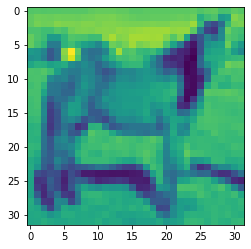

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4588, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9137,  ...,  0.4824, -1.0000, -1.0000],
        [ 0.5216,  0.6314,  0.9216,  ...,  0.4902,  0.4745, -1.0000],
        ...,
        [-1.0000,  0.3255,  0.2471,  ..., -0.5451, -0.5216, -0.5451],
        [-1.0000, -1.0000,  0.3020,  ..., -0.4745, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3961,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-0.7393,  1.6977, -0.5209,  0.0480,  0.1259, -0.4712, -0.5884, -0.0540,
        -1.5243,  2.6252], grad_fn=<SelectBackward0>)


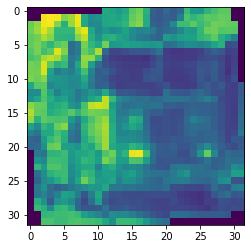

tensor([[-1.0000, -1.0000,  0.8588,  ...,  0.4275,  0.4275, -1.0000],
        [ 0.8510,  0.8824,  0.8588,  ...,  0.6078,  0.5294, -1.0000],
        [ 0.8196,  0.8588,  0.7882,  ...,  0.7098,  0.7333,  0.6314],
        ...,
        [ 0.4275,  0.3098,  0.2549,  ..., -0.1216,  0.0118, -0.0510],
        [-1.0000,  0.4039,  0.2784,  ...,  0.4588,  0.3176, -0.0118],
        [-1.0000,  0.5529,  0.5059,  ...,  0.4745, -1.0000, -1.0000]]) tensor(2)
tensor([ 1.1008, -4.8757,  3.9037,  1.4688,  1.9494,  1.2076, -0.5250, -0.2480,
        -1.5390, -3.3230], grad_fn=<SelectBackward0>)


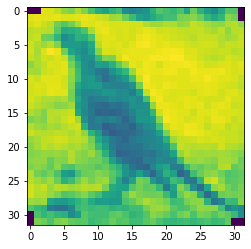

tensor([[-0.3725, -0.4039, -0.4275,  ...,  0.2078,  0.2235,  0.2549],
        [-0.3725, -0.3961, -0.2471,  ...,  0.1843,  0.2078,  0.2471],
        [-0.3490, -0.2314, -0.0980,  ...,  0.1765,  0.2078,  0.2627],
        ...,
        [ 0.0353, -0.0039, -0.1137,  ..., -0.5216, -0.1608,  0.0902],
        [-0.1608, -0.3569, -0.5294,  ..., -0.0824, -0.0118,  0.0196],
        [-0.5294, -0.6314, -0.7255,  ..., -0.0353, -0.0275, -0.0039]]) tensor(2)
tensor([-0.9490, -1.4337,  1.6458,  1.1747,  1.1188, -0.5142,  1.2619, -1.4099,
        -0.1211, -1.0476], grad_fn=<SelectBackward0>)


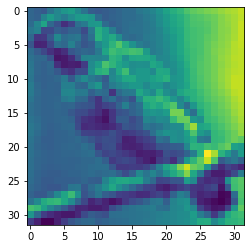

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 5.6764, -0.5247,  2.8685, -1.2655,  1.4097, -2.2529, -3.3381, -2.6338,
         0.4592, -1.7717], grad_fn=<SelectBackward0>)


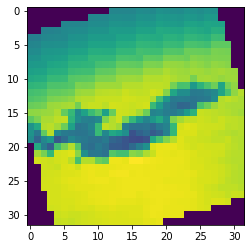

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6157,  ...,  0.7804, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.7647,  ..., -0.3490, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 3.2706, -0.4355,  0.6363, -0.9745,  0.5416, -2.6939, -2.5509, -3.3004,
         5.7476, -0.7139], grad_fn=<SelectBackward0>)


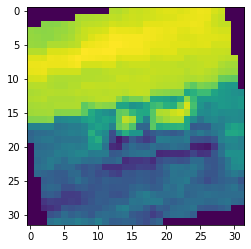

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-1.8821, -0.3091, -0.9215,  1.9031,  0.8556,  0.5985,  1.5542,  0.0859,
        -1.6955,  0.5177], grad_fn=<SelectBackward0>)


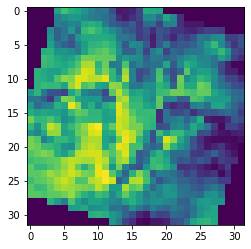

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3098,  0.5294, -1.0000],
        [ 0.7490,  0.6392,  0.6392,  ...,  0.6078,  0.6627, -1.0000],
        [ 0.5137,  0.3098,  0.4039,  ...,  0.7333,  0.7176, -1.0000],
        ...,
        [-1.0000,  0.6706,  0.6863,  ...,  0.4431,  0.1059,  0.3098],
        [-1.0000,  0.6941,  0.7412,  ...,  0.8510,  0.7412,  0.7255],
        [-1.0000,  0.7490,  0.7255,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 0.8624, -2.4819,  0.5920,  1.9928,  0.4844,  1.5101, -0.3321,  1.1166,
        -2.6785, -1.1488], grad_fn=<SelectBackward0>)


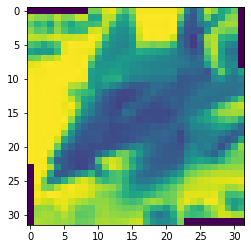

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7725,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7882,  ...,  0.5294,  0.5529, -1.0000],
        ...,
        [-1.0000,  0.5608,  0.5451,  ...,  0.3882, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3882, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 4.7315,  0.6124,  3.1504, -1.0092,  0.7696, -2.2146, -3.1029, -2.1440,
        -0.5836, -1.5138], grad_fn=<SelectBackward0>)


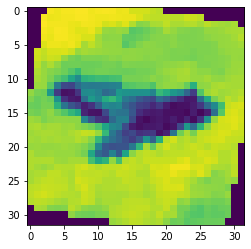

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 4.2672,  1.0922,  0.1595, -1.9171,  1.2711, -3.2635, -2.9122, -1.5165,
         2.6562, -0.6516], grad_fn=<SelectBackward0>)


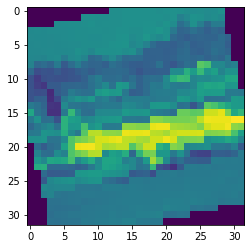

tensor([[-1.0000,  1.0000,  0.9765,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9765,  0.9373,  ...,  0.9059,  0.8980,  0.8902],
        [-1.0000,  0.9765,  0.8588,  ...,  0.9529,  0.9686,  0.9451],
        ...,
        [ 0.4667,  0.5059,  0.5059,  ..., -0.8667, -0.8745, -1.0000],
        [ 0.6627,  0.7569,  0.8353,  ..., -0.5373, -0.6000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5922,  0.4667, -1.0000]]) tensor(9)
tensor([ 0.1150, -0.8704, -1.5803,  1.3901, -1.8306,  0.1795, -0.5510, -0.1219,
        -0.4353,  3.4580], grad_fn=<SelectBackward0>)


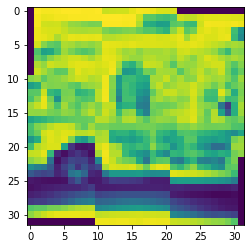

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.4620, -0.0558, -0.5638,  1.5777,  0.1573, -0.2697,  3.1396, -2.2787,
        -0.6946, -0.2132], grad_fn=<SelectBackward0>)


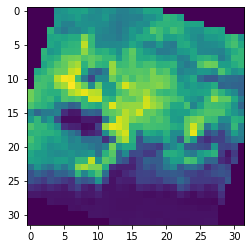

tensor([[-1.0000, -0.4275, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.4745, -0.4118,  ..., -0.1216, -0.1608, -0.2078],
        [-1.0000, -0.5373, -0.5059,  ..., -0.3098, -0.3569, -0.3804],
        ...,
        [-0.7412, -0.8275, -0.8824,  ..., -0.5608, -0.5686, -1.0000],
        [-0.7804, -0.8667, -0.9137,  ..., -0.5294, -0.5608, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4588, -0.4902, -1.0000]]) tensor(8)
tensor([ 3.9293, -1.2402,  1.0413, -0.7729,  1.1422, -1.6493, -0.8994, -2.5105,
         2.3190, -2.1642], grad_fn=<SelectBackward0>)


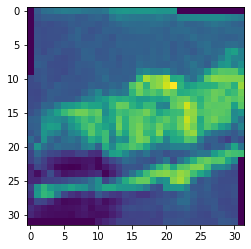

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.0871,  0.9091, -0.7214,  0.5901, -0.2675, -0.7547,  0.0149, -1.3372,
         0.4800,  1.0593], grad_fn=<SelectBackward0>)


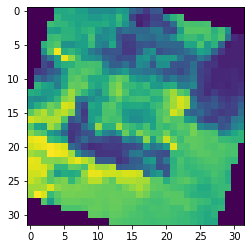

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.4460, -2.8785,  1.6256,  3.1844, -0.0501,  2.8828, -0.6838, -0.0233,
        -2.1464, -2.3004], grad_fn=<SelectBackward0>)


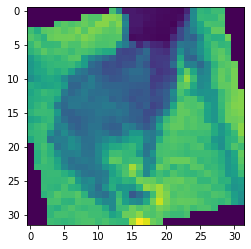

tensor([[-1.0000, -0.7333, -0.8431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.7255, -0.8431,  ..., -0.7412, -0.7725, -0.6627],
        [-1.0000, -0.7961, -0.7882,  ..., -0.8510, -0.8275, -0.7020],
        ...,
        [-0.6157, -0.5451, -0.5137,  ..., -0.5686, -0.4510, -1.0000],
        [-0.3882, -0.3098, -0.2314,  ..., -0.6392, -0.5843, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5451, -0.5765, -1.0000]]) tensor(7)
tensor([-0.9103, -4.5958,  2.6457,  4.2438, -0.7639,  4.8028, -3.9407,  2.8657,
        -2.1316, -2.0930], grad_fn=<SelectBackward0>)


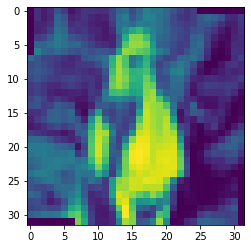

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-1.2513, -3.8353, -0.0848,  2.7304,  0.7023,  3.3288,  0.3506,  2.6315,
        -4.1113, -0.6600], grad_fn=<SelectBackward0>)


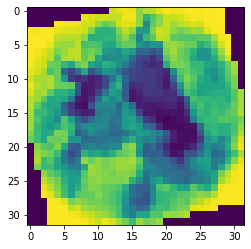

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 1.8346,  0.8041,  0.1284, -0.9453, -0.9969, -2.4891, -1.4895, -1.7333,
         3.7035,  0.4679], grad_fn=<SelectBackward0>)


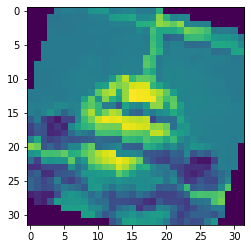

tensor([[-1.0000, -0.9216, -0.9608,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9294, -0.9765,  ...,  0.9451,  0.8824,  0.7647],
        [-1.0000, -0.8431, -0.9294,  ...,  0.9843,  0.9059,  0.4039],
        ...,
        [-0.1294, -0.0980, -0.0275,  ...,  0.1608,  0.6157, -1.0000],
        [-0.1137, -0.0275,  0.0275,  ...,  0.1373,  0.4824, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1373,  0.3333, -1.0000]]) tensor(3)
tensor([-0.7344, -3.8103,  2.0054,  3.1215,  3.4401,  3.6460, -1.2520,  2.6045,
        -5.3156, -4.1112], grad_fn=<SelectBackward0>)


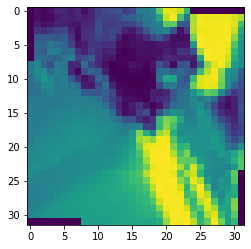

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.2242,  0.1252, -0.7181,  0.3564, -0.8899,  0.3212, -1.9177,  1.8232,
        -0.8484,  2.7700], grad_fn=<SelectBackward0>)


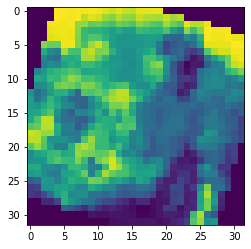

tensor([[-1.0000,  0.0588,  0.0510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0745,  0.0667,  ...,  0.3098,  0.3020,  0.2863],
        [-1.0000,  0.0353,  0.0824,  ...,  0.4588,  0.3961,  0.2627],
        ...,
        [ 0.2157,  0.1529,  0.2549,  ..., -0.2863, -0.0353, -1.0000],
        [ 0.0431,  0.1216,  0.1608,  ..., -0.0902, -0.0824, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -0.0745, -1.0000]]) tensor(5)
tensor([-0.2873, -4.3001,  2.8913,  1.2395,  2.9282,  3.8161, -2.4010,  2.3307,
        -3.7311, -3.5853], grad_fn=<SelectBackward0>)


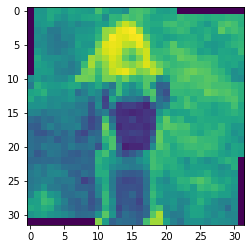

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3255, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3569, -1.0000, -1.0000],
        [ 0.5686,  0.5216,  0.6314,  ..., -0.3490, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.2784,  ...,  0.0118,  0.0510,  0.0980],
        [-1.0000, -1.0000,  0.2706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.6786,  3.7830, -0.2916, -1.8633, -0.8541, -2.8664, -2.2987, -1.5182,
         0.5046,  4.0330], grad_fn=<SelectBackward0>)


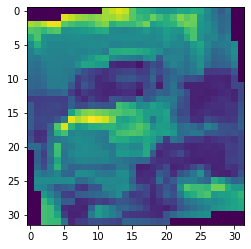

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2157,  ..., -0.1373, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.5059,  ..., -0.3176, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 5.2226,  1.3603,  0.8231, -2.0865,  1.3396, -3.5431, -3.8139, -1.3325,
         1.3018, -0.3295], grad_fn=<SelectBackward0>)


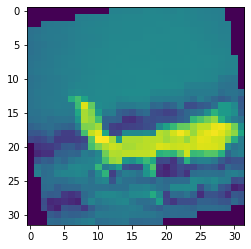

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.0567, -3.3589,  0.9203,  1.9316,  1.4056,  1.8259,  0.0325,  0.9728,
        -1.3012, -2.3564], grad_fn=<SelectBackward0>)


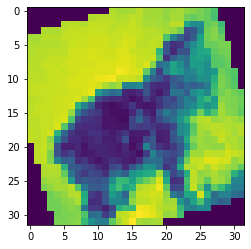

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2314,  ...,  0.1059, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1294,  ...,  0.1216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.7578, -1.4082,  0.4816,  2.0437,  0.6417,  0.8109,  2.6142, -0.7210,
        -1.7052, -0.7502], grad_fn=<SelectBackward0>)


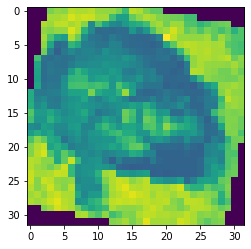

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.2223, -1.0287,  0.8222, -0.9308,  1.0541, -0.8624, -1.1885, -1.7217,
         2.5375, -1.7626], grad_fn=<SelectBackward0>)


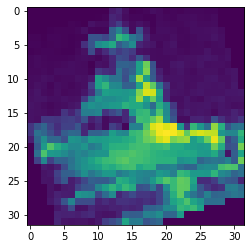

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.6951,  3.6420, -0.1075, -0.1967, -1.6835, -2.5966, -2.4950, -3.0318,
         2.6679,  1.0603], grad_fn=<SelectBackward0>)


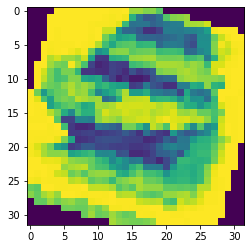

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9686,  ...,  0.9608, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9608,  ...,  0.9686, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 2.8808,  4.3409, -0.4323, -1.2157,  0.2275, -2.9975, -3.6092, -0.5857,
        -1.1042,  2.1507], grad_fn=<SelectBackward0>)


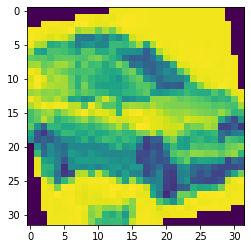

tensor([[-1.0000, -1.0000, -0.0588,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0196,  ..., -0.1137, -0.1294, -0.0824],
        ...,
        [ 0.1922,  0.2471,  0.2941,  ...,  0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2706, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2784, -1.0000, -1.0000]]) tensor(2)
tensor([ 1.2793, -3.6632,  2.6645,  1.2659,  2.1962,  1.3474, -0.3563, -0.5540,
        -1.2628, -3.5831], grad_fn=<SelectBackward0>)


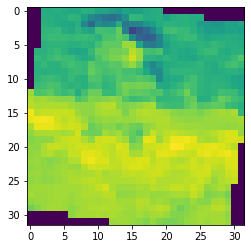

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 3.8125,  3.5066, -0.7801, -2.0516, -1.2113, -4.2557, -3.5257, -3.6729,
         4.6644,  2.4513], grad_fn=<SelectBackward0>)


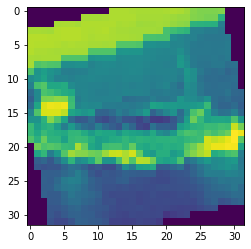

tensor([[-1.0000,  0.5686,  0.6000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5843,  0.6078,  ...,  0.3647,  0.6157,  0.2392],
        [-1.0000,  0.5843,  0.6078,  ...,  0.5843,  0.8039,  0.5294],
        ...,
        [ 0.1216,  0.1294,  0.1451,  ...,  0.5686,  0.6078, -1.0000],
        [ 0.2078,  0.2157,  0.2314,  ...,  0.4824,  0.5059, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6314,  0.6471, -1.0000]]) tensor(3)
tensor([-0.4120, -3.5232,  0.4935,  2.3749,  0.0336,  3.3533, -1.6915,  2.2658,
        -1.9864, -1.5131], grad_fn=<SelectBackward0>)


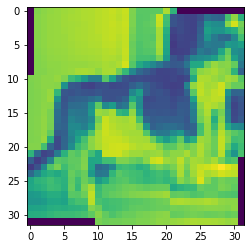

tensor([[-1.0000, -1.0000,  0.5451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.5608,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.5843,  ...,  0.2157,  0.2157,  0.2078],
        ...,
        [ 0.0118,  0.0353,  0.0275,  ..., -0.5216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6392, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6235, -1.0000, -1.0000]]) tensor(7)
tensor([ 0.6434, -3.9989,  1.9003,  2.1661,  0.9317,  3.0484, -3.1003,  1.7003,
        -1.4818, -2.3292], grad_fn=<SelectBackward0>)


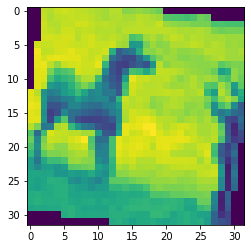

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.6607, -1.9398,  1.0313, -0.0359,  2.5982,  0.8468,  3.9979,  0.8102,
        -4.5544, -1.2329], grad_fn=<SelectBackward0>)


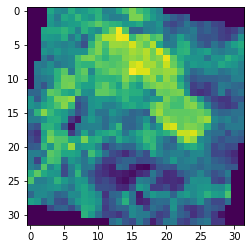

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6941,  0.6000, -1.0000],
        [ 0.7412,  0.7255,  0.7176,  ...,  0.7961,  0.6784, -1.0000],
        [ 0.6941,  0.7098,  0.7255,  ...,  0.8039,  0.6863, -1.0000],
        ...,
        [-1.0000,  0.3176,  0.4588,  ...,  0.3020,  0.3412,  0.5294],
        [-1.0000,  0.3569,  0.5137,  ...,  0.3569,  0.3490,  0.5294],
        [-1.0000,  0.4980,  0.5765,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-0.8762, -5.4221,  1.8014,  2.8866,  0.9128,  2.9067, -0.2266,  0.9178,
        -0.9773, -2.4807], grad_fn=<SelectBackward0>)


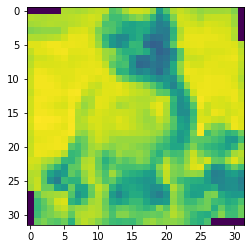

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.5470,  1.3997, -0.9760, -0.0070,  0.2137, -0.7977,  0.8808, -1.8131,
         0.1982,  1.7361], grad_fn=<SelectBackward0>)


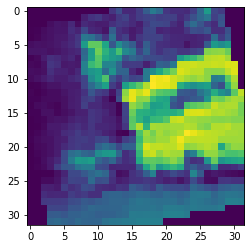

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.5843,  0.6078, -1.0000],
        [-0.8431, -0.7490, -0.5451,  ...,  0.6471,  0.6706, -1.0000],
        [-0.8902, -0.7647, -0.5686,  ...,  0.6706,  0.6941, -1.0000],
        ...,
        [-1.0000,  0.0667,  0.1216,  ..., -0.2392, -0.2392, -0.2157],
        [-1.0000,  0.0510,  0.1608,  ..., -0.2235, -0.2157, -0.2235],
        [-1.0000,  0.1059,  0.2000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.5088, -3.7038,  1.0330,  1.2045,  1.9330,  2.4747, -1.9802,  3.8854,
        -2.6282, -1.2151], grad_fn=<SelectBackward0>)


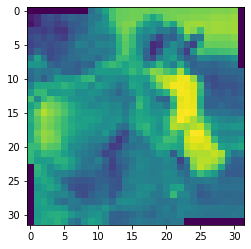

tensor([[-1.0000, -0.4039, -0.2941,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0118,  0.2627,  ..., -0.5294, -0.6000, -0.6471],
        [-1.0000,  0.0353,  0.1059,  ..., -0.5216, -0.4745, -0.5922],
        ...,
        [ 0.5843,  0.3961,  0.0431,  ...,  0.8510,  0.8353, -1.0000],
        [ 0.6471,  0.6471,  0.5451,  ...,  0.8745,  0.8510, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.8510,  0.8275, -1.0000]]) tensor(9)
tensor([ 0.8526,  5.9867, -0.7360, -2.2728, -0.5873, -2.7767, -1.9054, -1.6638,
        -2.1164,  5.3600], grad_fn=<SelectBackward0>)


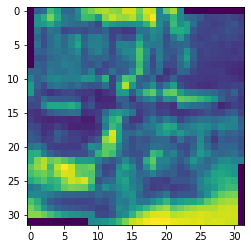

tensor([[-1.0000, -1.0000,  0.3569,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3490,  ...,  0.3804,  0.3961,  0.3882],
        ...,
        [ 0.0745,  0.1373,  0.1686,  ...,  0.1451, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1686, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1451, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.8711, -2.0650,  4.0539,  0.4803,  1.1385,  1.9570, -0.6568,  0.3743,
        -4.1074, -2.7253], grad_fn=<SelectBackward0>)


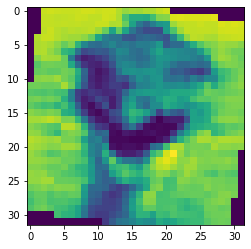

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1529,  ..., -0.2706, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4980,  ..., -0.4902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.1896,  4.3108, -2.4059, -0.1654,  0.1397,  0.0346, -0.5230,  0.0214,
        -3.2739,  2.8313], grad_fn=<SelectBackward0>)


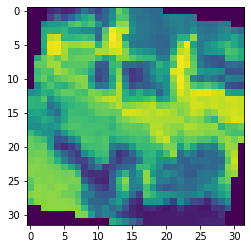

tensor([[-1.0000, -1.0000,  0.6863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6941,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6627,  ...,  0.7882,  0.7804,  0.7725],
        ...,
        [ 0.6627,  0.6863,  0.7020,  ...,  0.6314, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6157, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6235, -1.0000, -1.0000]]) tensor(9)
tensor([ 2.1113,  3.5355, -0.7888, -1.6120, -0.0535, -2.4017, -3.0290, -0.9412,
        -0.8116,  3.3908], grad_fn=<SelectBackward0>)


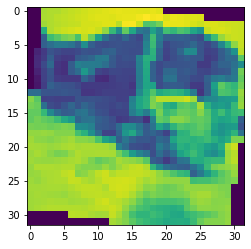

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3255, -0.3255, -1.0000],
        [-0.3961, -0.3882, -0.3804,  ..., -0.3412, -0.3412, -1.0000],
        [-0.4118, -0.4039, -0.4039,  ..., -0.3490, -0.3490, -1.0000],
        ...,
        [-1.0000, -0.3333, -0.3882,  ..., -0.2784, -0.3176, -0.3255],
        [-1.0000, -0.3961, -0.2863,  ..., -0.2471, -0.2314, -0.2392],
        [-1.0000, -0.3804, -0.2078,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.3870, -3.1292,  1.6032,  0.7985,  0.8965,  0.5557, -0.6906, -1.1427,
         0.8767, -2.8642], grad_fn=<SelectBackward0>)


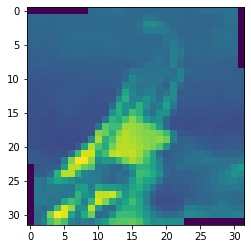

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.8753, -3.2485,  2.2322,  1.2724,  2.7320,  1.4252,  2.0448,  0.5038,
        -3.1550, -2.0093], grad_fn=<SelectBackward0>)


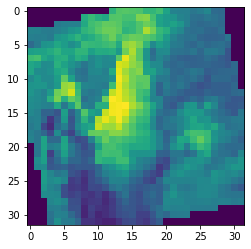

tensor([[ 0.7647,  0.7255,  0.7333,  ...,  0.6627,  0.6706,  0.6706],
        [ 0.7804,  0.7333,  0.7490,  ...,  0.6941,  0.7020,  0.7020],
        [ 0.7569,  0.7255,  0.7333,  ...,  0.5686,  0.5686,  0.5608],
        ...,
        [ 0.0196, -0.0275, -0.0588,  ..., -0.3490, -0.4118, -0.4196],
        [-0.0118, -0.1137, -0.2000,  ..., -0.4353, -0.4431, -0.5216],
        [-0.0196, -0.0980, -0.1373,  ..., -0.5294, -0.4902, -0.5451]]) tensor(7)
tensor([ 0.0227, -1.0217, -0.0343, -0.4245,  1.1022, -0.7055, -0.2396,  2.7579,
        -2.8522,  1.5385], grad_fn=<SelectBackward0>)


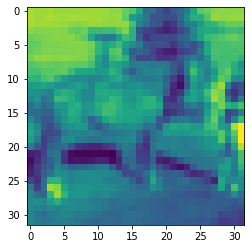

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.1216,  0.1059, -1.0000],
        [-0.1294, -0.1294, -0.1373,  ...,  0.1451,  0.1216, -1.0000],
        [-0.1059, -0.1059, -0.0980,  ...,  0.1529,  0.1451, -1.0000],
        ...,
        [-1.0000, -0.8196, -0.7569,  ..., -0.7412, -0.6471, -0.6549],
        [-1.0000, -0.7961, -0.7255,  ..., -0.8118, -0.8118, -0.7804],
        [-1.0000, -0.8588, -0.7020,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 2.6486, -1.0868,  0.7113, -0.4424, -0.6456, -1.7207, -2.1727, -2.4105,
         4.5629, -0.1723], grad_fn=<SelectBackward0>)


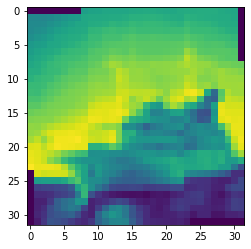

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.6881,  2.8016, -0.2662, -0.3358, -1.1947, -2.1143, -1.4363, -2.0554,
         1.9687,  1.9220], grad_fn=<SelectBackward0>)


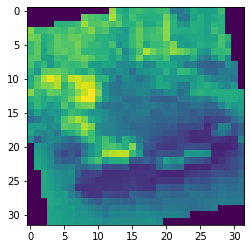

tensor([[-0.2784, -0.2863, -0.2314,  ...,  0.0353,  0.0118,  0.0118],
        [-0.2941, -0.3020, -0.2235,  ...,  0.0431,  0.0431,  0.0118],
        [-0.3176, -0.3412, -0.2471,  ...,  0.0118, -0.0039, -0.0196],
        ...,
        [-0.1765, -0.1451, -0.1216,  ..., -0.0824, -0.0902, -0.0275],
        [-0.1216, -0.1216, -0.0667,  ..., -0.0588, -0.0902, -0.0353],
        [-0.0745, -0.0588, -0.0039,  ..., -0.0980, -0.1216, -0.0588]]) tensor(7)
tensor([-0.3792, -2.0439,  0.4919,  1.1443,  2.6497,  1.3502, -1.3325,  2.2767,
        -2.6637, -1.9585], grad_fn=<SelectBackward0>)


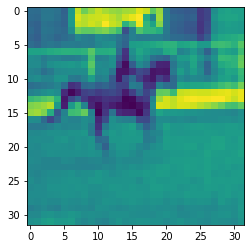

tensor([[ 0.8824,  0.9608,  0.9922,  ..., -0.5765, -0.3961, -0.2078],
        [ 0.8667,  0.9608,  0.9765,  ...,  0.1216,  0.0039, -0.1529],
        [ 0.8824,  0.9765,  0.9843,  ..., -0.1373, -0.1686,  0.1922],
        ...,
        [ 0.4824,  0.2471,  0.5922,  ..., -0.5451, -0.4824, -0.4039],
        [ 0.5216,  0.2863,  0.4667,  ..., -0.3333, -0.3412, -0.3412],
        [ 0.5294,  0.4431,  0.7490,  ..., -0.2941, -0.2784, -0.2392]]) tensor(5)
tensor([-0.0969, -2.0188, -0.3689,  2.0313,  0.8984,  1.3453, -2.5421,  2.0184,
        -2.0829,  1.3569], grad_fn=<SelectBackward0>)


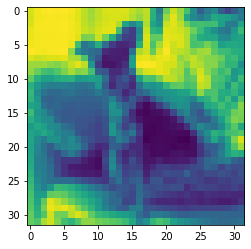

tensor([[-1.0000, -1.0000, -0.5294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.4902,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.4196,  ..., -0.0824,  0.0667,  0.0745],
        ...,
        [-0.1294, -0.1451, -0.1529,  ..., -0.0824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1137, -1.0000, -1.0000]]) tensor(3)
tensor([-0.2603, -3.2679,  1.9414,  4.2789,  0.7400,  4.4895, -1.2338,  0.0114,
        -3.2259, -3.7175], grad_fn=<SelectBackward0>)


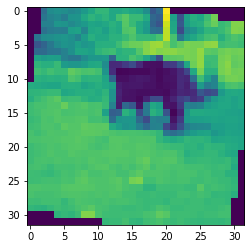

tensor([[-1.0000,  0.0118, -0.0118,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0980, -0.0431,  ..., -0.0902, -0.0588, -0.0353],
        [-1.0000, -0.1922, -0.2078,  ...,  0.0039, -0.0588, -0.0039],
        ...,
        [-0.1765, -0.1529, -0.1451,  ...,  0.0667,  0.0588, -1.0000],
        [-0.1843, -0.1686, -0.1529,  ..., -0.0510,  0.0275, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1373, -0.0824, -1.0000]]) tensor(0)
tensor([ 2.2249,  0.9830, -1.2305, -0.9212,  0.3022, -0.7580, -1.8039,  1.1719,
        -2.0514,  1.9792], grad_fn=<SelectBackward0>)


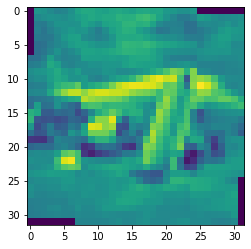

tensor([[-1.0000, -1.0000, -0.8353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.9608,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8667,  ..., -0.2784, -0.3490, -0.8275],
        ...,
        [ 0.9451,  0.9373,  0.9451,  ...,  0.0745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0667, -1.0000, -1.0000]]) tensor(7)
tensor([-0.3118, -0.6369,  0.0926,  1.4660,  3.0080,  1.0777, -4.0704,  3.4703,
        -1.9995, -1.5501], grad_fn=<SelectBackward0>)


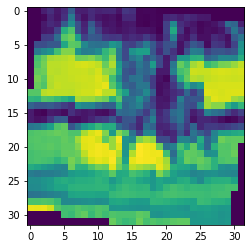

tensor([[-1.0000,  0.4745,  0.5294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5608,  0.4980,  ...,  0.4824,  0.4902,  0.2706],
        [-1.0000,  0.4510,  0.1373,  ...,  0.3647,  0.4353,  0.3255],
        ...,
        [ 0.1294,  0.1765,  0.2392,  ...,  0.0667,  0.0118, -1.0000],
        [ 0.1137,  0.1294,  0.1765,  ..., -0.0039, -0.0275, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0745, -0.0745, -1.0000]]) tensor(8)
tensor([-0.9361, -0.6753,  0.6116,  0.6287, -0.3007, -0.5847, -0.1684, -0.1817,
         0.9529,  0.5643], grad_fn=<SelectBackward0>)


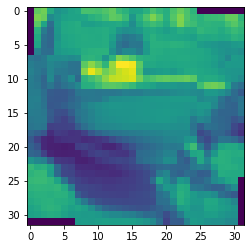

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.2084, -1.9876,  0.0292,  0.5136,  1.2610,  1.1680, -1.6819,  3.2701,
        -2.0159, -0.4072], grad_fn=<SelectBackward0>)


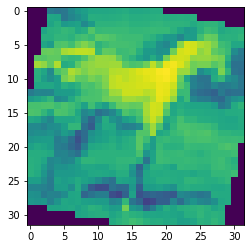

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.6956, -1.7409,  1.0893,  1.4287, -0.6808, -0.7406, -4.1165,  0.0883,
         2.6455, -0.7367], grad_fn=<SelectBackward0>)


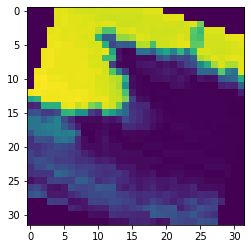

tensor([[-1.0000,  0.5686,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5686,  0.5765,  ...,  0.6000,  0.5529,  0.5294],
        [-1.0000,  0.5843,  0.5922,  ...,  0.5608,  0.5294,  0.5137],
        ...,
        [ 0.0745,  0.0431,  0.0353,  ..., -0.4588, -0.3255, -1.0000],
        [ 0.0745,  0.0588,  0.0588,  ..., -0.3412, -0.2706, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0980, -0.0980, -1.0000]]) tensor(8)
tensor([ 2.3253,  2.8113, -2.2313, -1.0622, -1.6482, -2.9392, -4.6408, -2.4054,
         5.6527,  3.6878], grad_fn=<SelectBackward0>)


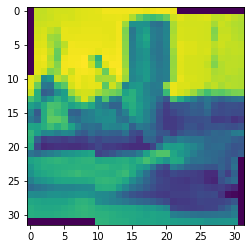

tensor([[0.9216, 0.9451, 0.9451,  ..., 0.9137, 0.9059, 0.9451],
        [0.9451, 0.9686, 0.9529,  ..., 0.9373, 0.9294, 0.9686],
        [0.9451, 0.9765, 0.9451,  ..., 0.9294, 0.9294, 0.9608],
        ...,
        [0.9451, 0.9843, 0.9922,  ..., 0.9137, 0.9137, 0.9451],
        [0.9373, 0.9686, 0.9922,  ..., 0.9137, 0.9137, 0.9451],
        [0.9216, 0.9529, 0.9843,  ..., 0.9059, 0.9059, 0.9451]]) tensor(0)
tensor([ 5.6179, -0.5135,  3.4394, -0.4821,  1.2037, -2.8039, -3.6205, -2.7743,
         0.1324, -1.7621], grad_fn=<SelectBackward0>)


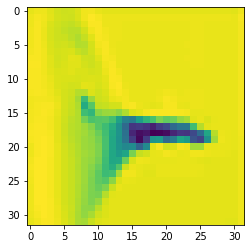

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6549, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6392, -1.0000, -1.0000],
        [-0.7020, -0.7020, -0.6863,  ..., -0.6549, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.6549,  ..., -0.3333, -0.3412, -0.4275],
        [-1.0000, -1.0000, -0.6549,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6941,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.4296, -1.9228,  0.5956,  2.6952,  1.7771,  0.8787,  3.7999, -0.9499,
        -2.3245, -3.2015], grad_fn=<SelectBackward0>)


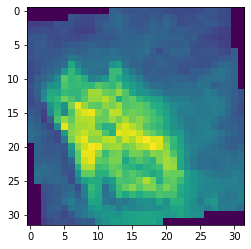

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8510,  ...,  0.8510, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4118,  ..., -0.3804, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.7419,  0.2774, -0.4254,  0.7068,  0.4765, -0.1711, -1.3470,  0.0629,
        -0.3132,  0.0482], grad_fn=<SelectBackward0>)


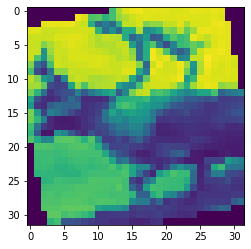

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 5.2219, -1.7249,  1.6582, -0.5666,  1.5281, -1.3010, -0.8656, -2.6777,
         1.4381, -3.5584], grad_fn=<SelectBackward0>)


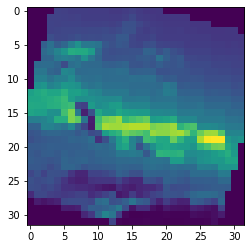

tensor([[-0.6863, -0.6706, -0.6784,  ..., -0.5216, -0.6000, -0.6784],
        [-0.6863, -0.6627, -0.6706,  ...,  0.3255, -0.1529, -0.6314],
        [-0.6549, -0.6392, -0.6157,  ...,  0.3569,  0.0745, -0.5922],
        ...,
        [ 0.0431,  0.0824, -0.0039,  ...,  0.7098,  0.4275, -0.1216],
        [ 0.2000,  0.1686,  0.0118,  ...,  0.6941,  0.5922,  0.0824],
        [ 0.0824, -0.0039, -0.0745,  ...,  0.7490,  0.6863,  0.3647]]) tensor(0)
tensor([ 8.4842e-01, -3.0331e+00,  6.9907e-01,  1.1954e+00,  2.0173e-04,
         1.3998e+00, -2.8074e-01, -8.0689e-01,  1.0407e+00, -1.2316e+00],
       grad_fn=<SelectBackward0>)


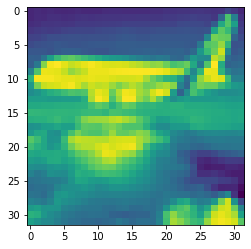

tensor([[0.9451, 0.9529, 0.9529,  ..., 0.9608, 0.9608, 0.9608],
        [0.9451, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9608],
        [0.9451, 0.9529, 0.9608,  ..., 0.9451, 0.9529, 0.9608],
        ...,
        [0.7255, 0.7176, 0.7333,  ..., 0.8588, 0.8745, 0.8980],
        [0.8431, 0.8196, 0.8118,  ..., 0.7804, 0.8196, 0.8510],
        [0.8588, 0.8588, 0.8667,  ..., 0.8039, 0.8196, 0.8353]]) tensor(0)
tensor([ 4.7826,  1.7948, -0.4998, -1.2308, -0.6293, -3.9960, -2.2823, -3.4892,
         2.0803,  2.6112], grad_fn=<SelectBackward0>)


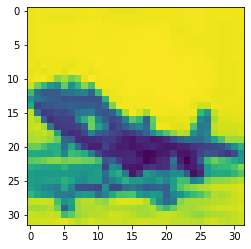

tensor([[-1.0000, -1.0000,  0.0980,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0980,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0980,  ...,  0.0824,  0.0667,  0.0588],
        ...,
        [-0.5137, -0.7020, -0.7804,  ..., -0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5216, -1.0000, -1.0000]]) tensor(0)
tensor([ 4.3620, -0.4336,  2.9743, -1.7768,  1.5546, -2.5160, -2.4500, -1.6216,
         0.3615, -1.0015], grad_fn=<SelectBackward0>)


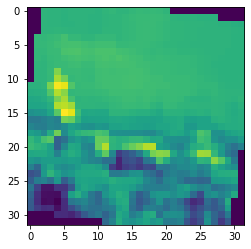

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0745, -1.0000, -1.0000],
        [-0.0588, -0.0588, -0.0588,  ..., -0.0745, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0118,  ..., -0.0196, -0.0196, -0.0196],
        [-1.0000, -1.0000, -0.0039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0039,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 6.0203, -3.3636,  2.9691,  0.3195,  1.8334, -0.3447, -2.1773, -1.4625,
        -0.0161, -4.4483], grad_fn=<SelectBackward0>)


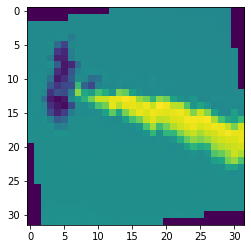

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 2.4187,  1.7000, -1.3960, -1.1593,  0.5210, -1.2458, -4.9598,  1.2275,
        -1.0716,  4.4336], grad_fn=<SelectBackward0>)


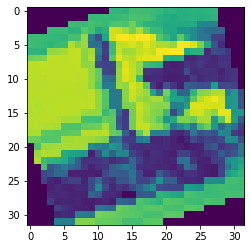

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.8118, -0.7569, -1.0000],
        [ 0.2235,  0.2549,  0.2706,  ..., -0.4902, -0.5843, -1.0000],
        [ 0.2314,  0.2627,  0.2863,  ..., -0.4275, -0.4588, -1.0000],
        ...,
        [-1.0000, -0.3490, -0.2471,  ...,  0.3255,  0.2235,  0.1843],
        [-1.0000, -0.3333, -0.3490,  ...,  0.4431,  0.4275,  0.3098],
        [-1.0000, -0.3725, -0.3647,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-0.0349,  3.0406, -0.6695, -1.1475, -0.2451, -1.3228, -1.3519,  0.3636,
        -1.4817,  3.4995], grad_fn=<SelectBackward0>)


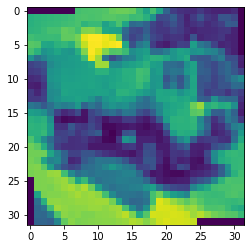

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5843, -1.0000, -1.0000],
        [ 0.7725,  0.7490,  0.7333,  ...,  0.5686, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0275,  ..., -0.0824, -0.0667, -0.0745],
        [-1.0000, -1.0000,  0.0353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0118,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.8942,  0.8327, -0.6664, -1.0808,  0.0763, -2.3536, -2.4342, -0.9730,
         1.5457,  3.4936], grad_fn=<SelectBackward0>)


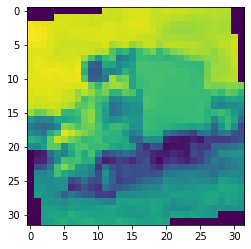

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([-1.5046, -0.6937, -0.1432,  0.5258,  0.9161, -0.3630,  1.5681,  0.1427,
        -0.6482,  0.6042], grad_fn=<SelectBackward0>)


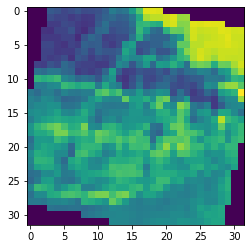

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000],
        [ 0.0039,  0.0039, -0.0118,  ..., -0.0275, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1686,  ..., -0.5922, -0.4980, -0.4118],
        [-1.0000, -1.0000,  0.0275,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3961,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 5.1410,  1.1349,  0.9379, -1.8489, -0.4298, -4.0719, -2.8450, -4.3925,
         6.0617, -1.0788], grad_fn=<SelectBackward0>)


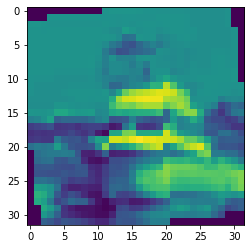

tensor([[-1.0000, -1.0000, -0.9059,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8667,  ...,  0.9373, -1.0000, -1.0000],
        [-1.0000, -0.8275, -0.6392,  ...,  0.7176,  0.9608,  0.7961],
        ...,
        [ 0.0588,  0.0745,  0.1529,  ..., -0.4667, -0.7098, -1.0000],
        [-1.0000, -1.0000,  0.1137,  ..., -0.2627, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3961, -1.0000, -1.0000]]) tensor(5)
tensor([-0.2073, -2.5602,  0.7597,  1.2957, -0.1797,  0.8416, -0.8758,  0.0059,
         1.7117, -1.0283], grad_fn=<SelectBackward0>)


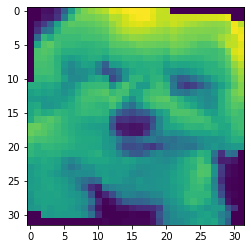

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3725, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2314, -1.0000, -1.0000],
        [-0.6706, -0.6706, -0.6863,  ..., -0.1765, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.5529,  ...,  0.2392,  0.2000,  0.1059],
        [-1.0000, -1.0000, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6314,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.1735,  0.4224,  2.4320, -1.2246,  1.5167, -0.9643, -0.5310, -0.5154,
        -1.3091, -0.5203], grad_fn=<SelectBackward0>)


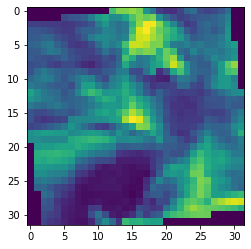

tensor([[-1.,  1.,  1.,  ..., -1., -1., -1.],
        [-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1., -1.],
        [ 1.,  1.,  1.,  ...,  1.,  1., -1.],
        [-1., -1., -1.,  ...,  1.,  1., -1.]]) tensor(1)
tensor([ 1.1606,  5.6899, -2.4394, -0.2115, -3.1506, -3.9994, -0.1582, -5.1295,
         2.3560,  5.0619], grad_fn=<SelectBackward0>)


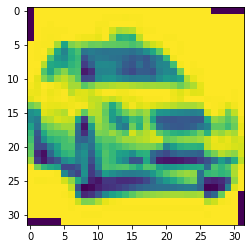

tensor([[-1.0000,  0.5373,  0.3961,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5451,  0.5216,  ..., -0.0824, -0.0824, -0.0431],
        [-1.0000,  0.5451,  0.5294,  ...,  0.1294,  0.0980,  0.0980],
        ...,
        [ 0.3333,  0.3020,  0.3412,  ...,  0.3882,  0.3569, -1.0000],
        [ 0.3020,  0.3176,  0.3176,  ...,  0.4118,  0.3569, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4824,  0.3725, -1.0000]]) tensor(2)
tensor([-0.5397, -1.9240,  2.0597,  1.1121,  2.4419,  1.3672,  0.2218,  0.9423,
        -3.3462, -2.3399], grad_fn=<SelectBackward0>)


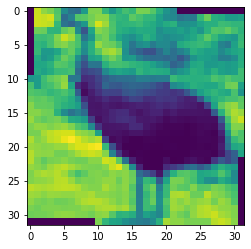

tensor([[ 0.7333,  0.8039,  0.8275,  ...,  0.7333,  0.6784,  0.5608],
        [ 0.8118,  0.8431,  0.8275,  ...,  0.7647,  0.7412,  0.6863],
        [ 0.8353,  0.8431,  0.8431,  ...,  0.7098,  0.6863,  0.7098],
        ...,
        [-0.0353, -0.0118,  0.0118,  ..., -0.9529, -0.0353,  0.6627],
        [-0.0510, -0.0118,  0.0118,  ..., -0.9686, -0.0196,  0.6471],
        [-0.0824, -0.0431, -0.0196,  ..., -0.9922,  0.0039,  0.5608]]) tensor(3)
tensor([-0.5085, -0.6664, -1.0621,  1.9740, -0.0811,  1.3944, -2.5921,  2.9680,
        -2.0256,  0.5676], grad_fn=<SelectBackward0>)


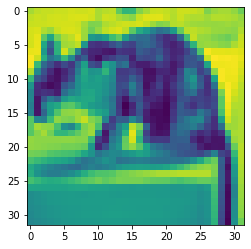

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-1.2562, -3.0919,  1.6298,  1.3916,  4.1600,  1.3698,  1.2592,  1.3324,
        -3.8551, -3.8198], grad_fn=<SelectBackward0>)


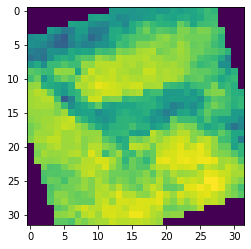

tensor([[-0.9765, -0.9765, -0.9765,  ..., -0.9922, -0.9922, -0.9922],
        [-0.9765, -0.9765, -0.9843,  ..., -0.9922, -0.9922, -1.0000],
        [-0.9843, -0.9922, -0.9922,  ..., -0.9922, -1.0000, -1.0000],
        ...,
        [-0.9765, -0.9765, -0.9686,  ..., -0.9843, -0.9843, -0.9451],
        [-0.9608, -0.9608, -0.9686,  ..., -0.9922, -0.9922, -0.9765],
        [-0.9765, -0.9765, -0.9843,  ..., -0.9608, -0.9686, -0.9765]]) tensor(8)
tensor([ 3.4716, -1.4088, -0.4877, -0.3996, -0.5005, -1.2633, -2.9187, -3.6899,
         8.3724, -2.2263], grad_fn=<SelectBackward0>)


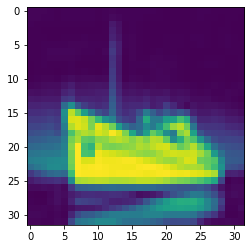

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-2.6310, -3.2578, -0.1540,  2.6104,  2.0081,  2.9562,  0.1983,  4.3122,
        -4.5858, -1.5161], grad_fn=<SelectBackward0>)


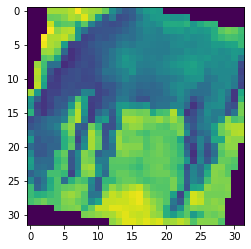

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0196, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3255, -1.0000, -1.0000],
        [-0.3412, -0.4902, -0.4196,  ..., -0.2941, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0902,  ...,  0.1922,  0.1137,  0.0824],
        [-1.0000, -1.0000, -0.0902,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-1.7868,  1.4440, -1.0806,  0.9071, -0.1515, -0.3251,  2.5718, -1.1315,
        -1.4801,  1.7409], grad_fn=<SelectBackward0>)


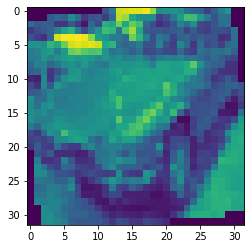

tensor([[-0.7412, -0.7569, -0.7255,  ..., -0.7333, -0.6314, -0.5765],
        [-0.7255, -0.7333, -0.7333,  ..., -0.7255, -0.6000, -0.5451],
        [-0.6706, -0.6941, -0.7333,  ..., -0.6941, -0.6157, -0.6157],
        ...,
        [ 0.0902,  0.0588, -0.2000,  ..., -0.0039,  0.0980, -0.0353],
        [ 0.0196,  0.2078,  0.0039,  ..., -0.1059, -0.0745, -0.1216],
        [ 0.1529,  0.3255,  0.1765,  ..., -0.1922, -0.0745, -0.0902]]) tensor(6)
tensor([-3.5998, -3.0728,  1.7054,  2.1240,  4.2149,  0.9062,  4.8923,  0.0253,
        -4.0015, -3.4455], grad_fn=<SelectBackward0>)


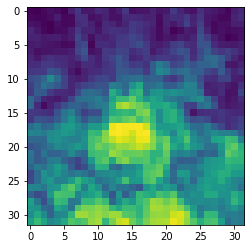

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([ 0.0965, -2.2112,  1.3289,  0.9262,  2.3112,  0.4658,  0.3725, -0.1740,
        -1.2710, -2.2888], grad_fn=<SelectBackward0>)


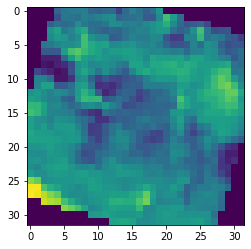

tensor([[-1.0000, -1.0000, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3176,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3176,  ..., -0.1059, -0.1137, -0.1294],
        ...,
        [-0.6000, -0.6000, -0.6000,  ..., -0.5059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4745, -1.0000, -1.0000]]) tensor(8)
tensor([ 3.1188, -1.6266,  2.1295, -0.7923,  1.0425, -2.8405, -0.2621, -3.0624,
         2.8667, -1.7619], grad_fn=<SelectBackward0>)


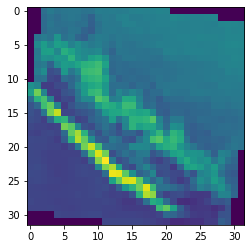

tensor([[-1.0000,  0.6471,  0.7412,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.6392,  0.7255,  ...,  0.6706,  0.6784,  0.6549],
        [-1.0000,  0.6549,  0.7333,  ...,  0.6784,  0.6706,  0.6627],
        ...,
        [ 0.1294,  0.1216,  0.0353,  ...,  0.0510,  0.0902, -1.0000],
        [ 0.1451,  0.1451,  0.0980,  ...,  0.0510,  0.0824, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1059,  0.1373, -1.0000]]) tensor(8)
tensor([ 2.2707, -0.9094,  0.2314, -0.4078,  0.1432, -1.9920, -3.0491, -1.6961,
         3.7137,  0.9155], grad_fn=<SelectBackward0>)


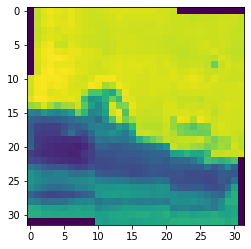

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3176, -0.3725, -1.0000],
        [ 0.9451,  0.8588,  0.2941,  ..., -0.3569, -0.4353, -1.0000],
        [ 0.8745,  0.7725,  0.6157,  ..., -0.3961, -0.4667, -1.0000],
        ...,
        [-1.0000,  0.5922,  0.5686,  ...,  0.1843,  0.1451,  0.1608],
        [-1.0000,  0.6314,  0.5686,  ...,  0.1608,  0.2000,  0.0902],
        [-1.0000,  0.6314,  0.6078,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.2496,  3.6826, -0.6118, -1.0392, -0.9814, -3.2585,  1.2434, -3.7538,
         0.1984,  2.9459], grad_fn=<SelectBackward0>)


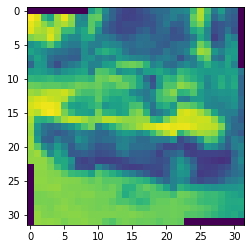

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.0539, -1.7194,  0.2072,  0.7591,  1.1051,  1.0872,  0.5394,  1.2002,
        -1.8483, -0.2001], grad_fn=<SelectBackward0>)


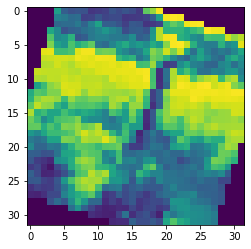

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 1.2931,  2.4159, -0.1211, -1.2965, -0.8279, -2.4103, -0.6591, -2.0846,
         2.4378,  1.0216], grad_fn=<SelectBackward0>)


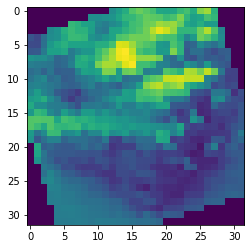

tensor([[-0.7412, -0.6941, -0.7333,  ..., -0.6314, -0.5451, -0.5922],
        [-0.7098, -0.6863, -0.5137,  ..., -0.5843, -0.5686, -0.6235],
        [-0.5529, -0.5529, -0.6627,  ..., -0.4745, -0.5529, -0.5216],
        ...,
        [-0.5373, -0.4118, -0.5137,  ..., -0.2549, -0.3569, -0.2863],
        [-0.5294, -0.7098, -0.3020,  ..., -0.2863, -0.3176, -0.4667],
        [-0.3725, -0.3961, -0.4275,  ..., -0.4196, -0.4510, -0.3961]]) tensor(4)
tensor([-2.0845, -2.4076,  0.9210,  0.1302,  3.7306,  0.8156,  3.0578,  1.2411,
        -4.1111, -1.9392], grad_fn=<SelectBackward0>)


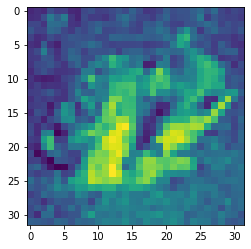

tensor([[-1.0000,  0.3961,  0.4510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.4275,  0.4667,  ...,  0.6471,  0.6627,  0.5765],
        [-1.0000,  0.4353,  0.4980,  ...,  0.6471,  0.6549,  0.5843],
        ...,
        [ 0.0196,  0.0588,  0.0667,  ...,  0.6706,  0.5922, -1.0000],
        [ 0.0510,  0.0824,  0.0745,  ...,  0.6706,  0.5765, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6235,  0.5608, -1.0000]]) tensor(3)
tensor([ 0.9664, -5.6569,  3.6724,  1.5554,  1.9398,  1.8912, -0.9953,  0.5717,
        -1.1898, -3.9584], grad_fn=<SelectBackward0>)


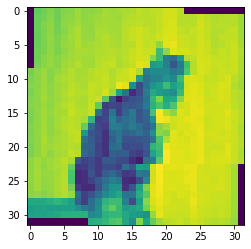

tensor([[-0.0353, -0.0275, -0.0118,  ..., -0.0039, -0.0118, -0.0353],
        [-0.0118, -0.0039,  0.0039,  ...,  0.0196,  0.0039, -0.0118],
        [-0.0118, -0.0118, -0.0039,  ...,  0.0118, -0.0039, -0.0118],
        ...,
        [-0.3647, -0.3725, -0.3961,  ..., -0.3333, -0.3412, -0.3569],
        [-0.3490, -0.3569, -0.3804,  ..., -0.2941, -0.3333, -0.3255],
        [-0.1451, -0.1529, -0.1529,  ..., -0.2627, -0.3333, -0.3176]]) tensor(0)
tensor([ 4.3512,  0.2933,  1.7189, -1.7588,  0.4664, -3.5756, -2.4998, -3.1607,
         3.0357, -0.2543], grad_fn=<SelectBackward0>)


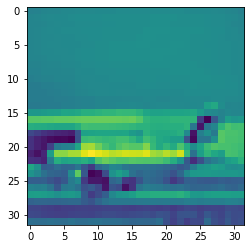

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 3.0835,  4.6813, -1.4155, -2.5084, -1.7939, -4.2917, -3.3131, -1.6616,
         3.1846,  3.3839], grad_fn=<SelectBackward0>)


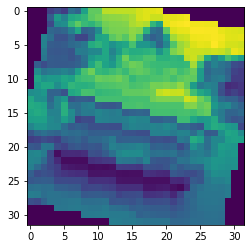

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 0.0619, -4.3133,  1.9706,  1.5602,  1.4326,  0.6069,  2.6681, -1.4770,
        -0.1933, -2.8009], grad_fn=<SelectBackward0>)


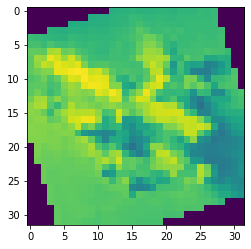

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2314, -0.2314, -1.0000],
        [ 0.1451,  0.1765,  0.0353,  ..., -0.1765, -0.1608, -1.0000],
        [ 0.2392,  0.3725,  0.1451,  ..., -0.0902,  0.0196, -1.0000],
        ...,
        [-1.0000,  0.3020,  0.0745,  ...,  0.2941,  0.3490,  0.2549],
        [-1.0000,  0.1686, -0.1608,  ...,  0.0902,  0.0431,  0.0039],
        [-1.0000,  0.1843, -0.0745,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.1965, -2.0873,  1.7384,  0.5265,  2.5321,  0.5265, -0.4291, -0.2070,
        -1.6318, -1.3265], grad_fn=<SelectBackward0>)


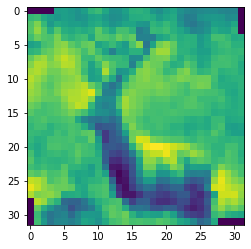

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0667,  ...,  0.1137, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.5529,  ...,  0.1216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.6159,  3.7282, -1.0525, -0.1451,  0.1411, -1.0000, -1.8316, -0.1660,
        -1.8971,  3.1521], grad_fn=<SelectBackward0>)


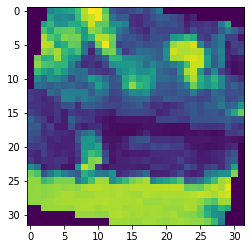

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0039,  0.0353, -1.0000],
        [ 0.7804,  0.7804,  0.7882,  ..., -0.0039,  0.0745, -1.0000],
        [ 0.7490,  0.7569,  0.7569,  ..., -0.0745, -0.0039, -1.0000],
        ...,
        [-1.0000, -0.2549, -0.3333,  ..., -0.4431, -0.4588, -0.4588],
        [-1.0000, -0.2392, -0.2863,  ..., -0.4118, -0.3804, -0.3725],
        [-1.0000, -0.2157, -0.2392,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.8916,  3.0113, -0.5419,  0.0812, -2.7818, -1.7948, -1.8405, -1.9980,
         1.6535,  2.3982], grad_fn=<SelectBackward0>)


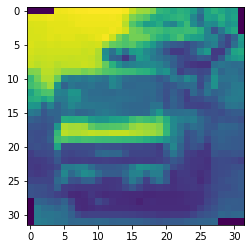

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.7333, -0.6392, -1.0000],
        [-0.4588, -0.3961, -0.1922,  ..., -0.7333, -0.6784, -1.0000],
        [-0.5216, -0.4275, -0.2863,  ..., -0.7176, -0.6784, -1.0000],
        ...,
        [-1.0000, -0.0510, -0.1059,  ..., -0.2549, -0.2392, -0.0980],
        [-1.0000, -0.1373, -0.1451,  ..., -0.0824, -0.1529, -0.1137],
        [-1.0000, -0.1373, -0.1216,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.4007, -0.3621,  1.7971,  0.8889,  2.2386,  0.6776, -0.3348,  1.2885,
        -2.9904, -1.3348], grad_fn=<SelectBackward0>)


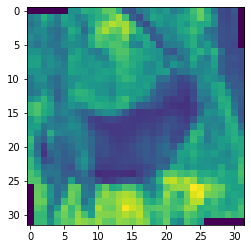

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6235, -0.5843, -1.0000],
        [-0.2941, -0.2314, -0.2235,  ..., -0.6863, -0.6078, -1.0000],
        [-0.5059, -0.4745, -0.4588,  ..., -0.5686, -0.5216, -1.0000],
        ...,
        [-1.0000,  0.0353,  0.0118,  ...,  0.2078,  0.2157,  0.1608],
        [-1.0000,  0.2078,  0.1686,  ...,  0.2235,  0.2235,  0.2471],
        [-1.0000,  0.2863,  0.2392,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.0070, -3.6239,  1.9309,  2.2169,  2.6984,  3.9030, -5.1465,  5.9559,
        -4.1189, -3.1387], grad_fn=<SelectBackward0>)


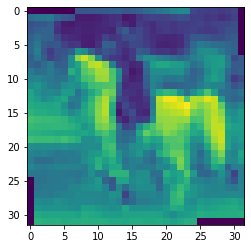

tensor([[-1.0000, -0.0510, -0.0196,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0196, -0.0510,  ...,  0.0118,  0.0118, -0.0039],
        [-1.0000,  0.0275,  0.0510,  ..., -0.1451, -0.1137, -0.0824],
        ...,
        [-0.2941, -0.2549, -0.2627,  ..., -0.2392, -0.2000, -1.0000],
        [-0.3333, -0.2863, -0.2863,  ..., -0.3020, -0.2314, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -0.2078, -1.0000]]) tensor(5)
tensor([-1.4833, -4.1643,  3.2683,  0.8299,  3.6069,  2.1121,  2.9666,  1.6068,
        -5.8949, -3.1784], grad_fn=<SelectBackward0>)


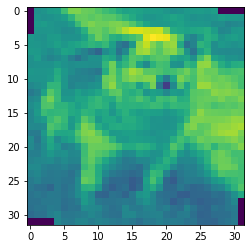

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6706,  ..., -0.5451, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.7255,  ...,  0.1686, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-2.2449, -1.7845,  0.8028,  1.7276,  2.1335,  0.1498,  4.0730, -0.3292,
        -2.7714, -1.4360], grad_fn=<SelectBackward0>)


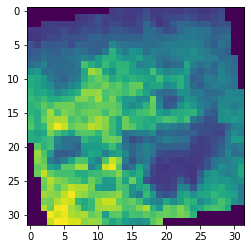

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1216,  ..., -0.9451, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1765,  ..., -0.9529, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([ 0.0447, -6.0375,  4.2971,  2.2733,  1.5195,  2.0210, -1.8842,  1.2026,
        -1.8089, -2.3910], grad_fn=<SelectBackward0>)


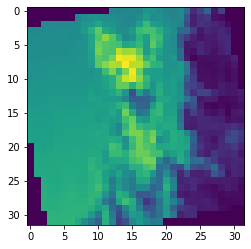

tensor([[-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000, -1.0000],
        [ 0.9765,  0.9765,  0.9765,  ...,  0.9765,  0.9922, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9922, -1.0000],
        ...,
        [-1.0000,  0.0118, -0.0431,  ...,  0.0902,  0.1137,  0.1059],
        [-1.0000,  0.0118, -0.0196,  ...,  0.0980,  0.1216,  0.1216],
        [-1.0000,  0.0118,  0.0118,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-0.3953,  1.2926, -0.5070, -0.1516, -1.0280, -0.6540, -1.6461,  0.3025,
        -0.5405,  4.0295], grad_fn=<SelectBackward0>)


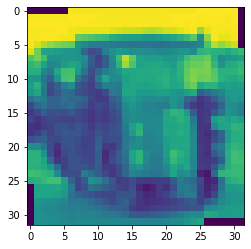

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.5059,  ...,  0.3804, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0275,  ...,  0.0353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-1.0221, -2.7229,  1.8377,  1.6930,  2.1068,  1.2226,  0.3119,  1.0229,
        -2.0051, -2.5237], grad_fn=<SelectBackward0>)


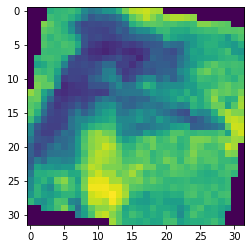

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 5.0051,  1.2103,  1.0607, -0.5245,  0.9370, -2.7528, -1.9199, -2.8374,
        -0.7611, -0.3919], grad_fn=<SelectBackward0>)


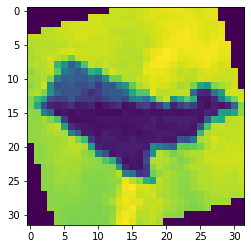

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.6243, -2.6561,  1.1079,  0.9225,  2.7212,  1.5767, -0.3386,  0.9364,
        -2.8356, -1.4578], grad_fn=<SelectBackward0>)


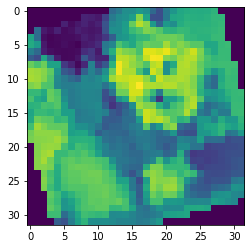

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 5.4675, -2.4466,  2.9715,  0.1148,  1.3518, -0.2212, -3.9702, -0.4458,
        -0.9210, -2.8081], grad_fn=<SelectBackward0>)


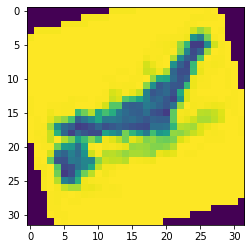

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.1085,  0.0296,  0.5283, -0.1078,  0.8834,  0.6299,  1.6029, -0.3065,
        -2.4298,  0.1855], grad_fn=<SelectBackward0>)


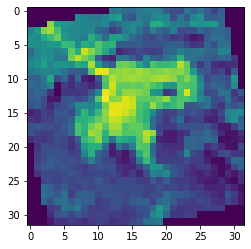

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 2.3123,  1.1344, -0.0975, -1.5170,  0.6052, -2.1243, -2.4978, -0.5092,
         0.6417,  1.7478], grad_fn=<SelectBackward0>)


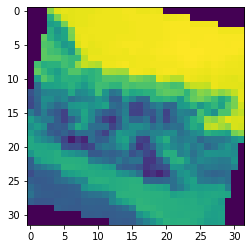

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.1828, -2.5114,  3.2661,  0.1036,  2.6913,  0.2494,  1.7606, -0.2893,
        -2.7331, -2.8098], grad_fn=<SelectBackward0>)


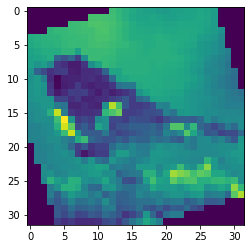

tensor([[-1.0000, -0.5059, -0.8353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.4275, -0.7020,  ..., -0.5843, -0.6235, -0.6941],
        [-1.0000, -0.4039, -0.6863,  ..., -0.6549, -0.6627, -0.7333],
        ...,
        [-0.8039, -0.7804, -0.7647,  ..., -0.7412, -0.3098, -1.0000],
        [-0.7020, -0.6784, -0.6863,  ..., -0.7882, -0.3176, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7961, -0.3176, -1.0000]]) tensor(2)
tensor([ 0.1752, -1.1460,  1.3505,  0.0843,  1.0176,  0.2324,  0.9306, -0.9260,
        -0.3237, -1.6551], grad_fn=<SelectBackward0>)


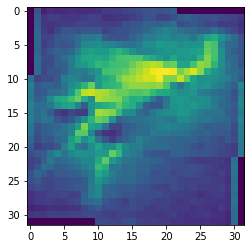

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.7786,  0.2061, -0.0705, -0.7763,  0.9233, -1.8196, -2.4258, -1.1422,
         3.4623, -1.6150], grad_fn=<SelectBackward0>)


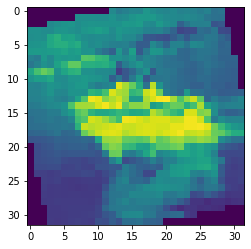

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.5724,  2.6011, -1.8595, -0.7139, -0.7758, -0.9286, -1.3443,  0.9176,
        -2.8338,  5.1591], grad_fn=<SelectBackward0>)


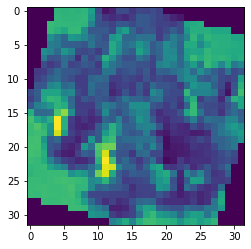

tensor([[-1.0000, -0.1294, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0431, -0.0667,  ...,  0.3098,  0.1216, -0.2784],
        [-1.0000, -0.0745, -0.1137,  ...,  0.5059,  0.5294,  0.1686],
        ...,
        [-0.3020, -0.3098, -0.0275,  ...,  0.4431,  0.6863, -1.0000],
        [-0.2784, -0.2941, -0.1294,  ..., -0.4275, -0.0196, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7255, -0.6157, -1.0000]]) tensor(2)
tensor([-0.3910, -1.7182,  1.8339,  1.6595, -0.0597,  0.7535, -0.2904, -0.9212,
        -0.6537, -0.6227], grad_fn=<SelectBackward0>)


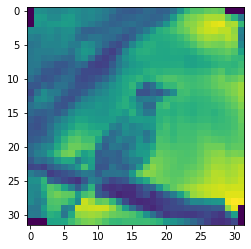

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.7020,  0.7020, -1.0000],
        [ 0.6706,  0.6863,  0.7020,  ...,  0.7098,  0.7098, -1.0000],
        [ 0.6784,  0.6941,  0.7020,  ...,  0.7255,  0.7098, -1.0000],
        ...,
        [-1.0000,  0.7098,  0.6784,  ...,  0.7020,  0.6941,  0.6784],
        [-1.0000,  0.7098,  0.6784,  ...,  0.7020,  0.6941,  0.6784],
        [-1.0000,  0.7020,  0.6784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.2890,  1.4572, -1.3649,  0.1365,  0.3334, -0.9115,  0.5979, -3.2323,
         0.7541,  1.4187], grad_fn=<SelectBackward0>)


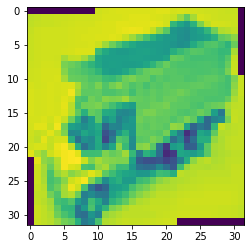

tensor([[-0.8510, -0.8118, -0.7804,  ..., -0.0667, -0.1059, -0.1451],
        [-0.7804, -0.7490, -0.7098,  ..., -0.0353, -0.0745, -0.1137],
        [-0.6078, -0.5608, -0.5137,  ...,  0.0275, -0.0118, -0.0510],
        ...,
        [ 0.2784,  0.2941,  0.3176,  ...,  0.2706,  0.3255,  0.2549],
        [ 0.2471,  0.2706,  0.3098,  ...,  0.2784,  0.3020,  0.2314],
        [ 0.2078,  0.2471,  0.3020,  ...,  0.2471,  0.2863,  0.2078]]) tensor(2)
tensor([ 0.4123, -2.0217,  2.0024,  0.9304,  0.9959,  1.0803, -0.5028,  0.2349,
        -1.7050, -2.0277], grad_fn=<SelectBackward0>)


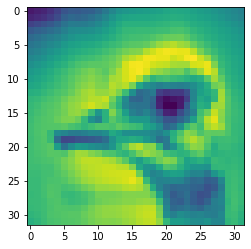

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.9012, -3.2465,  1.0292,  2.2486,  2.0284,  3.1652, -1.8874,  2.7127,
        -2.8199, -2.5161], grad_fn=<SelectBackward0>)


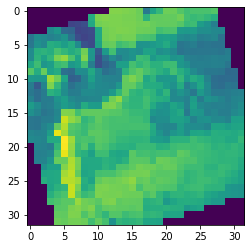

tensor([[-1.0000, -1.0000,  0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.5922,  ...,  0.7882, -1.0000, -1.0000],
        [-1.0000,  0.4824,  0.5765,  ...,  0.8431,  0.7804,  0.7569],
        ...,
        [-0.4353, -0.5608, -0.2627,  ..., -0.1608,  0.1843, -1.0000],
        [-1.0000, -1.0000, -0.4039,  ...,  0.1608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2235, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.3889, -3.1423,  2.1177,  0.6792,  0.6625, -0.7626, -0.0062,  0.3452,
        -0.0361, -0.5392], grad_fn=<SelectBackward0>)


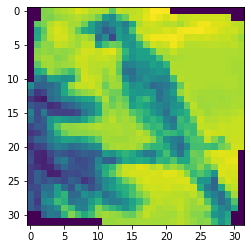

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.1647, -3.4057,  1.1434,  1.9218,  2.4619,  2.1145, -0.8328,  0.4623,
        -0.9084, -2.9452], grad_fn=<SelectBackward0>)


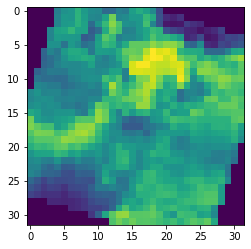

tensor([[-1.0000, -0.1059, -0.0824,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0275, -0.0353,  ..., -0.1216, -0.1137, -0.1059],
        [-1.0000,  0.0039, -0.0275,  ..., -0.1529, -0.1529, -0.1373],
        ...,
        [-0.2549, -0.3255, -0.3333,  ..., -0.2078, -0.2078, -1.0000],
        [-0.2471, -0.3333, -0.3490,  ..., -0.2392, -0.1843, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2706, -0.2078, -1.0000]]) tensor(4)
tensor([-0.7072, -4.5321,  4.5072,  0.4840,  4.6841,  0.8173,  3.2961,  0.6107,
        -5.3107, -4.3912], grad_fn=<SelectBackward0>)


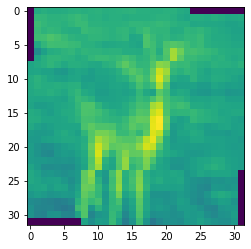

tensor([[-0.3020, -0.9137, -0.9765,  ..., -1.0000, -1.0000, -1.0000],
        [-0.4039, -0.9216, -0.9686,  ..., -0.9922, -0.9922, -0.9922],
        [-0.3961, -0.9294, -0.9765,  ..., -0.9843, -0.9843, -0.9922],
        ...,
        [ 0.2549,  0.7176,  0.7098,  ..., -0.3176, -0.7412, -0.8275],
        [ 0.1765,  0.6627,  0.7020,  ..., -0.2706, -0.8039, -1.0000],
        [ 0.0902,  0.4510,  0.4745,  ..., -0.1059, -0.5294, -0.7333]]) tensor(8)
tensor([ 0.7276, -1.3797,  0.5774,  0.7523, -0.6765,  1.4678, -2.6017,  0.7604,
         1.9892, -1.6787], grad_fn=<SelectBackward0>)


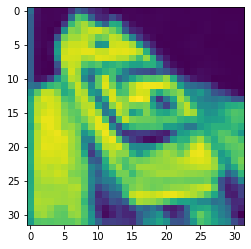

tensor([[-1.0000, -1.0000, -0.1216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3882,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4667,  ..., -0.0588, -0.0118, -0.0588],
        ...,
        [-0.2941, -0.2784, -0.2392,  ..., -0.0118, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1608, -1.0000, -1.0000]]) tensor(7)
tensor([-1.2191, -3.4381,  0.8148,  0.7556,  2.4803,  2.7249, -2.6809,  5.8848,
        -4.6515, -0.8605], grad_fn=<SelectBackward0>)


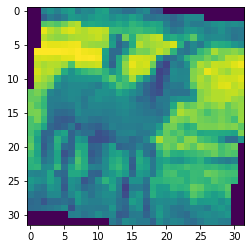

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2627, -1.0000, -1.0000],
        [ 0.2157,  0.2549,  0.2549,  ...,  0.3255, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.8118,  ...,  0.7020,  0.6627,  0.6000],
        [-1.0000, -1.0000,  0.7882,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8039,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.0071, -0.1463,  0.2976,  0.4166, -0.6115, -1.0133, -3.1618,  0.8459,
        -1.1887,  4.2063], grad_fn=<SelectBackward0>)


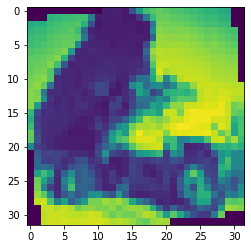

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  1.0000, -1.0000, -1.0000],
        [-1.0000,  1.0000,  1.0000,  ...,  1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  1.0000,  ...,  1.0000,  0.9529, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.7151, -1.0022,  0.3619,  1.3539, -0.6147, -0.6645, -0.9239, -1.7035,
         0.8196,  0.2071], grad_fn=<SelectBackward0>)


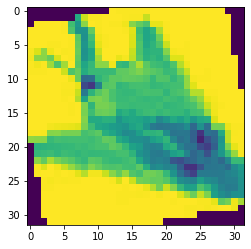

tensor([[ 0.7490,  0.8510,  0.8588,  ...,  0.6706,  0.5373,  0.7098],
        [ 0.8902,  0.9529,  0.8980,  ...,  0.6784,  0.2471,  0.4353],
        [ 0.8667,  0.8745,  0.8118,  ...,  0.7412,  0.0745,  0.2784],
        ...,
        [ 0.3569,  0.0431, -0.0588,  ...,  0.0588, -0.0588,  0.2784],
        [ 0.4039,  0.0353, -0.0196,  ...,  0.0902,  0.1765,  0.5608],
        [ 0.7725,  0.6941,  0.7569,  ...,  0.6314,  0.5765,  0.7647]]) tensor(5)
tensor([-1.1873, -4.1881,  1.6978,  3.4490,  0.0549,  3.7969, -0.4844,  0.6833,
        -3.2844, -1.5808], grad_fn=<SelectBackward0>)


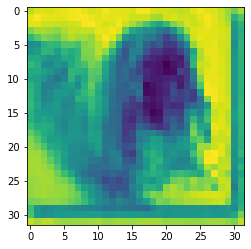

tensor([[-1.0000,  0.3098,  0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3333,  0.5137,  ...,  0.0510,  0.0353,  0.0196],
        [-1.0000,  0.3569,  0.4824,  ...,  0.0275,  0.0353,  0.0196],
        ...,
        [-0.6784, -0.7333, -0.7490,  ..., -0.5843, -0.4980, -1.0000],
        [-0.6941, -0.7412, -0.7647,  ..., -0.5216, -0.4902, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5686, -0.5686, -1.0000]]) tensor(0)
tensor([ 0.8359, -0.4652,  0.4639,  0.2400,  0.3232, -0.3189, -1.7297, -0.7865,
         1.2195,  0.0205], grad_fn=<SelectBackward0>)


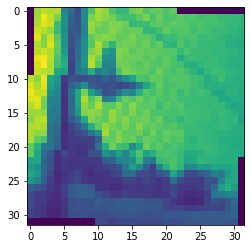

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1529,  ...,  0.1451, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.1686,  ..., -0.8275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-1.8852, -2.6945,  1.0768,  2.3301,  0.6348,  1.1014,  2.9316, -0.8150,
        -1.9685, -0.7934], grad_fn=<SelectBackward0>)


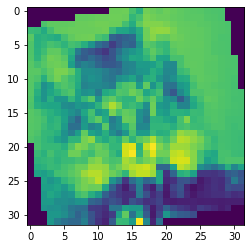

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 1.7740,  2.6655, -1.0704, -1.2152, -0.5684, -3.1705, -2.2383, -1.8084,
         3.7091,  2.2080], grad_fn=<SelectBackward0>)


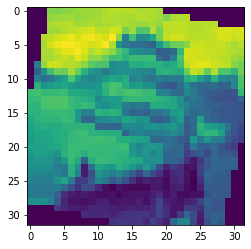

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1843,  0.3647,  0.4510],
        ...,
        [-0.0118,  0.2392,  0.3647,  ...,  0.8431, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.7333, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5451, -1.0000, -1.0000]]) tensor(3)
tensor([-1.5106, -1.8886,  0.8139,  2.0261,  0.6951,  2.2275,  0.0213,  0.7002,
        -1.8484, -1.5966], grad_fn=<SelectBackward0>)


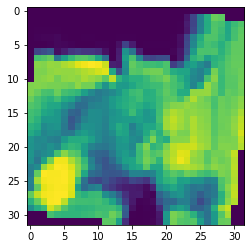

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.1686, -0.2314, -1.0000],
        [-0.0039, -0.0039, -0.0196,  ..., -0.1373, -0.2235, -1.0000],
        [ 0.0431,  0.0431,  0.0196,  ..., -0.0980, -0.1922, -1.0000],
        ...,
        [-1.0000,  0.1765,  0.3098,  ...,  0.0588,  0.0588,  0.0118],
        [-1.0000,  0.1373,  0.3098,  ...,  0.0667,  0.0353, -0.0196],
        [-1.0000,  0.2157,  0.3725,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-0.5894, -3.8629,  2.5922,  1.5886,  2.5652,  2.6233, -0.2118,  1.1796,
        -3.6047, -3.1450], grad_fn=<SelectBackward0>)


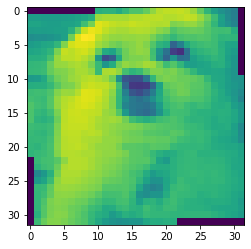

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.1216, -0.1216, -1.0000],
        [ 0.1137,  0.1373,  0.1686,  ..., -0.0824, -0.0902, -1.0000],
        [ 0.1765,  0.2000,  0.2392,  ..., -0.0196, -0.0196, -1.0000],
        ...,
        [-1.0000, -0.3020, -0.3098,  ..., -0.4039, -0.3804, -0.3647],
        [-1.0000, -0.3333, -0.3176,  ..., -0.5294, -0.4510, -0.3961],
        [-1.0000, -0.3333, -0.3333,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 6.1245,  7.5452, -1.0952, -5.4187,  1.3290, -7.2093, -6.5295, -2.9120,
         1.3893,  5.2169], grad_fn=<SelectBackward0>)


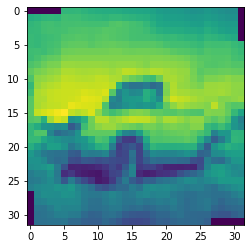

tensor([[-1.0000, -0.8980, -0.9137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.8902, -0.8275,  ..., -0.7647, -0.8510, -0.8745],
        [-1.0000, -0.9451, -0.9216,  ..., -0.6549, -0.7569, -0.7333],
        ...,
        [-0.4824, -0.5529, -0.4431,  ..., -0.5529, -0.6000, -1.0000],
        [-0.6392, -0.5529, -0.4902,  ..., -0.4902, -0.5765, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4745, -0.6078, -1.0000]]) tensor(4)
tensor([-0.8917, -1.3246,  0.6036,  1.5377,  2.7756,  0.7780,  1.2276, -0.1312,
        -1.4405, -3.0496], grad_fn=<SelectBackward0>)


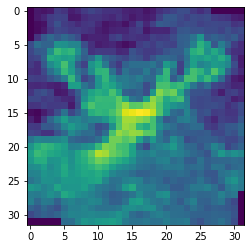

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6627, -0.8275, -1.0000],
        [-0.0667, -0.1765, -0.5137,  ..., -0.4588, -0.4431, -1.0000],
        [-0.1451, -0.3098, -0.5843,  ...,  0.0353, -0.0353, -1.0000],
        ...,
        [-1.0000,  0.2392,  0.2471,  ...,  0.2235,  0.1608,  0.1529],
        [-1.0000,  0.2471,  0.2314,  ...,  0.2314,  0.2078,  0.1922],
        [-1.0000,  0.1373,  0.1294,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.0996, -0.7922, -0.4035,  1.7714,  3.0819,  1.9522, -3.4473,  3.8384,
        -1.9812, -2.5613], grad_fn=<SelectBackward0>)


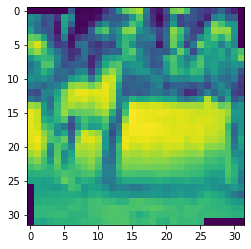

tensor([[ 0.4353,  0.4275,  0.3020,  ...,  0.0510, -0.0902, -0.2471],
        [ 0.8196,  0.7961,  0.6157,  ...,  0.1137, -0.0118, -0.1529],
        [ 0.8431,  0.8902,  0.6706,  ...,  0.1529,  0.0510, -0.0667],
        ...,
        [-0.8196, -0.8353, -0.8275,  ..., -0.3647, -0.5686, -0.5608],
        [-0.8196, -0.8353, -0.8431,  ..., -0.3255, -0.5294, -0.6000],
        [-0.8353, -0.8431, -0.8510,  ..., -0.4118, -0.5137, -0.5137]]) tensor(3)
tensor([-1.8723, -6.8523,  1.0622,  4.4637,  1.1210,  3.7495,  1.2332,  0.1647,
        -0.6372, -2.4792], grad_fn=<SelectBackward0>)


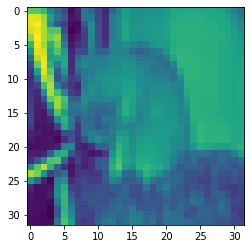

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.8431, -1.0000, -1.0000],
        [-1.0000,  0.6157,  0.4039,  ...,  0.8980, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1608,  ...,  0.8196,  0.8353, -1.0000],
        [-1.0000, -1.0000,  0.2314,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-0.9136,  0.3222, -1.4437,  1.7049, -2.1503, -0.7193,  2.7457, -3.4417,
         1.6517,  2.6139], grad_fn=<SelectBackward0>)


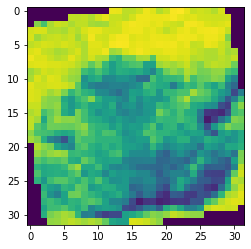

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.7327, -4.8591,  0.7859,  4.4051,  0.1309,  7.1956, -2.7508,  2.4720,
        -1.0183, -4.8234], grad_fn=<SelectBackward0>)


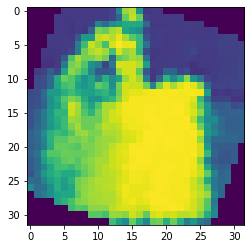

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7569,  ..., -0.7412, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0824,  ..., -0.0431, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.2732, -2.8527,  3.5413,  0.4070,  6.2010, -0.3202,  2.6522,  0.3974,
        -4.3957, -4.7768], grad_fn=<SelectBackward0>)


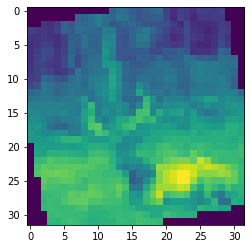

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9608, -0.9608, -1.0000,  ..., -0.9765, -0.9922, -1.0000],
        [-0.9686, -0.9686, -0.9922,  ..., -0.9686, -0.9843, -1.0000],
        ...,
        [-1.0000, -0.8118, -0.9608,  ..., -0.9137, -0.9059, -0.9059],
        [-1.0000, -0.7961, -0.9529,  ..., -0.4902, -0.5059, -0.4824],
        [-1.0000, -0.7961, -0.9137,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 1.8743, -2.2301,  0.9682, -0.3236,  0.6054, -1.0377,  0.3657, -2.7091,
         4.0360, -2.0250], grad_fn=<SelectBackward0>)


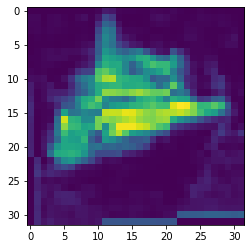

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.9657, -2.4071,  0.7299,  1.5497,  3.0669,  1.5661, -0.1710,  1.4493,
        -2.1594, -1.9969], grad_fn=<SelectBackward0>)


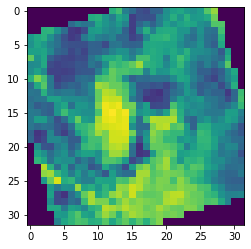

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.3599,  4.6969, -0.5532, -0.5355, -0.7172, -1.0587, -1.6604,  0.0091,
        -2.1040,  2.2830], grad_fn=<SelectBackward0>)


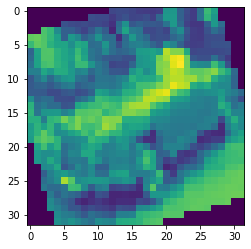

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.6741,  3.2142,  0.4088, -1.0274, -0.8555, -1.8465, -0.7956,  0.3045,
        -2.5468,  2.8381], grad_fn=<SelectBackward0>)


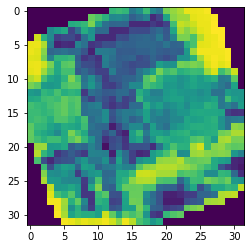

tensor([[-1.0000,  0.9216,  0.9294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9294,  0.9373,  ...,  0.9451,  0.9765,  0.9765],
        [-1.0000,  0.9294,  0.9373,  ...,  0.9216,  0.8745,  0.8196],
        ...,
        [ 0.2706,  0.2235,  0.3882,  ...,  0.3882,  0.3412, -1.0000],
        [ 0.3961,  0.3098,  0.3882,  ...,  0.3804,  0.3804, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1608,  0.1059, -1.0000]]) tensor(9)
tensor([ 2.1793,  1.4227,  0.2386, -1.5655,  0.7265, -2.8172, -3.3701,  1.2833,
        -0.3830,  2.5575], grad_fn=<SelectBackward0>)


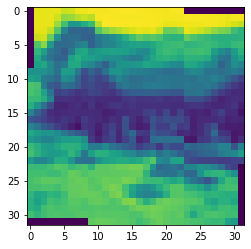

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3961,  0.3725, -1.0000],
        [ 0.6392,  0.7333,  0.7412,  ...,  0.3882,  0.3804, -1.0000],
        [ 0.6627,  0.7647,  0.7882,  ...,  0.4039,  0.3961, -1.0000],
        ...,
        [-1.0000,  0.5059,  0.7490,  ...,  0.3098,  0.2078,  0.2314],
        [-1.0000,  0.5373,  0.7569,  ...,  0.7098,  0.6784,  0.6471],
        [-1.0000,  0.4510,  0.5843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.0532, -3.0855,  2.2305, -0.0908,  1.3343, -0.3273, -2.1901, -0.0168,
         0.5170, -0.5967], grad_fn=<SelectBackward0>)


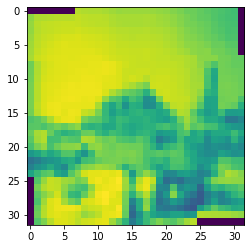

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8275,  ..., -0.2549, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.6471,  ...,  0.1765, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 1.2058, -0.5602,  0.2370, -1.3083,  2.7829, -1.6318, -1.4792, -1.0621,
         1.3556,  0.3742], grad_fn=<SelectBackward0>)


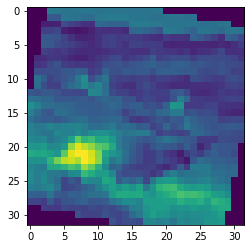

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.1215,  1.5140, -1.0612, -1.0198, -2.0345, -2.2642, -1.4037, -1.0540,
         1.9364,  3.1085], grad_fn=<SelectBackward0>)


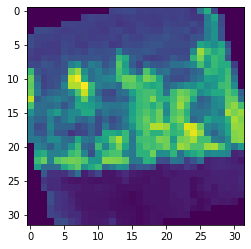

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0431, -1.0000, -1.0000],
        [-0.0745, -0.0745, -0.0745,  ..., -0.0431, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0039,  ...,  0.0667,  0.0588,  0.0588],
        [-1.0000, -1.0000,  0.0039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0039,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 5.6196, -4.4820,  4.3771,  0.3479,  2.4534, -0.0270, -0.4712, -2.4487,
        -1.2090, -5.2284], grad_fn=<SelectBackward0>)


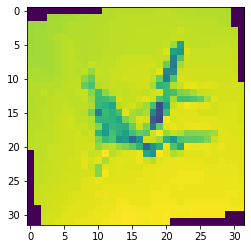

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0667,  0.0588, -1.0000],
        [ 0.4353,  0.3333,  0.3255,  ...,  0.0980,  0.0588, -1.0000],
        [ 0.4353, -0.2314, -0.3098,  ...,  0.0824,  0.1373, -1.0000],
        ...,
        [-1.0000,  0.6392,  0.3882,  ...,  0.1922,  0.0667,  0.6627],
        [-1.0000,  0.3098,  0.0667,  ..., -0.0196,  0.3255,  0.8118],
        [-1.0000,  0.7098,  0.7176,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.3466, -2.6711,  0.8859, -0.4054,  3.4838,  1.2270, -2.2336,  8.4390,
        -5.7418, -2.2644], grad_fn=<SelectBackward0>)


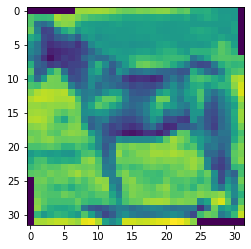

tensor([[-1.0000, -1.0000, -0.8039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6314,  ..., -0.5216, -0.6392, -0.7569],
        ...,
        [-0.7804, -0.8588, -0.8353,  ..., -0.8824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9137, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -1.0000, -1.0000]]) tensor(4)
tensor([-1.7259, -2.3689,  0.9677,  0.7036,  2.4298,  2.0558,  1.7847,  2.2964,
        -4.7834, -1.5929], grad_fn=<SelectBackward0>)


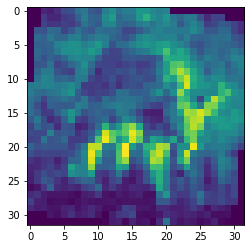

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.9765,  ..., -0.8980, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4667,  ..., -0.5843, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([-0.8977,  2.7379, -0.8991,  0.2963, -0.6254, -1.1023,  0.1143, -0.7412,
         0.5654,  0.1545], grad_fn=<SelectBackward0>)


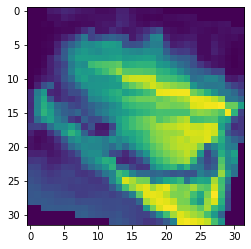

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2863,  ...,  0.0275, -1.0000, -1.0000],
        [-0.2157, -0.2314, -0.2314,  ...,  0.0275,  0.0118, -1.0000],
        ...,
        [-1.0000, -0.0275, -0.0588,  ...,  0.4980,  0.2549,  0.4196],
        [-1.0000, -1.0000,  0.1765,  ...,  0.3490, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4588,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-2.3060, -3.6404,  0.7054,  2.7864,  2.0959,  1.7914,  2.9998,  0.0338,
        -2.3482, -2.5893], grad_fn=<SelectBackward0>)


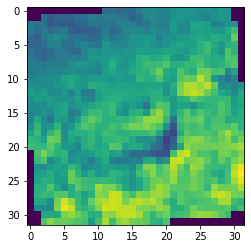

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000],
        [ 0.0510, -0.3098, -0.4353,  ...,  0.0039, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.5686,  ...,  0.4353,  0.4196,  0.3725],
        [-1.0000, -1.0000,  0.5137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-0.0930, -2.6932,  1.2080, -0.3088,  2.6530,  1.9903, -3.6317,  7.1788,
        -4.9164, -1.7553], grad_fn=<SelectBackward0>)


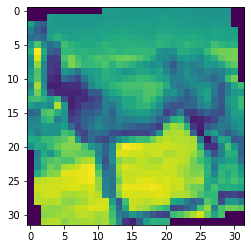

tensor([[-1.0000,  0.0588,  0.1529,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0353,  0.1294,  ...,  0.3647,  0.3098,  0.2392],
        [-1.0000,  0.1373,  0.1765,  ...,  0.3647,  0.2471,  0.1216],
        ...,
        [-0.2941, -0.2784, -0.2314,  ...,  0.0196, -0.0667, -1.0000],
        [-0.4118, -0.3020, -0.2157,  ...,  0.0980,  0.0196, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1137,  0.0902, -1.0000]]) tensor(4)
tensor([-0.1449, -2.5607,  1.3512,  1.9761,  2.2378,  1.0587,  1.9972, -0.4558,
        -2.6860, -3.1898], grad_fn=<SelectBackward0>)


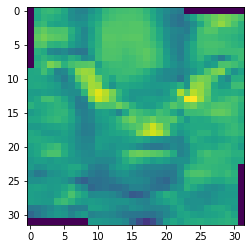

tensor([[-1.0000, -0.7333, -0.8039,  ..., -0.7020, -0.6549, -1.0000],
        [-0.7333, -0.7961, -0.7961,  ..., -0.6941, -0.7020, -0.5137],
        [-0.7255, -0.7725, -0.7804,  ..., -0.6471, -0.7020, -0.6235],
        ...,
        [-0.1373, -0.1451, -0.1843,  ..., -0.2000, -0.2627, -0.3961],
        [-0.1843, -0.1529, -0.1529,  ..., -0.1059, -0.1294, -0.2784],
        [-1.0000, -0.1294, -0.1216,  ..., -0.2000, -0.2000, -1.0000]]) tensor(4)
tensor([-1.4663, -2.4457,  0.8524,  1.3204,  4.7399,  1.1956, -0.3566,  2.5982,
        -2.6283, -3.7765], grad_fn=<SelectBackward0>)


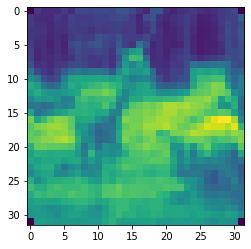

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.5318,  2.4404,  0.0311, -1.3413,  0.1279, -1.6019, -0.5972, -0.0516,
        -0.8686,  1.6126], grad_fn=<SelectBackward0>)


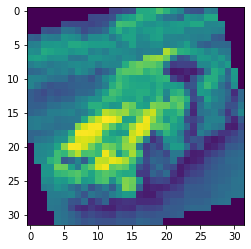

tensor([[-1.0000, -1.0000,  0.8824,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3176,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1608,  ..., -0.4353, -0.4353, -0.4431],
        ...,
        [ 0.0745,  0.0118, -0.0824,  ..., -0.2157, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2549, -1.0000, -1.0000]]) tensor(9)
tensor([-0.4449, -1.4192,  0.0749,  0.7630,  1.9390,  0.4924, -0.0415,  0.2197,
        -0.1638, -1.4718], grad_fn=<SelectBackward0>)


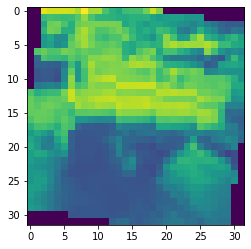

tensor([[-1.0000, -1.0000,  0.3804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3804,  ...,  0.3569,  0.3569,  0.3647],
        ...,
        [ 0.5608,  0.6000,  0.6314,  ...,  0.4824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4824, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.9208, -2.3304,  2.7266, -0.0465,  0.9295, -0.8759, -1.5147, -2.3452,
         0.6697, -2.2317], grad_fn=<SelectBackward0>)


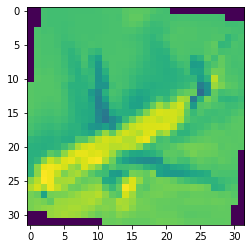

tensor([[-0.6549, -0.6471, -0.6471,  ..., -0.7098, -0.7098, -0.7412],
        [-0.6627, -0.6863, -0.6706,  ..., -0.6471, -0.6000, -0.7020],
        [-0.6549, -0.6471, -0.6471,  ..., -0.6784, -0.6549, -0.6941],
        ...,
        [-0.7255, -0.7020, -0.6863,  ..., -0.6235, -0.6078, -0.6627],
        [-0.6863, -0.6706, -0.6863,  ..., -0.6549, -0.6706, -0.7020],
        [-0.6784, -0.7020, -0.7255,  ..., -0.7020, -0.7020, -0.6392]]) tensor(5)
tensor([ 8.1156e-01, -3.9557e-01,  1.5930e+00, -1.8635e-04,  1.5848e+00,
         1.8602e+00, -2.8352e+00,  3.0709e+00, -4.3115e+00, -1.5780e+00],
       grad_fn=<SelectBackward0>)


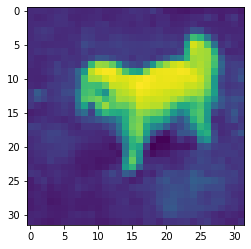

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.5294, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7255,  ...,  0.3176, -1.0000, -1.0000],
        [ 0.8667,  0.8667,  0.7647,  ..., -0.4745,  0.4039, -1.0000],
        ...,
        [-1.0000, -0.4667, -0.3725,  ..., -0.2627, -0.1843,  0.0353],
        [-1.0000, -1.0000, -0.3961,  ..., -0.2000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3961,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.2918, -0.6642,  0.6479,  0.7940,  0.6003,  1.7019, -1.6717,  1.6674,
        -2.0921, -0.0938], grad_fn=<SelectBackward0>)


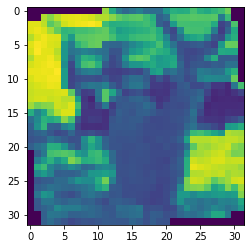

tensor([[-0.1451, -0.1608, -0.1451,  ..., -0.1451, -0.1529, -0.1373],
        [-0.1294, -0.1451, -0.1373,  ..., -0.1294, -0.1373, -0.1216],
        [-0.1059, -0.1216, -0.1216,  ..., -0.1059, -0.1059, -0.0980],
        ...,
        [-0.4902, -0.5137, -0.6078,  ..., -0.2941, -0.3255, -0.3412],
        [-0.1137, -0.1529, -0.2784,  ..., -0.3333, -0.3176, -0.3098],
        [-0.0980, -0.0980, -0.1059,  ..., -0.3176, -0.3333, -0.3490]]) tensor(7)
tensor([ 0.8711, -3.8186,  2.3917,  1.0791,  1.2344,  3.4213, -5.9754,  3.8547,
        -1.9784, -1.0733], grad_fn=<SelectBackward0>)


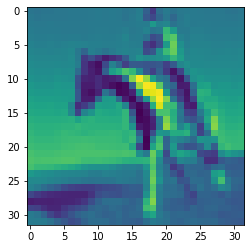

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 5.8705, -2.8597,  3.7087, -0.6350,  2.1906, -1.4120, -1.5976, -3.4523,
         1.1977, -4.1272], grad_fn=<SelectBackward0>)


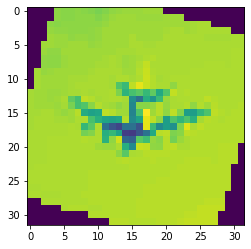

tensor([[-1.0000,  0.9765,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9843,  1.0000,  ...,  0.9451,  0.9294,  0.9373],
        [-1.0000,  0.9843,  1.0000,  ...,  0.9373,  0.9216,  0.9216],
        ...,
        [-0.0510, -0.1373, -0.2314,  ...,  0.1843,  0.0196, -1.0000],
        [ 0.0196, -0.0196, -0.1137,  ...,  0.0431, -0.0824, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0824,  0.0588, -1.0000]]) tensor(5)
tensor([ 1.6673, -1.2920,  0.7777, -0.6349,  0.8819, -1.7760, -0.1830,  0.1392,
         0.6505, -0.4162], grad_fn=<SelectBackward0>)


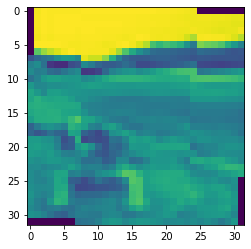

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.4495, -4.5227,  1.4973,  2.9882,  1.2533,  4.0422, -1.1254, -0.3575,
        -0.9637, -3.7481], grad_fn=<SelectBackward0>)


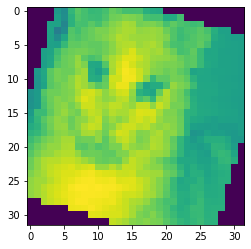

tensor([[-1.0000, -1.0000, -0.6157,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8275,  ..., -1.0000, -1.0000, -0.9843],
        ...,
        [-0.0588,  0.1137,  0.2235,  ...,  0.5608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1216, -1.0000, -1.0000]]) tensor(4)
tensor([-3.0987, -3.0766,  1.0050,  2.3687,  4.9913,  1.7911, -0.0735,  2.2734,
        -2.8956, -3.5189], grad_fn=<SelectBackward0>)


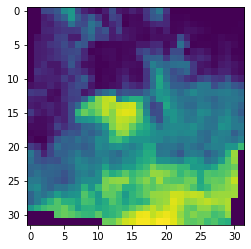

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6235, -1.0000, -1.0000],
        [-1.0000, -0.3333, -0.3255,  ..., -0.6078, -0.5922, -1.0000],
        [-0.3804, -0.3255, -0.3020,  ..., -0.5451, -0.5922, -1.0000],
        ...,
        [-1.0000, -0.4667, -0.4902,  ..., -0.3176, -0.4039, -0.4588],
        [-1.0000, -0.4275, -0.4667,  ..., -0.2471, -0.5294, -1.0000],
        [-1.0000, -1.0000, -0.3647,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-1.7598, -2.0392,  0.9673,  1.8643,  1.5390,  2.1383,  0.4096,  0.2840,
        -2.0609, -1.8051], grad_fn=<SelectBackward0>)


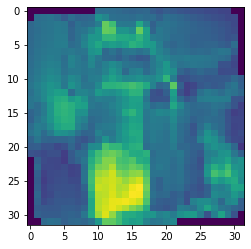

tensor([[-1.0000,  0.4275,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.4118,  0.4980,  ...,  0.6157,  0.3176, -0.1922],
        [-1.0000,  0.4196,  0.4275,  ...,  0.2863,  0.0745, -0.1137],
        ...,
        [ 0.3098,  0.2627,  0.2627,  ...,  0.3569,  0.2627, -1.0000],
        [ 0.3961,  0.2863,  0.2941,  ...,  0.2392,  0.2078, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0824,  0.1529, -1.0000]]) tensor(2)
tensor([ 1.5523, -3.2900,  3.3702,  0.4939,  2.3947,  1.3918, -0.2199,  1.1375,
        -4.1038, -3.3920], grad_fn=<SelectBackward0>)


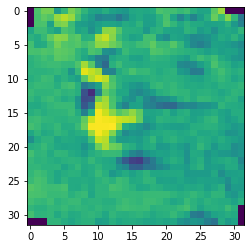

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.8851,  0.1135, -0.6709, -0.2434,  0.2620, -0.1929, -3.0743,  0.5405,
         0.1285,  1.8890], grad_fn=<SelectBackward0>)


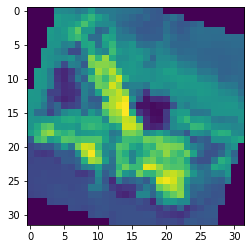

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.4566, -2.1302,  1.1611,  1.7506,  2.4017,  0.5244,  0.8809, -0.4210,
        -0.8150, -2.6486], grad_fn=<SelectBackward0>)


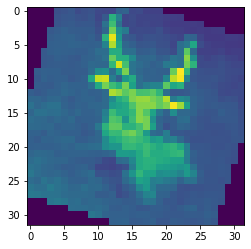

tensor([[-1.0000, -1.0000, -0.8431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7961,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6863,  ...,  0.4039,  0.3490,  0.3255],
        ...,
        [-0.5216, -0.5294, -0.5059,  ..., -0.0588, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1529, -1.0000, -1.0000]]) tensor(5)
tensor([-1.5668, -2.4481,  0.3460,  2.6946,  2.1284,  2.9747, -1.0138,  1.5204,
        -2.4200, -2.3943], grad_fn=<SelectBackward0>)


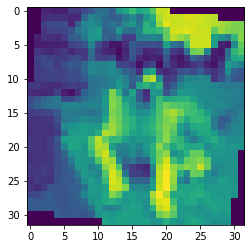

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 1.4617e+00,  1.5683e+00,  2.8140e-02, -9.2478e-01, -5.4980e-01,
        -2.1549e+00,  7.9570e-03, -2.0222e+00, -4.7812e-04,  1.7636e+00],
       grad_fn=<SelectBackward0>)


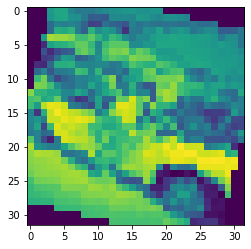

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0275, -1.0000, -1.0000],
        [-1.0000, -0.6863, -0.6549,  ...,  0.4667,  0.4667, -1.0000],
        [-0.6314, -0.6863, -0.6706,  ...,  0.6235,  0.3882, -1.0000],
        ...,
        [-1.0000, -0.7020, -0.9059,  ..., -0.8980, -0.8510, -0.6157],
        [-1.0000, -0.7804, -0.7804,  ..., -0.9294, -0.8510, -1.0000],
        [-1.0000, -1.0000, -0.7020,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-1.0551, -1.2492,  2.5453, -0.3714,  2.8122, -0.7016,  4.0335, -1.8963,
        -2.7574, -1.3696], grad_fn=<SelectBackward0>)


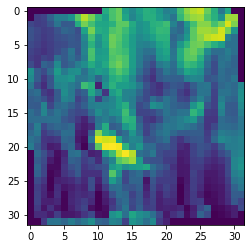

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.4491, -3.1831,  0.6503,  3.9856,  0.6422,  4.6014, -1.3238,  1.7548,
        -3.6000, -2.0335], grad_fn=<SelectBackward0>)


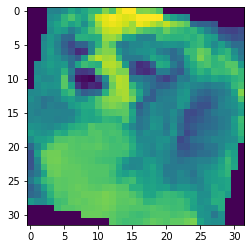

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4196, -0.4667, -1.0000],
        [ 0.0980,  0.1529,  0.2000,  ..., -0.3647, -0.4667, -1.0000],
        [ 0.0980,  0.1608,  0.1294,  ..., -0.3255, -0.4275, -1.0000],
        ...,
        [-1.0000, -0.3725, -0.1922,  ..., -0.2000, -0.3020, -0.4275],
        [-1.0000, -0.2235, -0.3569,  ..., -0.2392, -0.3804, -0.4275],
        [-1.0000, -0.0667, -0.3569,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-1.3183, -4.0052,  1.2702,  2.3763,  0.7128,  1.7303,  1.0653,  0.3244,
        -0.5871, -1.6663], grad_fn=<SelectBackward0>)


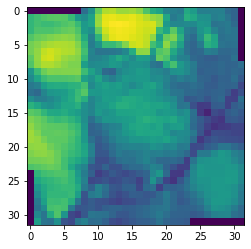

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4824, -1.0000, -1.0000],
        [ 0.4039,  0.4039,  0.3961,  ...,  0.4588, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1843,  ..., -0.4039, -0.5843, -0.4667],
        [-1.0000, -1.0000,  0.2392,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2392,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-2.1777, -4.3594,  0.8986,  4.4049,  0.3703,  2.5883,  2.5774, -0.1060,
        -1.4349, -2.6590], grad_fn=<SelectBackward0>)


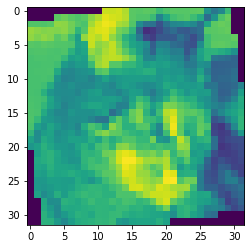

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.3647,  1.6463, -0.3170, -0.0331, -0.0673, -0.0371, -1.9959,  1.9744,
        -2.0049,  2.0080], grad_fn=<SelectBackward0>)


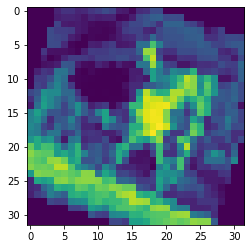

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0902, -1.0000, -1.0000],
        [ 0.1686,  0.1765,  0.1843,  ...,  0.0980, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  1.0000,  ...,  0.5529,  0.5843,  0.6314],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.0600,  5.0861, -2.3769, -0.7446, -1.7972, -2.3990,  0.1477, -4.1720,
         0.4711,  5.5729], grad_fn=<SelectBackward0>)


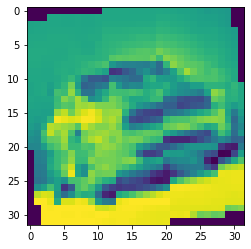

tensor([[ 0.7725,  0.7333,  0.7804,  ..., -0.7647, -0.0902,  0.6078],
        [ 0.8431,  0.7882,  0.8275,  ...,  0.1137,  0.3804,  0.6157],
        [ 0.8667,  0.7882,  0.8275,  ...,  0.5529,  0.5686,  0.5765],
        ...,
        [ 0.2863,  0.2471,  0.2392,  ..., -0.1922, -0.2000, -0.1922],
        [ 0.2471,  0.2471,  0.2471,  ..., -0.1451, -0.1843, -0.1922],
        [ 0.2549,  0.2314,  0.2157,  ..., -0.1765, -0.2078, -0.2078]]) tensor(9)
tensor([ 0.6012,  2.4213, -0.2548, -0.7350, -1.0149, -1.6328, -1.3710, -0.0633,
        -1.4585,  3.9097], grad_fn=<SelectBackward0>)


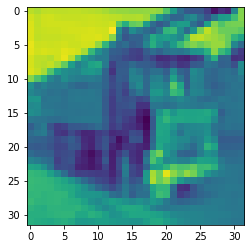

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9216,  ...,  0.9843, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.3412,  ...,  0.0824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.6096,  5.7575, -2.1010, -0.6856, -1.4348, -2.1413, -3.2194, -1.0184,
        -0.5814,  4.3632], grad_fn=<SelectBackward0>)


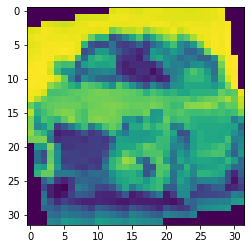

tensor([[-1.0000,  0.9373,  0.9373,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9451,  0.9529,  ...,  0.9216,  0.9216,  0.9137],
        [-1.0000,  0.9451,  0.9451,  ...,  0.9294,  0.9294,  0.9216],
        ...,
        [ 0.8353,  0.8667,  0.9059,  ...,  0.8118,  0.8667, -1.0000],
        [ 0.7020,  0.7255,  0.7569,  ...,  0.8353,  0.8588, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.8510,  0.8431, -1.0000]]) tensor(0)
tensor([ 4.2672, -0.6932,  2.4187, -0.3356,  0.5176, -2.1484, -3.2261, -1.8346,
         1.0394, -1.3477], grad_fn=<SelectBackward0>)


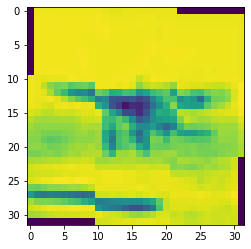

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5137, -0.5294, -1.0000],
        [-0.3412, -0.3569, -0.3647,  ..., -0.5451, -0.5686, -1.0000],
        [-0.3725, -0.3725, -0.3725,  ..., -0.2078, -0.2314, -1.0000],
        ...,
        [-1.0000, -0.5059, -0.3490,  ..., -0.3333, -0.2784, -0.2078],
        [-1.0000, -0.4275, -0.3882,  ..., -0.3255, -0.2706, -0.1922],
        [-1.0000, -0.8196, -0.7569,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 1.7355, -0.1340,  0.8149, -0.4936, -0.1900, -1.1688, -2.0091, -1.2104,
         2.2279,  0.4591], grad_fn=<SelectBackward0>)


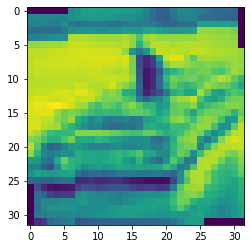

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4118, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3804, -1.0000, -1.0000],
        [ 0.3490,  0.3569,  0.3490,  ...,  0.3569, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0353,  ..., -0.4902, -0.4902, -0.5608],
        [-1.0000, -1.0000, -0.0667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 5.6814,  1.7315,  0.8822, -2.6681, -0.1186, -4.1517, -3.6101, -1.4685,
         1.1349,  1.4823], grad_fn=<SelectBackward0>)


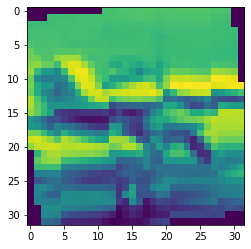

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.5429, -3.4639,  1.1070,  3.9513,  1.1221,  4.3899, -3.9717,  2.0666,
        -1.4979, -4.0518], grad_fn=<SelectBackward0>)


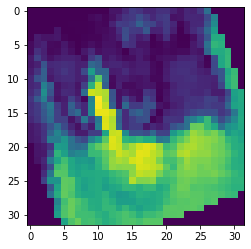

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3490, -1.0000, -1.0000],
        [ 0.1373,  0.1843,  0.2706,  ...,  0.3255, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3569,  ...,  0.3569,  0.3412,  0.3490],
        [-1.0000, -1.0000,  0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3804,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.1812, -2.1764,  2.9694,  0.7885,  2.6467,  0.4429, -1.1495,  0.6757,
        -2.8327, -2.3731], grad_fn=<SelectBackward0>)


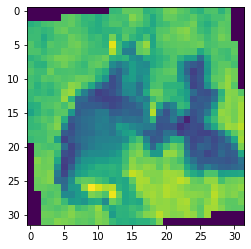

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6863, -0.6784, -1.0000],
        [-0.8196, -0.8353, -0.8510,  ..., -0.1529, -0.1608, -1.0000],
        [-0.7804, -0.7725, -0.7882,  ..., -0.1529, -0.1529, -1.0000],
        ...,
        [-1.0000, -0.7176, -0.8353,  ..., -0.1608, -0.2078, -0.1922],
        [-1.0000, -0.8667, -0.8431,  ..., -0.1922, -0.2471, -0.2549],
        [-1.0000, -0.8667, -0.8431,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.0553, -3.4946,  3.6847,  0.4578,  4.8891,  1.9621, -0.4202,  1.5208,
        -3.6326, -4.5042], grad_fn=<SelectBackward0>)


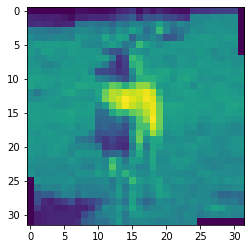

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 3.9432,  8.5040, -2.1637, -4.3798, -2.1041, -4.9111, -4.0189, -1.8709,
        -0.9970,  7.2766], grad_fn=<SelectBackward0>)


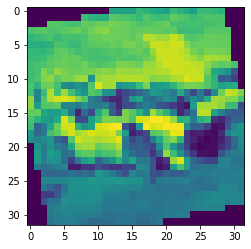

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-1.5624, -2.7868,  1.1956,  1.4697,  3.3450,  1.1306, -0.3899,  4.2298,
        -3.6888, -2.7273], grad_fn=<SelectBackward0>)


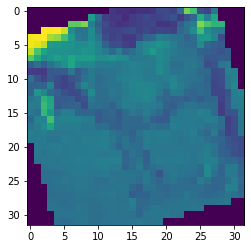

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.2715, -3.3610,  2.4698,  2.1170,  3.0130,  0.5711,  4.1934,  0.3936,
        -4.4149, -2.4960], grad_fn=<SelectBackward0>)


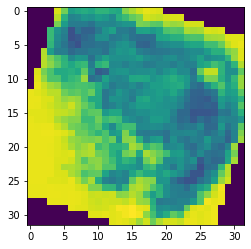

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3176, -1.0000, -1.0000],
        [-0.0353, -0.0588, -0.0902,  ..., -0.2000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1373,  ..., -0.0039, -0.1765, -0.1059],
        [-1.0000, -1.0000,  0.1216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1137,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 0.6685, -2.6020,  1.2343,  1.4615,  0.8783,  0.9541, -1.2415,  0.4072,
        -0.4401, -1.5972], grad_fn=<SelectBackward0>)


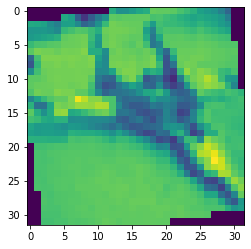

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5451, -0.3882, -1.0000],
        [ 0.3725,  0.4275,  0.4196,  ..., -0.5686, -0.6157, -1.0000],
        [ 0.3412,  0.3333,  0.3882,  ..., -0.4510, -0.6000, -1.0000],
        ...,
        [-1.0000,  0.0745,  0.0353,  ..., -0.1686, -0.2627, -0.3098],
        [-1.0000,  0.1373,  0.1059,  ..., -0.1608, -0.2392, -0.2706],
        [-1.0000,  0.2784,  0.2549,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.0672, -3.5725,  2.2065,  0.6234,  2.5457,  0.7192,  0.0097,  0.5370,
        -1.3754, -2.5212], grad_fn=<SelectBackward0>)


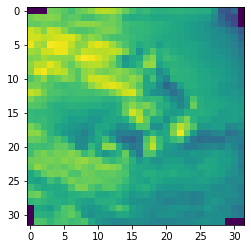

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([ 0.1563, -1.9927,  0.6090,  1.7576,  1.6472,  0.9119, -0.1246, -0.8279,
         0.1351, -2.4538], grad_fn=<SelectBackward0>)


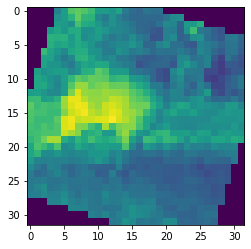

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2471, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2784, -1.0000, -1.0000],
        [-0.0196,  0.1686,  0.2078,  ..., -0.2392, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0510,  ...,  0.1137, -0.0667, -0.3412],
        [-1.0000, -1.0000, -0.1451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2863,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-0.1196,  0.6950,  0.3496,  1.4637,  1.5892,  0.3251, -1.4491,  0.0130,
        -2.0893, -0.5363], grad_fn=<SelectBackward0>)


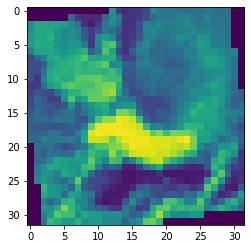

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000],
        [-0.0902, -0.1529, -0.4118,  ...,  0.1843, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.6000,  ...,  0.7882,  0.7176,  0.7647],
        [-1.0000, -1.0000, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6392,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.6853, -1.4740,  0.2698, -0.1360,  2.9374,  0.7996,  1.5972,  4.7704,
        -5.8287, -1.1458], grad_fn=<SelectBackward0>)


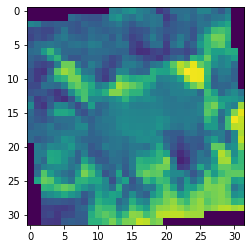

tensor([[-1.0000, -0.4980, -0.4745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.5216, -0.5843,  ..., -0.6000, -0.6784, -0.6941],
        [-1.0000, -0.4353, -0.4510,  ..., -0.5451, -0.6549, -0.5608],
        ...,
        [ 0.0980,  0.0510, -0.0118,  ...,  0.4667,  0.4275, -1.0000],
        [ 0.2392,  0.2157,  0.2314,  ...,  0.4667,  0.4353, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3804,  0.3412, -1.0000]]) tensor(7)
tensor([-3.0308, -2.5628,  0.3182,  1.0862,  6.7043,  1.7754, -4.4453, 10.8611,
        -6.1847, -5.2921], grad_fn=<SelectBackward0>)


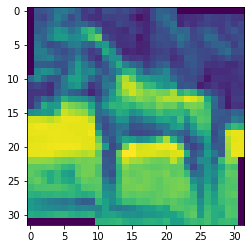

tensor([[ 0.0588,  0.5216,  0.5843,  ...,  0.4118,  0.0824, -0.7020],
        [-0.3569,  0.3490,  0.6078,  ...,  0.3961,  0.2627, -0.5608],
        [ 0.0196,  0.3725,  0.4588,  ...,  0.3333,  0.3255, -0.2863],
        ...,
        [-0.5451, -0.5373, -0.5137,  ..., -0.3098, -0.3176, -0.3412],
        [-0.5451, -0.5216, -0.5059,  ..., -0.3255, -0.3333, -0.3647],
        [-0.5686, -0.5294, -0.4980,  ..., -0.3490, -0.3725, -0.4118]]) tensor(9)
tensor([ 1.1583, -0.8946, -0.1572,  0.3663, -0.5208, -0.3928, -3.4485,  0.8133,
         1.0827,  2.3649], grad_fn=<SelectBackward0>)


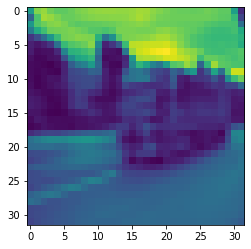

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.8275,  0.8431, -1.0000],
        [ 0.5765,  0.6000,  0.6000,  ...,  0.8353,  0.8510, -1.0000],
        [ 0.5608,  0.5843,  0.5922,  ...,  0.8275,  0.8431, -1.0000],
        ...,
        [-1.0000,  0.4980,  0.4745,  ...,  0.7490,  0.7725,  0.7647],
        [-1.0000,  0.5216,  0.4824,  ...,  0.7569,  0.7804,  0.7725],
        [-1.0000,  0.5451,  0.5529,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 4.5362,  0.5121,  1.3033, -1.4835,  1.5258, -2.6541, -4.3182, -0.9582,
         0.0796,  0.6351], grad_fn=<SelectBackward0>)


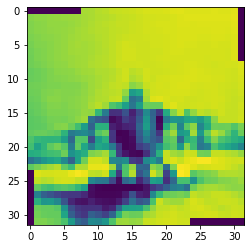

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.2195, -4.4004,  1.4827,  2.9844,  0.9820,  3.4009,  0.4476, -0.1340,
        -1.5997, -3.3144], grad_fn=<SelectBackward0>)


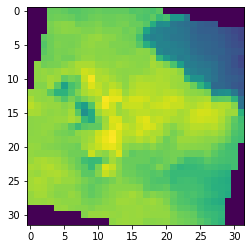

tensor([[-1.0000,  0.9373,  0.6863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.8980, -0.0588,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000,  0.9137, -0.0510,  ...,  0.6863,  0.6706,  0.6784],
        ...,
        [ 0.7490,  0.7255,  0.7255,  ...,  0.1373,  0.9137, -1.0000],
        [ 0.9922,  0.9765,  1.0000,  ...,  0.0902,  0.8980, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.7176,  0.9529, -1.0000]]) tensor(2)
tensor([-2.5017, -4.8783,  3.1592,  2.9138,  3.6443,  1.5011,  2.6083,  0.7000,
        -4.4122, -3.4544], grad_fn=<SelectBackward0>)


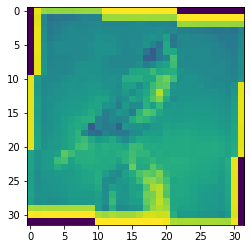

tensor([[-1.0000, -0.6549, -0.6549,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.6314, -0.6392,  ..., -0.6549, -0.6627, -0.6784],
        [-1.0000, -0.6000, -0.6314,  ..., -0.6627, -0.6784, -0.6784],
        ...,
        [ 0.8588,  0.8667,  0.8902,  ..., -0.6706, -0.6706, -1.0000],
        [ 0.8902,  0.7333,  0.7098,  ..., -0.6706, -0.6706, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6706, -0.6706, -1.0000]]) tensor(6)
tensor([-2.8384, -2.3921,  0.9086,  3.5165,  2.2460,  1.8826,  1.9481,  0.2316,
        -1.9054, -3.5330], grad_fn=<SelectBackward0>)


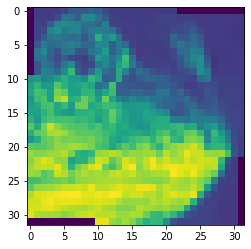

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-1.7961,  3.6652, -2.9280, -0.8025, -0.0624, -1.5620,  0.8952, -1.8555,
        -0.4658,  5.1241], grad_fn=<SelectBackward0>)


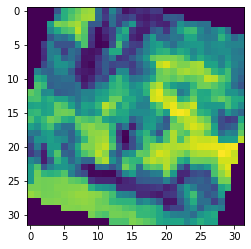

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3569, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4353, -1.0000, -1.0000],
        [-0.3255, -0.2863, -0.3333,  ..., -0.4824, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0667,  ...,  0.1922,  0.2078,  0.2078],
        [-1.0000, -1.0000, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2627,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-2.8752, -4.8801,  0.8427,  2.9981,  2.4368,  3.5698,  0.1091,  2.9139,
        -2.1823, -3.4129], grad_fn=<SelectBackward0>)


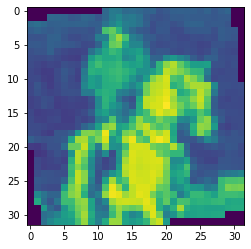

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.5279,  0.6782, -0.3557,  0.6264, -0.3695, -0.9717,  3.7542, -2.2869,
        -0.8182,  1.9577], grad_fn=<SelectBackward0>)


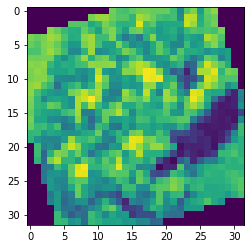

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 0.9765, 0.9216,  ..., 0.8667, 0.9529, 1.0000],
        [1.0000, 0.9294, 0.7882,  ..., 0.5765, 0.8588, 1.0000],
        ...,
        [0.9922, 0.8745, 0.6235,  ..., 0.6000, 0.8510, 0.9922],
        [1.0000, 0.9529, 0.8745,  ..., 0.8510, 0.9451, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.9922, 1.0000, 1.0000]]) tensor(1)
tensor([ 0.3674,  5.7872, -1.5462,  0.0743, -1.6090, -1.2222, -2.4151, -2.4999,
        -1.8080,  5.3699], grad_fn=<SelectBackward0>)


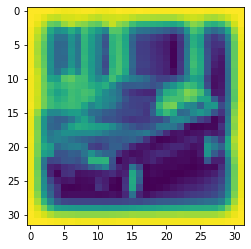

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.5132, -0.1127, -0.4442,  1.1236, -1.2376,  1.5386, -2.4869,  0.0060,
         0.9820,  0.6753], grad_fn=<SelectBackward0>)


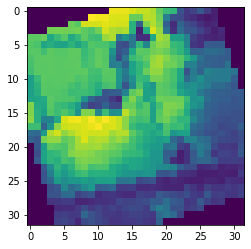

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -1.0000, -1.0000],
        [-1.0000, -0.8118, -0.7804,  ..., -0.3020, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.6471,  ..., -0.5137, -0.3255, -1.0000],
        [-1.0000, -1.0000, -0.4275,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.7770,  0.0415,  0.4933,  1.8681, -0.5176, -0.4719,  5.1883, -2.1268,
        -1.8755, -0.3568], grad_fn=<SelectBackward0>)


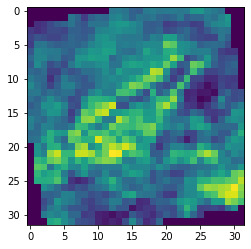

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0118, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1137, -1.0000, -1.0000],
        [-0.0275, -0.0039, -0.0588,  ..., -0.1137, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0431,  ..., -0.1216, -0.0980, -0.0353],
        [-1.0000, -1.0000, -0.0667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0980,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.4300, -3.9397,  4.7184,  0.4553,  4.2673, -0.3136,  2.1404, -0.5169,
        -3.3972, -4.4462], grad_fn=<SelectBackward0>)


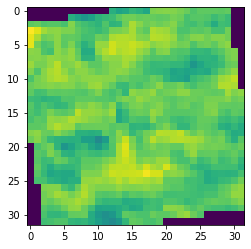

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.1216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1373, -1.0000, -1.0000],
        [ 0.2314,  0.2314,  0.2392,  ...,  0.1216, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.3569,  ..., -0.0431, -0.0431, -0.0118],
        [-1.0000, -1.0000, -0.4353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7176,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 2.4702, -2.4401,  3.2083, -0.0897,  1.1605, -1.4512, -1.0218, -2.5016,
         2.0114, -2.2781], grad_fn=<SelectBackward0>)


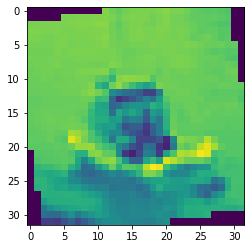

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8353, -1.0000, -1.0000],
        [-1.0000, -0.4588, -0.7412,  ..., -0.8510, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4431,  ..., -0.6235, -0.6549, -1.0000],
        [-1.0000, -1.0000, -0.1608,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.3817, -0.7700,  0.5243,  0.6547,  1.1854, -0.0966,  4.3837, -0.5998,
        -2.9394, -0.9842], grad_fn=<SelectBackward0>)


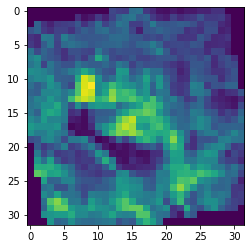

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0431,  ..., -0.4588, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3569,  ...,  0.3804, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.9328, -1.5030,  2.0260, -0.6255,  2.2720, -0.4532, -2.7417,  2.5371,
        -1.7750, -1.0041], grad_fn=<SelectBackward0>)


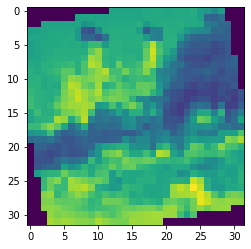

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.3032, -4.7647,  2.0204,  4.1043,  1.4136,  2.1720,  3.2848, -0.5365,
        -1.8944, -3.5596], grad_fn=<SelectBackward0>)


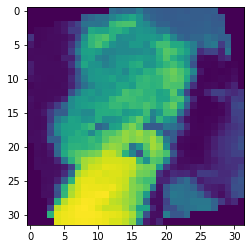

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-2.0952, -1.6847,  0.2788,  3.1827, -0.1163,  2.7211,  0.8896,  0.7705,
        -2.3008, -1.5361], grad_fn=<SelectBackward0>)


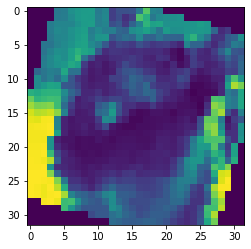

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.2696, -1.2543, -0.7707,  0.1553,  1.3362,  1.3700, -1.8745,  2.8129,
        -2.2592,  0.5624], grad_fn=<SelectBackward0>)


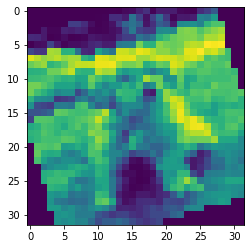

tensor([[-1.0000, -1.0000,  0.1686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0824,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0353,  ...,  0.4431,  0.4510,  0.4902],
        ...,
        [ 0.5922,  0.5765,  0.5843,  ...,  0.1373, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5529, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5686, -1.0000, -1.0000]]) tensor(7)
tensor([-1.8543, -3.5048, -0.1189,  0.9080,  3.5127,  2.2746, -1.0588,  6.7883,
        -5.2861, -2.2208], grad_fn=<SelectBackward0>)


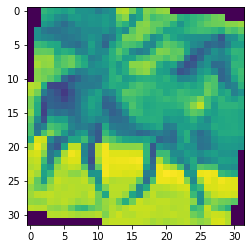

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 1.7904,  3.8157, -0.6443, -1.9970, -0.4205, -2.6771, -2.4243,  0.1043,
         0.0392,  2.6689], grad_fn=<SelectBackward0>)


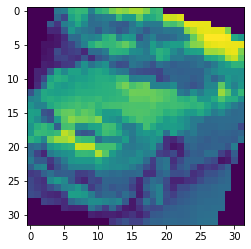

tensor([[-0.5137, -0.5529, -0.5373,  ..., -0.5451, -0.5608, -0.5529],
        [-0.5137, -0.5608, -0.5373,  ..., -0.5216, -0.5373, -0.5373],
        [-0.5294, -0.5608, -0.5373,  ..., -0.5373, -0.5529, -0.5608],
        ...,
        [-0.5137, -0.5137, -0.4902,  ..., -0.5294, -0.5686, -0.5608],
        [-0.5686, -0.5765, -0.5451,  ..., -0.5059, -0.5373, -0.5216],
        [-0.6235, -0.6471, -0.6235,  ..., -0.5137, -0.5294, -0.4980]]) tensor(8)
tensor([ 3.3398, -0.6699,  1.7143, -0.8370,  1.4731, -2.0402, -1.2195, -2.3286,
         2.1369, -2.3534], grad_fn=<SelectBackward0>)


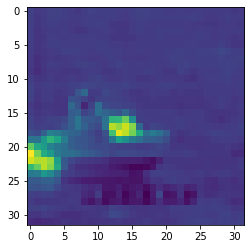

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.8824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9216, -1.0000, -1.0000],
        [-0.9451, -0.9451, -0.9294,  ..., -0.9294, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1843,  ...,  0.3961,  0.4588,  0.5765],
        [-1.0000, -1.0000,  0.1216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-2.3134, -2.5376, -0.1122,  2.9754,  1.2057,  3.3212,  0.2963,  1.5958,
        -2.1187, -2.2815], grad_fn=<SelectBackward0>)


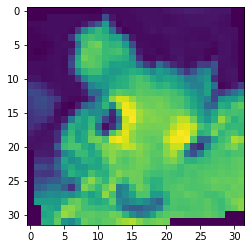

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 3.0828,  5.4717, -2.0768, -1.4052, -0.8211, -3.3982, -3.6177, -2.2801,
         0.4867,  3.6548], grad_fn=<SelectBackward0>)


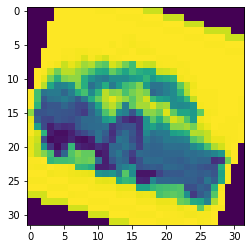

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6000, -1.0000, -1.0000],
        [-0.4902, -0.5451, -0.5765,  ..., -0.6235, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.2000,  ..., -0.4667, -0.4588, -0.4118],
        [-1.0000, -1.0000, -0.2078,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.2683,  5.0707, -1.2225, -1.1972, -2.0902, -1.5472, -3.3428,  0.4866,
         1.3161,  1.3043], grad_fn=<SelectBackward0>)


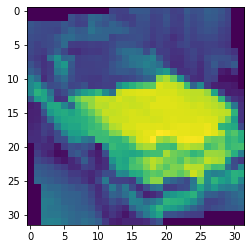

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.2456, -4.1746,  0.8481,  3.3814,  0.6927,  3.7584, -1.1024,  2.4554,
        -2.7417, -2.2520], grad_fn=<SelectBackward0>)


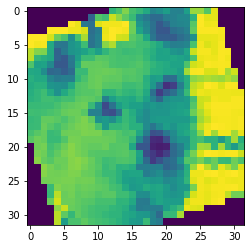

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.9216,  ..., -0.5608, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.7490,  ..., -0.7804, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-3.5739, -5.5666,  0.6673,  5.1789,  1.7728,  4.0875,  2.4211,  0.4996,
        -1.9261, -3.8212], grad_fn=<SelectBackward0>)


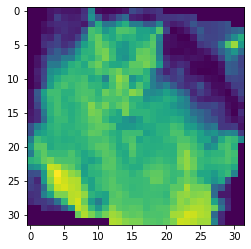

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.7412, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3882,  ...,  0.7725, -1.0000, -1.0000],
        [ 0.2627,  0.3255,  0.3882,  ...,  0.7020,  0.7020, -1.0000],
        ...,
        [-1.0000, -0.0902, -0.0902,  ..., -0.0667, -0.0745, -0.0824],
        [-1.0000, -1.0000, -0.1059,  ..., -0.0667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.1987, -0.0345,  0.0441, -0.5604,  0.9805, -1.5100, -4.5797, -0.3368,
         1.2638,  1.0077], grad_fn=<SelectBackward0>)


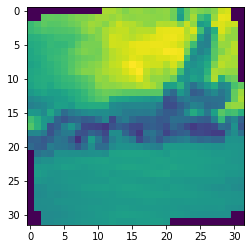

tensor([[-1.0000, -1.0000,  0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3647,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2392,  ...,  0.2784,  0.2863,  0.3333],
        ...,
        [ 0.0980,  0.1922,  0.0510,  ...,  0.0353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1765, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4118, -1.0000, -1.0000]]) tensor(2)
tensor([-0.3243, -3.6642,  2.0948,  1.4028,  0.7513,  1.2543, -0.2009,  0.0178,
        -0.6904, -1.3643], grad_fn=<SelectBackward0>)


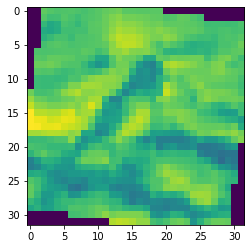

tensor([[-1.0000, -1.0000, -0.0667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1216,  ..., -0.0902, -0.0745, -0.0667],
        ...,
        [-0.0902, -0.1059, -0.1216,  ..., -0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0196, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2471, -1.0000, -1.0000]]) tensor(5)
tensor([-0.0337, -3.8079,  1.8330,  1.4061,  2.6347,  3.1718, -1.5129,  1.3830,
        -2.3851, -3.6899], grad_fn=<SelectBackward0>)


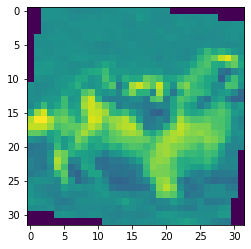

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.3163, -1.3181,  0.8997, -1.1261,  3.5955, -0.5456, -2.7474,  5.8243,
        -3.4646, -1.1761], grad_fn=<SelectBackward0>)


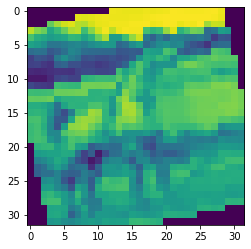

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0118, -1.0000, -1.0000],
        [-1.0000, -0.0275, -0.0118,  ...,  0.0118, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4431,  ..., -0.5922, -0.5922, -1.0000],
        [-1.0000, -1.0000, -0.5059,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 4.0172, -2.4942,  2.0370, -0.4577,  0.2358, -2.7421, -1.3232, -4.2603,
         6.3103, -1.7611], grad_fn=<SelectBackward0>)


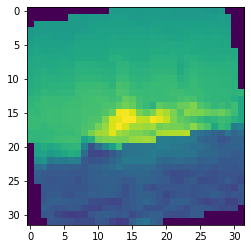

tensor([[-1.0000, -1.0000, -0.4510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1216,  ..., -0.6392, -0.6000, -0.6157],
        ...,
        [-0.0745, -0.0745, -0.0980,  ...,  0.0980, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0431, -1.0000, -1.0000]]) tensor(7)
tensor([-2.0556, -2.7189,  2.1539, -0.1174,  4.1189,  2.7056, -0.7732,  8.8378,
        -9.1691, -3.3358], grad_fn=<SelectBackward0>)


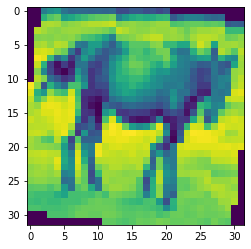

tensor([[ 0.6706,  0.5686,  0.2549,  ..., -0.7333, -0.6000, -0.8039],
        [ 0.5686,  0.5608,  0.2000,  ..., -0.5843, -0.5216, -0.6627],
        [ 0.1216,  0.1137,  0.1922,  ..., -0.6235, -0.6471, -0.6549],
        ...,
        [ 0.0745,  0.1059,  0.1137,  ..., -0.0824, -0.1216, -0.1451],
        [ 0.0431,  0.0667,  0.0745,  ..., -0.1451, -0.1765, -0.2078],
        [ 0.0353,  0.0431,  0.0667,  ..., -0.1529, -0.1843, -0.2078]]) tensor(1)
tensor([ 2.3467,  8.8863, -2.5243, -2.6002, -3.4474, -4.3438, -3.2363, -2.7507,
         1.4300,  5.8025], grad_fn=<SelectBackward0>)


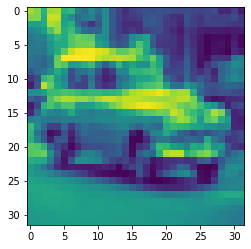

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.6968, -2.5162,  0.2790,  1.8360,  1.9934,  1.8139, -0.9226,  1.5547,
        -1.8507, -1.6901], grad_fn=<SelectBackward0>)


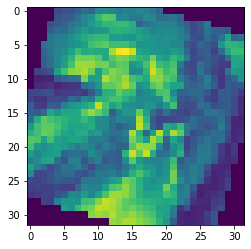

tensor([[-1.0000,  0.8902,  0.8667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.8980,  0.8745,  ...,  0.8745,  0.8824,  0.8745],
        [-1.0000,  0.8980,  0.8667,  ...,  0.8667,  0.8745,  0.8667],
        ...,
        [-0.2235, -0.2157, -0.1843,  ..., -0.1843, -0.1686, -1.0000],
        [-0.2000, -0.1451, -0.1059,  ..., -0.1843, -0.2000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2157, -0.1922, -1.0000]]) tensor(1)
tensor([ 2.4668,  1.0659, -0.7426, -0.4659, -0.4505, -2.0023, -3.8414, -0.9321,
         2.6384,  1.5145], grad_fn=<SelectBackward0>)


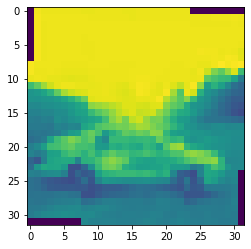

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ...,  0.3255, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9686,  ...,  1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.2270,  2.8269, -2.9821,  0.1652, -0.4745, -1.9097, -2.4283, -0.8355,
        -0.3118,  5.8340], grad_fn=<SelectBackward0>)


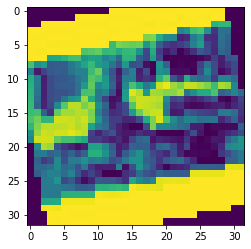

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-1.7163, -2.0154,  0.6221,  1.9159,  1.2915,  1.7575,  1.0489,  0.2686,
        -2.5303, -1.1460], grad_fn=<SelectBackward0>)


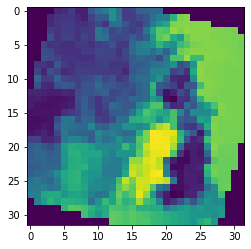

tensor([[-1.0000, -0.1765, -0.1843,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.1922, -0.2078,  ..., -0.3098, -0.3098, -0.3176],
        [-1.0000, -0.2235, -0.2314,  ..., -0.3333, -0.3333, -0.3412],
        ...,
        [ 0.7412,  0.7412,  0.7255,  ...,  0.3490,  0.3804, -1.0000],
        [ 0.7569,  0.7569,  0.7412,  ...,  0.4275,  0.4275, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4196,  0.4275, -1.0000]]) tensor(4)
tensor([-0.9639, -4.3623,  1.9247,  2.3436,  3.5297,  1.6930,  0.8921, -0.1816,
        -2.3291, -3.4153], grad_fn=<SelectBackward0>)


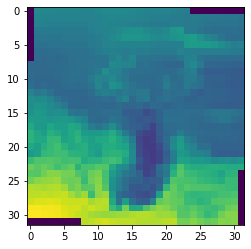

tensor([[-0.6863, -0.6235, -0.6157,  ..., -0.7725, -0.7804, -0.8196],
        [-0.7569, -0.7176, -0.7098,  ..., -0.8667, -0.8667, -0.9137],
        [-0.7490, -0.7176, -0.7176,  ..., -0.8667, -0.8510, -0.8745],
        ...,
        [-0.7333, -0.6627, -0.7020,  ..., -0.8196, -0.8431, -0.8902],
        [-0.5059, -0.3882, -0.4745,  ..., -0.8196, -0.8431, -0.8824],
        [-0.3020, -0.2627, -0.2941,  ..., -0.7882, -0.8196, -0.8667]]) tensor(6)
tensor([-1.6269, -4.0573,  0.8116,  1.2867,  0.7899,  2.2528,  0.1433,  1.1936,
        -0.4941, -0.5634], grad_fn=<SelectBackward0>)


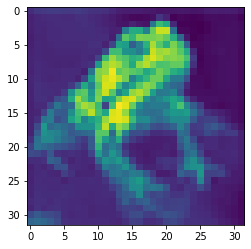

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-1.0602, -3.6961,  2.2902,  1.8115,  2.2915,  0.7724,  1.4291, -1.0905,
        -0.1310, -2.9620], grad_fn=<SelectBackward0>)


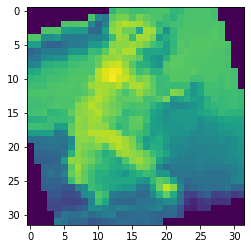

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.9289, -2.7934,  3.0560,  1.2534,  2.7469, -0.4291,  3.4549, -1.0855,
        -3.0312, -2.3815], grad_fn=<SelectBackward0>)


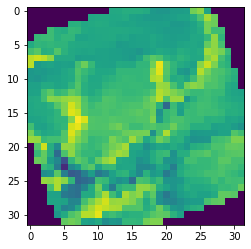

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3804, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1608,  ..., -0.2157, -1.0000, -1.0000],
        [-0.1059,  0.1059,  0.2392,  ..., -0.4275, -0.3804, -1.0000],
        ...,
        [-1.0000,  0.0431,  0.2235,  ...,  0.8667,  0.6000,  0.5843],
        [-1.0000, -1.0000,  0.0039,  ...,  0.5843, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.8162, -4.2425,  2.2025,  1.5142,  1.7978,  2.8864, -0.1904,  3.6086,
        -4.6512, -1.9062], grad_fn=<SelectBackward0>)


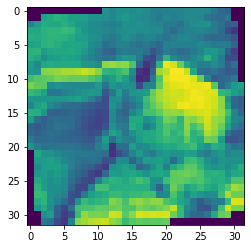

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4745, -0.4745, -1.0000],
        [-0.3569, -0.3020, -0.3098,  ..., -0.3333, -0.2627, -1.0000],
        [-0.0275, -0.1608, -0.3098,  ...,  0.1137,  0.1059, -1.0000],
        ...,
        [-1.0000,  0.0118, -0.0118,  ..., -0.1373, -0.3333, -0.3020],
        [-1.0000, -0.1608,  0.0039,  ..., -0.2784, -0.3333, -0.2627],
        [-1.0000, -0.2627, -0.1686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.8732, -1.6197,  1.4257, -0.3669,  2.1702, -0.4264,  3.2393,  1.3430,
        -4.0180, -1.2699], grad_fn=<SelectBackward0>)


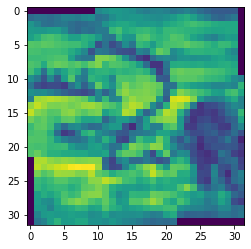

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-3.5036, -0.0478, -0.6274,  3.4673, -0.0488,  1.7754,  3.5717, -0.7563,
        -2.7410, -0.5253], grad_fn=<SelectBackward0>)


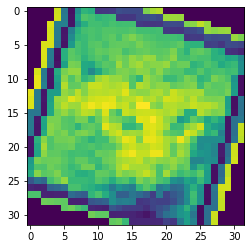

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.7121,  1.3809, -1.9189,  0.1864, -1.1580, -0.0696,  0.1224, -0.4837,
        -1.0299,  3.8047], grad_fn=<SelectBackward0>)


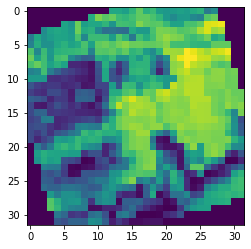

tensor([[-1.0000, -0.8353, -0.9686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.8588, -0.9686,  ..., -0.9843, -0.9765, -0.9765],
        [-1.0000, -0.8588, -0.8745,  ..., -0.9686, -0.9529, -0.9608],
        ...,
        [-0.9529, -0.9529, -0.8118,  ...,  0.3255,  0.4196, -1.0000],
        [-0.9765, -0.9294, -0.7412,  ...,  0.2706,  0.3490, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2863,  0.1765, -1.0000]]) tensor(8)
tensor([ 2.2757,  0.1898, -1.2424, -0.2727,  1.0027, -1.6179, -0.7155, -3.3502,
         3.7632, -1.3145], grad_fn=<SelectBackward0>)


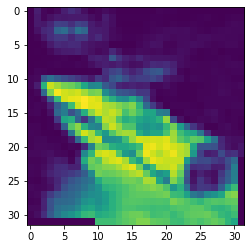

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 5.1130, -0.1017,  1.4773, -1.3315,  0.3103, -3.3038, -2.9393, -2.7446,
         2.4879, -0.0919], grad_fn=<SelectBackward0>)


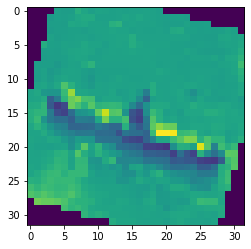

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-2.1678, -1.8280,  1.0080,  0.9466,  3.1076,  1.2488,  1.9012,  1.9226,
        -3.8053, -2.0049], grad_fn=<SelectBackward0>)


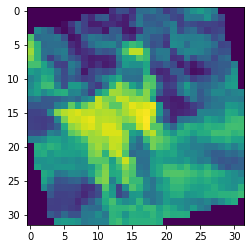

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-1.4580, -3.7404,  0.4768,  1.0225,  3.1569,  2.9231, -1.0107,  5.2947,
        -4.9911, -2.2408], grad_fn=<SelectBackward0>)


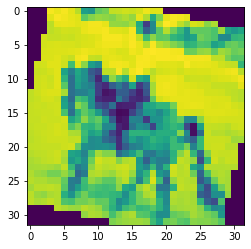

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.0649,  3.1306, -0.3673, -1.0805, -0.6254, -1.4598,  0.0148, -1.8590,
         0.7066,  1.4230], grad_fn=<SelectBackward0>)


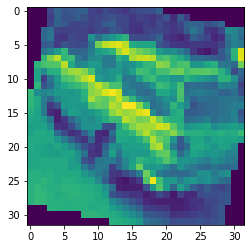

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-2.6410, -2.5941,  1.4489,  1.8751,  4.3606,  1.5715,  2.6689,  1.2839,
        -4.5020, -3.8990], grad_fn=<SelectBackward0>)


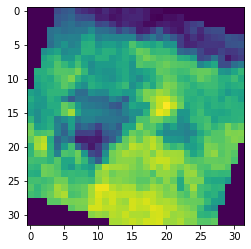

tensor([[-0.3333, -0.5059, -0.5059,  ..., -0.0353, -0.0431, -0.0980],
        [-0.5137, -0.6784, -0.6784,  ...,  0.3020,  0.3020,  0.2941],
        [-0.5137, -0.6314, -0.6000,  ...,  0.2784,  0.3020,  0.2863],
        ...,
        [-0.3569, -0.1922, -0.1843,  ...,  0.8510,  0.8196,  0.7020],
        [-0.2784,  0.1059,  0.1529,  ...,  0.7725,  0.7804,  0.6549],
        [-0.0980,  0.3647,  0.3804,  ...,  0.7255,  0.7569,  0.6549]]) tensor(7)
tensor([-1.7201, -2.7387,  0.2554,  0.8670,  2.3954,  1.9013, -0.9823,  5.6646,
        -4.7277, -1.2008], grad_fn=<SelectBackward0>)


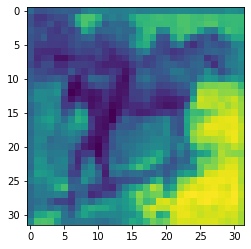

tensor([[-1.0000, -1.0000,  0.6157,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2706,  ...,  0.5216, -1.0000, -1.0000],
        [-1.0000,  0.5373, -0.3176,  ..., -0.5373,  0.3569,  0.3333],
        ...,
        [ 0.7804,  0.9686,  0.3176,  ...,  0.1294,  0.5922, -1.0000],
        [-1.0000, -1.0000,  0.9216,  ...,  0.5373, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4275, -1.0000, -1.0000]]) tensor(4)
tensor([-2.5695, -2.9589,  0.7301,  2.0523,  2.7847,  1.3446,  2.2166,  1.7753,
        -4.1235, -1.7556], grad_fn=<SelectBackward0>)


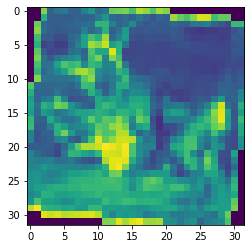

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-3.2663, -4.7652,  0.9434,  3.7225,  3.1948,  3.5761,  1.5811,  1.9537,
        -2.7649, -4.2310], grad_fn=<SelectBackward0>)


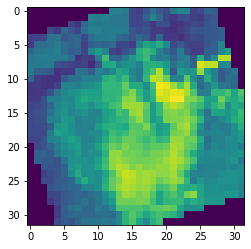

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.8776, -5.4838,  3.8087,  2.5204,  3.3190,  2.3087,  1.7507, -0.1061,
        -3.2887, -3.6316], grad_fn=<SelectBackward0>)


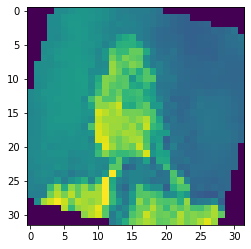

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 3.1778,  2.7402, -1.1289, -2.1754, -0.7211, -2.8347, -3.6922,  0.6845,
        -0.7029,  4.4353], grad_fn=<SelectBackward0>)


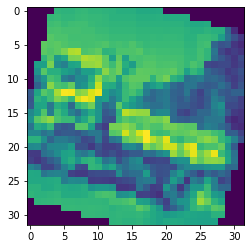

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6078, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6000, -1.0000, -1.0000],
        [-0.6314,  0.0902, -0.4118,  ..., -0.7569, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.3725,  ..., -0.5059, -0.6157, -0.7490],
        [-1.0000, -1.0000, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7725,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-2.5744, -2.3989,  1.5023,  0.3042,  2.3479,  1.8859,  4.0444,  0.7042,
        -5.5335, -0.3054], grad_fn=<SelectBackward0>)


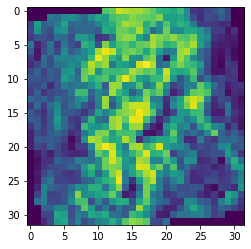

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.4234, -0.6057,  0.4589, -0.6583,  2.1641,  0.2760, -3.9474,  4.1932,
        -2.1423, -0.5762], grad_fn=<SelectBackward0>)


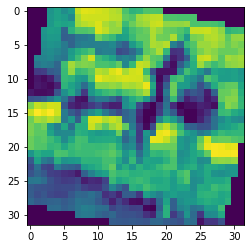

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3412, -1.0000, -1.0000],
        [ 0.3569,  0.3804,  0.3725,  ...,  0.3647, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3804,  ...,  0.4353,  0.2471,  0.1451],
        [-1.0000, -1.0000, -0.0118,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2078,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-1.0121,  1.2703, -1.7565, -0.3232, -0.2747,  0.2044, -0.7336,  0.8840,
        -2.7781,  4.8928], grad_fn=<SelectBackward0>)


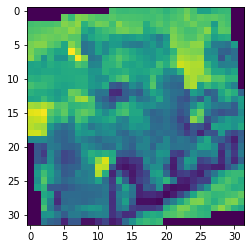

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 5.8182,  1.0153,  0.8848, -1.9533,  1.2002, -3.7751, -3.6358, -2.8119,
         3.4261, -1.5668], grad_fn=<SelectBackward0>)


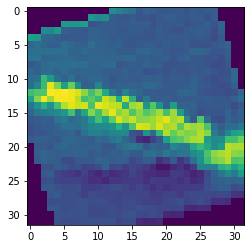

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 1.1893,  2.2555, -0.3171,  0.8715, -1.1397, -0.4160, -0.7658, -2.3495,
        -1.5185,  1.5422], grad_fn=<SelectBackward0>)


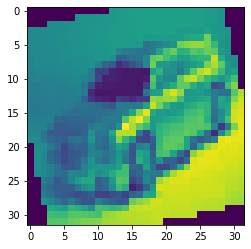

tensor([[-1.0000, -0.3098, -0.1843,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.2941, -0.1686,  ..., -0.4510, -0.4824, -0.4980],
        [-1.0000, -0.2392, -0.1765,  ..., -0.4039, -0.4588, -0.4196],
        ...,
        [ 0.0745,  0.0745,  0.0824,  ...,  0.1686,  0.1843, -1.0000],
        [ 0.1608,  0.1608,  0.1608,  ...,  0.1608,  0.1765, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1686,  0.1843, -1.0000]]) tensor(1)
tensor([ 0.6279,  1.0423, -0.4356,  0.2232,  0.1660, -0.0903, -1.8783,  0.5047,
        -0.1178, -0.2480], grad_fn=<SelectBackward0>)


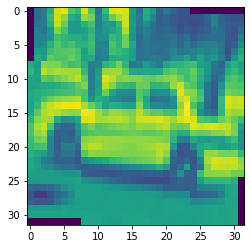

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.5259,  0.2539, -0.9068,  0.5201,  0.0575,  0.2243,  1.0738, -0.4366,
        -1.6294,  1.9788], grad_fn=<SelectBackward0>)


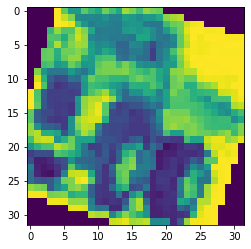

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 2.6051,  0.4451, -0.3016, -1.1425,  2.5014, -1.6842, -1.6820, -1.1573,
         0.4139, -0.6547], grad_fn=<SelectBackward0>)


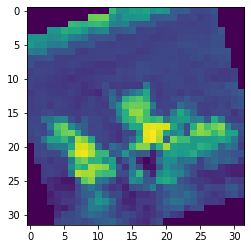

tensor([[-1.0000, -1.0000,  0.6863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6471,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6078,  ...,  0.7882,  0.7255,  0.7098],
        ...,
        [-0.2549, -0.2706, -0.2941,  ..., -0.1059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.4960,  1.4137, -1.3590, -0.5055,  0.0931, -0.6115, -4.7760,  1.9620,
        -1.9357,  4.8242], grad_fn=<SelectBackward0>)


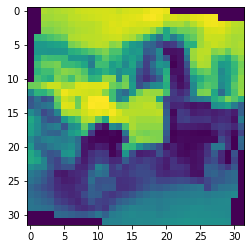

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0588, -1.0000, -1.0000],
        [ 0.1529,  0.1059, -0.0980,  ...,  0.1765, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4902,  ...,  0.2941,  0.3569,  0.2784],
        [-1.0000, -1.0000,  0.5686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.5451,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.4123, -5.1629,  4.1210,  1.3626,  4.3305,  1.1928,  3.2303,  0.7616,
        -4.7454, -4.7254], grad_fn=<SelectBackward0>)


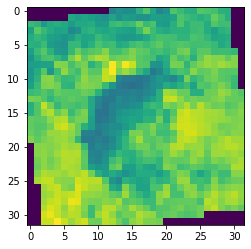

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2078,  ..., -0.0667, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.5059,  ..., -0.2314, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.8079, -3.5095,  2.7986,  1.6071,  2.5553,  1.3781,  0.8760, -0.0593,
        -2.5746, -3.0216], grad_fn=<SelectBackward0>)


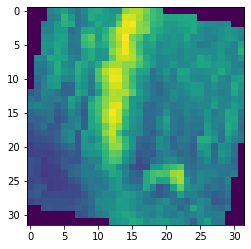

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 3.3409,  5.7234, -1.3472, -2.0252, -0.4958, -4.1990, -2.8010, -3.4957,
         1.4773,  2.9519], grad_fn=<SelectBackward0>)


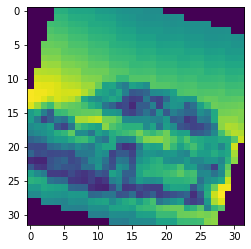

tensor([[-1.0000, -0.1765, -0.4118,  ..., -0.9373, -0.8745, -1.0000],
        [-0.5137, -0.3333, -0.2706,  ..., -0.8824, -0.8980, -0.8588],
        [-0.5686, -0.7255, -0.6784,  ..., -0.9137, -0.8667, -0.6941],
        ...,
        [-0.5137, -0.4980, -0.4745,  ...,  0.1216,  0.1608, -0.0667],
        [-0.5373, -0.5059, -0.4980,  ..., -0.1608, -0.1529, -0.4824],
        [-1.0000, -0.5765, -0.5451,  ..., -0.0824, -0.1843, -1.0000]]) tensor(3)
tensor([-0.9337, -2.4386,  0.3565,  3.3540,  2.1224,  2.8919, -1.0973,  1.2863,
        -2.8045, -2.6658], grad_fn=<SelectBackward0>)


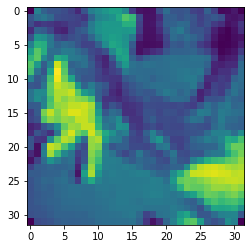

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([-0.1569, -4.6910,  2.1134,  0.8387,  0.4616,  0.4678, -1.7223,  0.5183,
         2.0582, -0.3138], grad_fn=<SelectBackward0>)


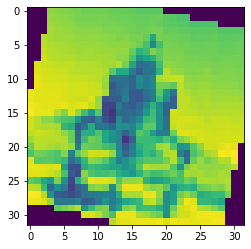

tensor([[-1.0000,  0.2706,  0.2471,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.2784,  0.2627,  ...,  0.2392,  0.2471,  0.2235],
        [-1.0000,  0.2863,  0.2627,  ...,  0.2235,  0.2235,  0.2078],
        ...,
        [-0.0353, -0.0431, -0.0118,  ...,  0.1137,  0.0824, -1.0000],
        [-0.0588, -0.1529, -0.0588,  ...,  0.1059,  0.0902, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0039, -0.0745, -1.0000]]) tensor(7)
tensor([ 1.6404, -3.7625,  0.1839,  0.7550,  1.7709,  2.2727, -3.9987,  3.7925,
        -2.0729, -1.0822], grad_fn=<SelectBackward0>)


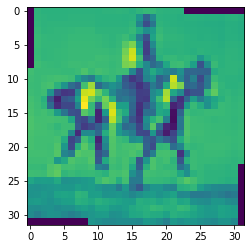

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3255, -0.4118, -1.0000],
        [-0.4275, -0.2471, -0.0980,  ..., -0.2627, -0.4353, -1.0000],
        [-0.4118, -0.3020, -0.1922,  ..., -0.3020, -0.5373, -1.0000],
        ...,
        [-1.0000,  0.5765,  0.5529,  ...,  0.5608,  0.5608,  0.5529],
        [-1.0000,  0.5765,  0.5451,  ...,  0.5608,  0.5608,  0.5529],
        [-1.0000,  0.6000,  0.5686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 0.9135,  7.8792, -3.0501, -2.3959, -2.5099, -3.7238, -1.6976, -3.4588,
         1.2742,  6.4737], grad_fn=<SelectBackward0>)


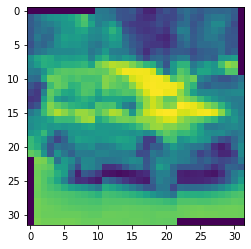

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.5373, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5059, -1.0000, -1.0000],
        [ 0.5216,  0.5137,  0.5059,  ...,  0.4980, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3098,  ...,  0.1608,  0.2157,  0.2471],
        [-1.0000, -1.0000, -0.5216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8353,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.0670,  2.5047, -0.5442, -0.5729, -1.3375, -1.2909, -2.2599, -0.2302,
        -1.0019,  3.6666], grad_fn=<SelectBackward0>)


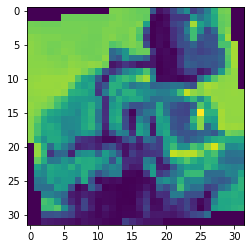

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 3.7872,  0.4409,  0.2247, -0.9779, -0.3409, -3.3377, -3.1603, -3.4896,
         5.2378,  0.2089], grad_fn=<SelectBackward0>)


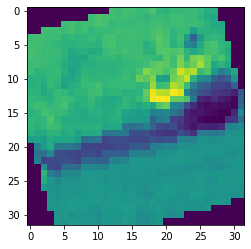

tensor([[-1.0000, -1.0000, -0.7804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7647,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7490,  ..., -0.7961, -0.7647, -0.6549],
        ...,
        [ 0.0745,  0.0118, -0.0118,  ..., -0.8667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8431, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8431, -1.0000, -1.0000]]) tensor(4)
tensor([-2.0691, -2.8522,  1.2163,  1.9205,  3.2016,  1.6418,  1.8746,  1.0072,
        -3.1847, -3.2367], grad_fn=<SelectBackward0>)


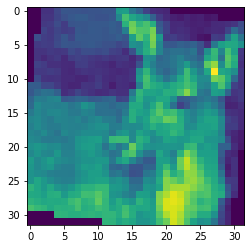

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3255, -1.0000, -1.0000],
        [ 0.1529,  0.3333,  0.4902,  ...,  0.3569, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1922,  ..., -0.2706, -0.2471, -0.2392],
        [-1.0000, -1.0000,  0.1216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2157,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-1.9884, -4.5385,  0.7637,  2.7464,  1.7208,  3.0012,  0.3343,  2.0289,
        -2.7752, -1.4166], grad_fn=<SelectBackward0>)


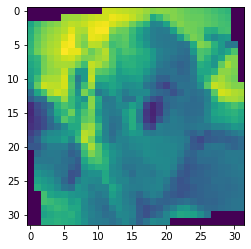

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.9330,  5.8045, -1.6721, -1.3587, -1.3751, -3.9660, -1.8245, -3.5415,
         0.4278,  4.0519], grad_fn=<SelectBackward0>)


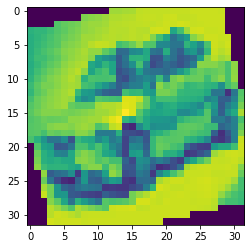

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.2386, -1.3653,  2.6228,  0.0672,  4.4050,  0.3130, -0.4312,  1.3622,
        -2.3361, -4.2373], grad_fn=<SelectBackward0>)


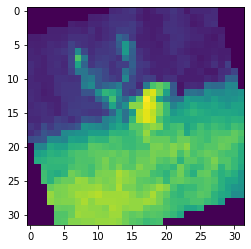

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0824,  ...,  0.2549, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.1294,  ..., -0.1529, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.2052,  2.2491, -1.5616, -0.1905, -0.6787, -1.6430,  1.6519, -3.2066,
         0.5269,  3.0686], grad_fn=<SelectBackward0>)


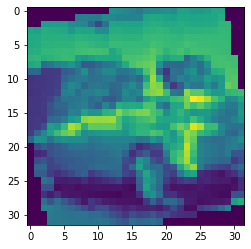

tensor([[-1.0000, -1.0000, -0.8431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8353,  ...,  0.2627, -1.0000, -1.0000],
        [-1.0000, -0.8118, -0.8118,  ...,  0.2627,  0.3490, -0.0431],
        ...,
        [-0.8118, -0.8980, -0.7255,  ...,  0.5451,  0.5451, -1.0000],
        [-1.0000, -1.0000, -0.7255,  ...,  0.6863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6863, -1.0000, -1.0000]]) tensor(3)
tensor([-1.0241, -0.7608,  1.1203,  1.7283,  1.7871,  0.8817, -1.1348,  0.3275,
        -1.7776, -1.8966], grad_fn=<SelectBackward0>)


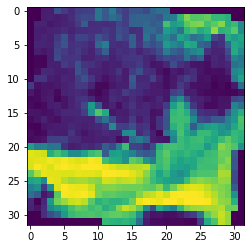

tensor([[-1.0000, -1.0000,  0.2706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.2235,  0.2078,  ...,  0.8980,  0.9294, -1.0000],
        [-1.0000,  0.1765,  0.2235,  ...,  0.6314,  0.5686,  0.9765],
        ...,
        [ 0.5451,  0.5765,  0.5373,  ..., -0.3333, -0.3098, -1.0000],
        [-1.0000,  0.5686,  0.5529,  ..., -0.2706, -0.2549, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -1.0000, -1.0000]]) tensor(1)
tensor([-0.5559,  1.3533,  0.6274,  0.8251, -2.4794,  0.4517, -1.6450, -0.0822,
        -1.5853,  3.8871], grad_fn=<SelectBackward0>)


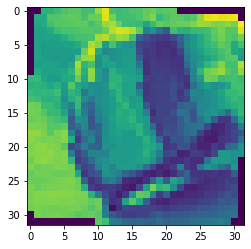

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4353, -1.0000, -1.0000],
        [ 0.6078,  0.6392,  0.5843,  ...,  0.4667, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3569,  ...,  0.0980,  0.3333,  0.4431],
        [-1.0000, -1.0000,  0.4745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2392,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.1197, -4.3739,  2.6073,  1.3704,  2.4583,  1.3871,  1.3789,  1.2710,
        -2.4953, -3.1606], grad_fn=<SelectBackward0>)


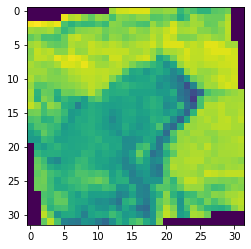

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.6784, -1.0000],
        [-0.8902, -0.8902, -0.8902,  ..., -0.9843, -0.6784, -1.0000],
        [-1.0000, -1.0000, -0.9608,  ..., -1.0000, -0.7333, -1.0000],
        ...,
        [-1.0000, -0.9529, -0.9373,  ..., -0.9373, -0.9529, -1.0000],
        [-1.0000, -0.9765, -0.9922,  ..., -1.0000, -0.9765, -1.0000],
        [-1.0000, -0.9608, -0.9843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([-2.6760, -3.5932,  0.7161,  3.6473, -0.6364,  3.7393,  0.9142,  0.5108,
        -0.4817, -2.3306], grad_fn=<SelectBackward0>)


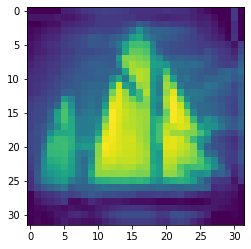

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 0.6163, -0.5942, -0.1482,  0.1107, -0.9312, -1.3882, -0.6113, -2.5359,
         4.2107,  1.7802], grad_fn=<SelectBackward0>)


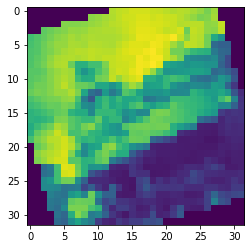

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.9128,  0.8066, -1.2419,  0.0954, -0.7822,  0.2487, -3.4148,  0.1900,
         1.0853,  2.2872], grad_fn=<SelectBackward0>)


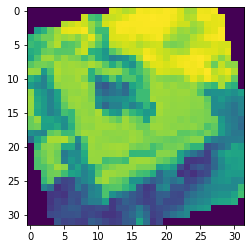

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.8609,  1.3010, -1.3467, -0.4032, -0.0738, -0.3466,  0.1925, -0.5840,
        -0.9416,  2.9495], grad_fn=<SelectBackward0>)


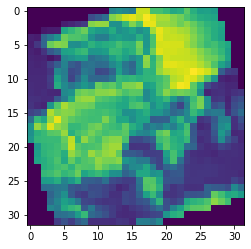

tensor([[-1.0000, -1.0000,  0.6627,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4588,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3961,  ..., -0.4902, -0.5216, -0.5608],
        ...,
        [ 0.5059,  0.5216,  0.5137,  ...,  0.3255, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3490, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3804, -1.0000, -1.0000]]) tensor(9)
tensor([-0.4242, -0.9882,  0.4680,  0.1069,  0.8874, -0.3282, -0.6277, -0.0523,
         0.3948,  0.7007], grad_fn=<SelectBackward0>)


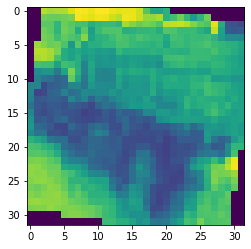

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-3.0290, -3.3609,  1.0510,  1.8456,  4.6493,  2.3492, -0.5779,  6.4552,
        -7.3079, -2.2002], grad_fn=<SelectBackward0>)


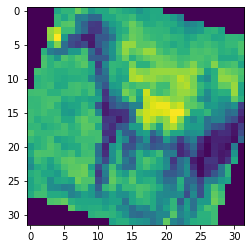

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-1.1888, -2.2309, -0.2352,  1.3664,  0.4537,  1.5394,  0.8024,  0.8255,
        -1.4219,  0.0308], grad_fn=<SelectBackward0>)


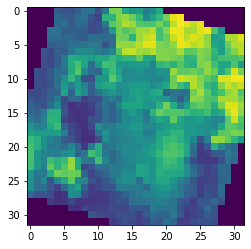

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.3774, -2.4468, -0.3890,  3.5138, -0.9509,  3.1691, -0.7875,  0.0679,
        -2.0298, -0.7322], grad_fn=<SelectBackward0>)


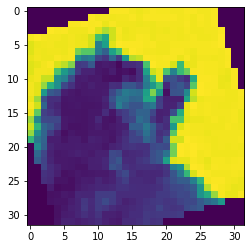

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9686,  ...,  0.9843, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9294,  ...,  0.9922, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.5449, -3.8770,  1.2507,  1.8580,  0.9255,  0.9864,  3.2636, -0.2142,
        -1.5017, -1.1247], grad_fn=<SelectBackward0>)


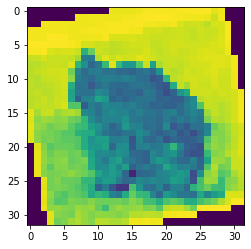

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7569,  ..., -0.5294, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0431,  ..., -0.5608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-1.1573, -2.4503,  0.7909,  2.7295,  2.0546,  2.9993, -2.3120,  1.9510,
        -2.6863, -1.9622], grad_fn=<SelectBackward0>)


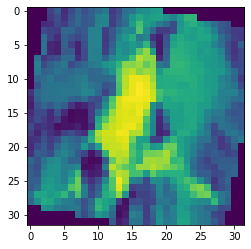

tensor([[-1.0000,  0.1529,  0.1451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.1843,  0.1843,  ...,  0.1373,  0.1294,  0.1216],
        [-1.0000,  0.2235,  0.2235,  ...,  0.1373,  0.1373,  0.1373],
        ...,
        [ 0.5137,  0.5059,  0.5294,  ...,  0.6627,  0.6706, -1.0000],
        [ 0.5843,  0.5686,  0.5686,  ...,  0.6627,  0.6627, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6549,  0.6706, -1.0000]]) tensor(9)
tensor([ 0.6978, -0.4729, -0.1757,  0.8225, -0.9472,  0.0455, -2.3598,  0.6420,
        -1.4851,  3.3688], grad_fn=<SelectBackward0>)


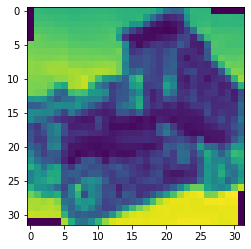

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.0039, -0.7719,  1.3802, -0.7180,  2.6627, -1.2744,  5.2693, -0.7316,
        -2.6654, -2.3993], grad_fn=<SelectBackward0>)


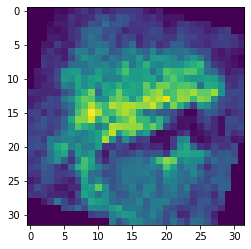

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.9765, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9294, -1.0000, -1.0000],
        [ 0.9765,  0.9765,  0.9765,  ...,  0.9294, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0745,  ..., -0.6941, -0.6941, -0.5137],
        [-1.0000, -1.0000, -0.0745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3098,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.1453, -0.4648, -0.4713, -0.0834,  1.3048, -1.3594, -3.5178, -0.5411,
         1.3299,  1.4303], grad_fn=<SelectBackward0>)


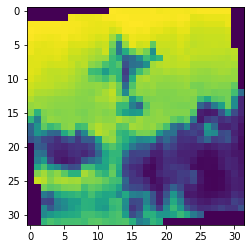

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2863, -0.6157, -1.0000],
        [-0.3882, -0.2549, -0.4039,  ..., -0.1608, -0.4510, -1.0000],
        [-0.3098, -0.2392, -0.3961,  ...,  0.0510, -0.3176, -1.0000],
        ...,
        [-1.0000,  0.6471,  0.7098,  ...,  0.2000, -0.0824, -0.5922],
        [-1.0000,  0.5686,  0.6314,  ...,  0.1137, -0.2000, -0.6314],
        [-1.0000,  0.5686,  0.6471,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.8001, -2.2116,  2.2199,  0.9695,  3.2191,  0.2449,  1.4646, -0.3669,
        -2.3887, -2.5090], grad_fn=<SelectBackward0>)


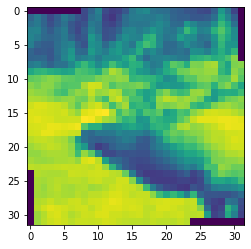

tensor([[-1.0000, -0.8588, -0.8353,  ..., -0.8196, -0.8118, -1.0000],
        [-0.8667, -0.8510, -0.8431,  ..., -0.8196, -0.8275, -0.8196],
        [-0.8588, -0.8431, -0.8353,  ..., -0.7961, -0.8196, -0.7961],
        ...,
        [-0.1608, -0.0196,  0.1373,  ...,  0.0039,  0.0902,  0.1451],
        [-0.1529, -0.1216, -0.1137,  ...,  0.0431, -0.0275, -0.2000],
        [-1.0000, -0.2000, -0.1843,  ..., -0.0039, -0.0353, -1.0000]]) tensor(5)
tensor([-1.4991, -4.2683,  0.0857,  4.6575, -1.7427,  7.8013, -2.1568,  1.4231,
        -1.0317, -2.8581], grad_fn=<SelectBackward0>)


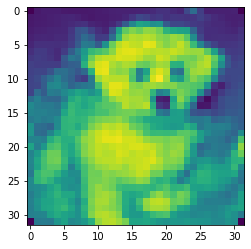

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4588, -1.0000, -1.0000],
        [ 0.5451,  0.5843,  0.6000,  ...,  0.4510, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4588,  ..., -0.2471, -0.2627, -0.2784],
        [-1.0000, -1.0000, -0.4588,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.4588,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.0718,  0.8883, -0.2700, -0.2597,  0.1774, -1.4828, -0.9696, -1.2076,
         0.9514,  1.1485], grad_fn=<SelectBackward0>)


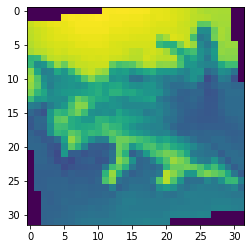

tensor([[ 0.0118,  0.0431,  0.0118,  ..., -0.1294, -0.0196, -0.0118],
        [ 0.0118,  0.0431,  0.0510,  ..., -0.0980, -0.0118, -0.0588],
        [ 0.0196,  0.0118,  0.0588,  ...,  0.0510,  0.1137,  0.0980],
        ...,
        [ 0.2078,  0.1373,  0.2235,  ...,  0.3490,  0.3412,  0.2549],
        [ 0.2314,  0.2549,  0.2392,  ...,  0.3412,  0.3098,  0.2627],
        [ 0.0980,  0.2157,  0.2471,  ...,  0.3412,  0.3255,  0.2863]]) tensor(2)
tensor([-1.1992, -3.2316,  1.1638,  2.4621,  2.0007,  2.4969,  0.8824,  0.5774,
        -2.7727, -2.8033], grad_fn=<SelectBackward0>)


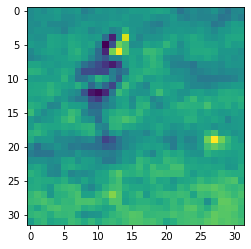

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-1.0928,  0.6965, -0.8690,  1.2301, -1.3728,  0.6713,  0.2010, -0.3840,
        -1.2398,  3.0133], grad_fn=<SelectBackward0>)


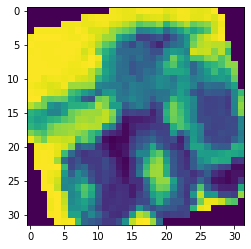

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.9216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -1.0000, -1.0000],
        [-0.8510, -0.8196, -0.7961,  ..., -0.8824, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4196,  ..., -0.3490, -0.3176, -0.3725],
        [-1.0000, -1.0000, -0.3647,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3490,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-0.3764, -6.1699,  0.7274,  4.8691, -0.4096,  5.8633, -2.5694,  1.4830,
         1.3091, -4.4386], grad_fn=<SelectBackward0>)


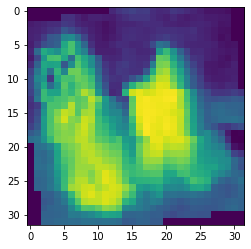

tensor([[-0.4824, -0.4667, -0.4510,  ..., -0.4196, -0.4431, -0.4745],
        [-0.4353, -0.4039, -0.3961,  ..., -0.4275, -0.4510, -0.4667],
        [-0.4275, -0.3725, -0.3333,  ..., -0.4118, -0.4353, -0.4353],
        ...,
        [-0.0745, -0.0980, -0.0196,  ..., -0.7569, -0.7333, -0.7569],
        [-0.1843, -0.0980, -0.0588,  ..., -0.1294, -0.0588, -0.1059],
        [-0.1922, -0.1294, -0.0902,  ..., -0.0588, -0.0824, -0.0510]]) tensor(0)
tensor([ 4.6351,  6.2748, -0.8865, -4.1914, -0.1400, -5.4133, -3.7952, -2.1085,
        -0.3736,  5.4013], grad_fn=<SelectBackward0>)


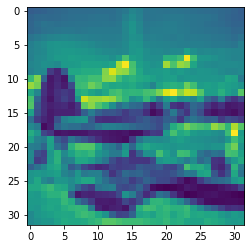

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 3.3399,  0.9169,  0.1434, -1.4782,  0.4007, -3.1187, -1.3279, -1.4815,
         1.2762,  1.3830], grad_fn=<SelectBackward0>)


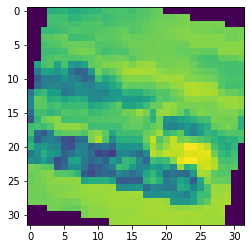

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.6941, -0.5529, -1.0000],
        [-0.1843, -0.0588, -0.0275,  ..., -0.5922, -0.4275, -1.0000],
        [ 0.0118,  0.0275,  0.0039,  ..., -0.1608, -0.3333, -1.0000],
        ...,
        [-1.0000,  0.2235,  0.6627,  ...,  0.1529,  0.0824,  0.2941],
        [-1.0000,  0.4510,  0.7255,  ..., -0.0588, -0.1373,  0.1451],
        [-1.0000,  0.4118,  0.7098,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-2.2281, -4.6115,  1.3598,  3.9936,  1.8254,  3.3262,  2.6951,  0.5149,
        -4.0582, -3.7389], grad_fn=<SelectBackward0>)


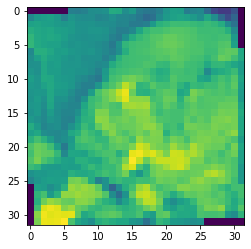

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.9765, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9529, -1.0000, -1.0000],
        [ 0.9843,  0.9843,  0.9843,  ...,  0.6392, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3804,  ...,  0.9843,  0.9843,  0.9843],
        [-1.0000, -1.0000,  0.7412,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9765,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.5732,  2.3850, -1.2073, -0.5059, -0.0149, -1.5465, -3.0860, -0.5646,
        -0.5555,  3.4519], grad_fn=<SelectBackward0>)


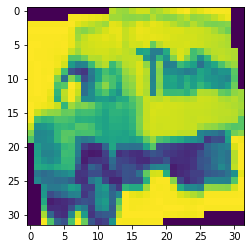

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.5258,  3.5572,  0.0649, -0.6369, -1.8455, -1.7296, -1.6634, -0.2659,
         0.5182,  1.8066], grad_fn=<SelectBackward0>)


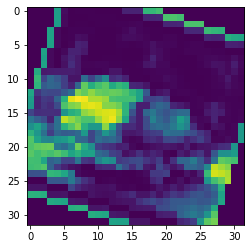

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 3.5642,  5.4622, -2.1341, -2.6561, -1.4009, -3.7721, -3.4276, -1.3467,
         0.2079,  4.9556], grad_fn=<SelectBackward0>)


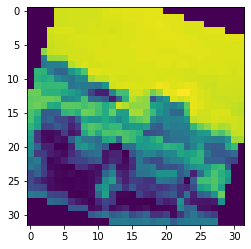

tensor([[-1.0000,  0.9765,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.8980,  0.9294,  ...,  0.0902,  0.0824,  0.0039],
        [-1.0000,  0.9294,  0.9608,  ..., -0.2706, -0.2471, -0.2941],
        ...,
        [-0.1294, -0.4196, -0.5922,  ..., -0.6235, -0.3020, -1.0000],
        [ 0.2549,  0.0275, -0.1373,  ..., -0.6078, -0.3098, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5765, -0.3098, -1.0000]]) tensor(9)
tensor([-0.8712, -0.4427, -0.4063,  1.0247, -0.0857,  0.5272, -1.2955,  0.5499,
        -0.5781,  2.1172], grad_fn=<SelectBackward0>)


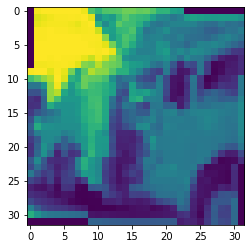

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.0132, -4.1675,  2.4537,  1.6498,  3.1775,  2.1377,  1.3423,  0.5442,
        -2.8869, -3.8008], grad_fn=<SelectBackward0>)


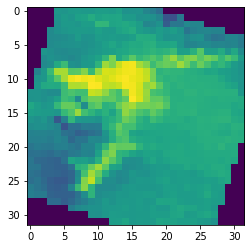

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-2.5047, -2.3471,  0.0759,  1.8256,  1.7906,  1.5132,  2.8073,  1.0380,
        -2.2821, -1.9003], grad_fn=<SelectBackward0>)


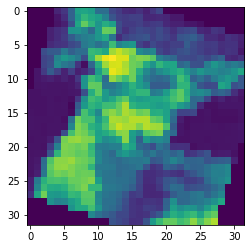

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5765, -1.0000, -1.0000],
        [-1.0000, -0.6549, -0.6784,  ..., -0.5686, -0.5373, -1.0000],
        [-0.6471, -0.6157, -0.5922,  ..., -0.5765, -0.5529, -1.0000],
        ...,
        [-1.0000, -0.2627, -0.2078,  ..., -0.1216, -0.0275, -0.1059],
        [-1.0000, -0.2235, -0.1765,  ..., -0.1373, -0.1451, -1.0000],
        [-1.0000, -1.0000, -0.2863,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-0.5436,  2.0275, -0.6059, -1.3114,  0.5252, -0.2448,  2.2328, -0.4893,
        -2.8204,  0.8130], grad_fn=<SelectBackward0>)


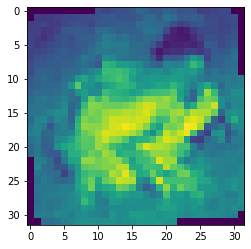

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.0828e+00, -3.6883e+00,  4.6816e-01,  2.6240e+00,  3.4200e-01,
         3.6519e+00, -8.3056e-01,  7.5949e-01,  3.3666e-03, -2.0644e+00],
       grad_fn=<SelectBackward0>)


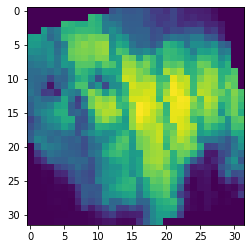

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-1.1045, -1.5552,  0.6706,  0.2690,  2.3939,  0.9262, -1.3563,  5.3047,
        -4.0138, -1.4240], grad_fn=<SelectBackward0>)


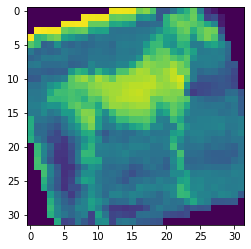

tensor([[-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ...,  1., -1., -1.]]) tensor(0)
tensor([ 4.1093, -1.1601,  0.9461, -0.2049,  0.6575, -1.6327, -0.5688, -1.7085,
        -0.2063, -0.8637], grad_fn=<SelectBackward0>)


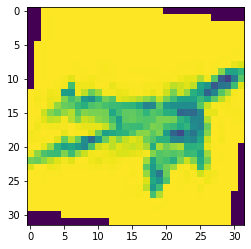

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.1200, -2.5974,  0.6657,  1.3727,  0.5614,  0.5147,  2.3655, -1.2158,
        -0.4455,  0.3104], grad_fn=<SelectBackward0>)


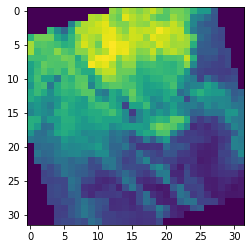

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.1922, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1686, -1.0000, -1.0000],
        [-0.7020, -0.7333, -0.3804,  ...,  0.1765, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.1451,  ..., -0.1216, -0.1451, -0.1216],
        [-1.0000, -1.0000, -0.0902,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1294,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.7880, -2.4073,  0.9655,  0.5910,  2.9099,  0.2142,  4.8681,  1.7169,
        -5.4339, -1.7135], grad_fn=<SelectBackward0>)


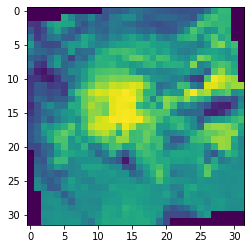

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3333,  0.3333, -1.0000],
        [-0.4353, -0.2392, -0.1922,  ...,  0.2549,  0.2706, -1.0000],
        [-0.5216, -0.4039, -0.2235,  ..., -0.0431,  0.0431, -1.0000],
        ...,
        [-1.0000,  0.9137,  0.9216,  ...,  0.9843,  0.9843,  0.9843],
        [-1.0000,  0.9216,  0.9216,  ...,  1.0000,  1.0000,  0.9922],
        [-1.0000,  0.8980,  0.9059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-2.2552,  0.6560, -1.6836,  1.3990,  1.2434,  1.2932, -1.4090,  2.0634,
        -3.5658,  2.4073], grad_fn=<SelectBackward0>)


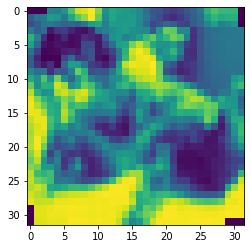

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([-0.1335, -3.9436,  1.1750,  1.3692,  1.5623,  1.6433, -0.5151, -0.0772,
         0.6279, -2.0049], grad_fn=<SelectBackward0>)


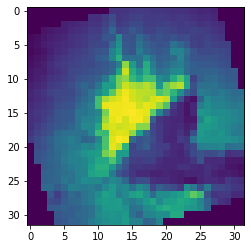

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3098, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3020, -1.0000, -1.0000],
        [-0.0588,  0.0588,  0.3255,  ..., -0.2471, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0902,  ...,  0.1529,  0.0667, -0.1608],
        [-1.0000, -1.0000, -0.0039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0902,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-0.3227, -1.8835,  0.4015,  0.3232,  1.9803,  0.7349,  2.5860, -0.3992,
        -3.4458, -0.7489], grad_fn=<SelectBackward0>)


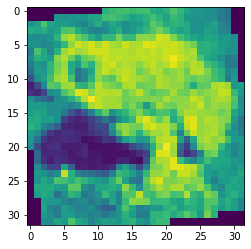

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0902, -0.1294, -1.0000],
        [-0.0667, -0.0980, -0.1216,  ..., -0.1373, -0.1059, -1.0000],
        [ 0.0039, -0.1059, -0.1059,  ..., -0.1216, -0.0667, -1.0000],
        ...,
        [-1.0000,  0.1686,  0.3255,  ..., -0.9294, -0.9294, -0.9216],
        [-1.0000,  0.2784,  0.3647,  ..., -0.9216, -0.9294, -0.9216],
        [-1.0000,  0.1922,  0.3255,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.1502, -1.2989,  0.4652,  1.3583,  0.3380,  0.6397, -0.8046,  0.7458,
        -0.1851, -0.9375], grad_fn=<SelectBackward0>)


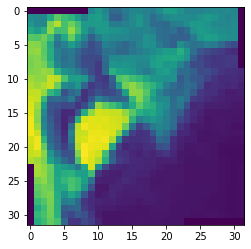

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4039,  ..., -0.0039, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  1.0000,  ...,  0.9608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.5270, -4.2418,  0.8713,  2.0076,  4.4253,  2.6719, -3.2761,  8.5952,
        -6.1795, -3.1818], grad_fn=<SelectBackward0>)


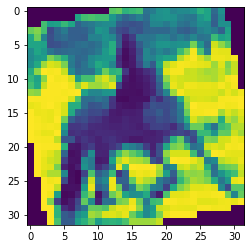

tensor([[ 0.0824,  0.0824,  0.1294,  ...,  0.0431,  0.0118, -0.0431],
        [ 0.0275,  0.0510,  0.0824,  ..., -0.1294, -0.2000, -0.2157],
        [-0.0039,  0.0118,  0.0510,  ..., -0.1922, -0.2078, -0.2000],
        ...,
        [ 0.0588,  0.0196,  0.0824,  ..., -0.1373,  0.0588, -0.0824],
        [ 0.0745,  0.0667,  0.0745,  ..., -0.5059, -0.1922, -0.1216],
        [ 0.0588,  0.0745,  0.1216,  ..., -0.4667, -0.4118, -0.1608]]) tensor(2)
tensor([-0.8226, -2.1145,  3.9690,  0.2628,  3.8605,  1.1672,  0.9449,  0.2611,
        -5.0237, -2.9516], grad_fn=<SelectBackward0>)


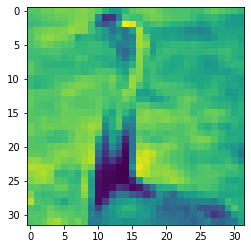

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.7569,  0.7725, -1.0000],
        [ 0.7490,  0.7647,  0.7412,  ...,  0.7647,  0.8039, -1.0000],
        [ 0.7255,  0.7412,  0.7569,  ...,  0.5686,  0.6706, -1.0000],
        ...,
        [-1.0000,  0.0353, -0.0824,  ..., -0.3333, -0.2157, -0.1843],
        [-1.0000,  0.1137,  0.0118,  ..., -0.2706, -0.1529, -0.0980],
        [-1.0000,  0.0118,  0.0824,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.1282, -2.6252,  0.7678, -0.1927,  3.1011,  1.0214, -1.1967,  6.3562,
        -5.6552, -0.2296], grad_fn=<SelectBackward0>)


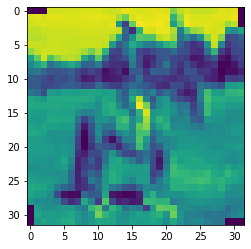

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 1.4808e+00, -7.5032e-01,  1.4767e+00, -7.5094e-01,  8.4888e-01,
        -1.1089e+00, -9.3794e-04, -9.9417e-02, -9.4656e-01, -1.9589e-01],
       grad_fn=<SelectBackward0>)


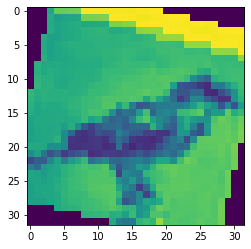

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 1.5233, -4.7488,  5.0051,  0.2282,  2.7514,  0.1225,  0.0945, -0.3343,
        -1.3117, -4.2352], grad_fn=<SelectBackward0>)


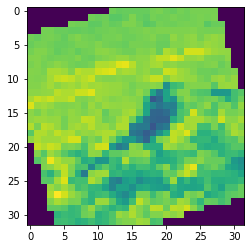

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.6866, -4.2659,  0.9036,  3.1874, -0.7079,  3.1473,  2.7309, -0.1781,
        -2.3574, -1.1952], grad_fn=<SelectBackward0>)


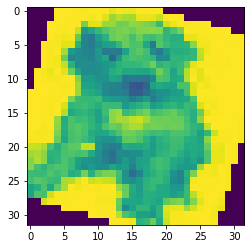

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3647, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3333, -1.0000, -1.0000],
        [-0.5216, -0.5059, -0.4902,  ..., -0.3961, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4196,  ..., -0.5922, -0.7020, -0.5843],
        [-1.0000, -1.0000, -0.5686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-0.7325, -2.8134,  3.1214,  0.0463,  3.3488, -0.0148,  2.8878, -1.2368,
        -1.9563, -2.9858], grad_fn=<SelectBackward0>)


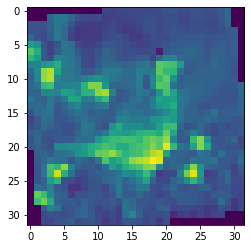

tensor([[-0.2157, -0.2941, -0.3882,  ..., -0.1922, -0.1922, -0.2078],
        [-0.1843, -0.3020, -0.3882,  ..., -0.2000, -0.2000, -0.2078],
        [-0.1843, -0.2941, -0.3725,  ..., -0.2000, -0.2078, -0.2078],
        ...,
        [-0.3412, -0.3569, -0.3569,  ..., -0.5216, -0.4667, -0.4745],
        [-0.3412, -0.3412, -0.3255,  ..., -0.5765, -0.5529, -0.5451],
        [-0.3412, -0.3333, -0.3255,  ..., -0.5765, -0.4431, -0.3490]]) tensor(5)
tensor([-0.7768, -2.5703,  1.1938,  2.2090,  0.0570,  1.8566, -0.3133,  1.1480,
        -1.7529, -0.7911], grad_fn=<SelectBackward0>)


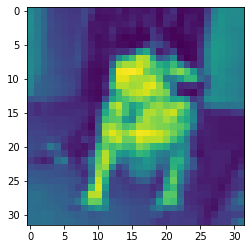

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.4453, -1.3929, -0.1503, -0.0857,  1.5069,  0.5027, -1.7229,  2.3066,
        -1.1655,  1.2176], grad_fn=<SelectBackward0>)


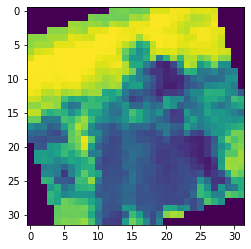

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6314,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6000,  ..., -0.6549, -0.6471, -1.0000],
        ...,
        [-1.0000, -0.5765, -0.5451,  ..., -0.8510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-0.5630, -0.7855,  1.4091,  1.5689,  0.3107,  1.1455, -0.6938,  0.4893,
        -1.6084, -1.1310], grad_fn=<SelectBackward0>)


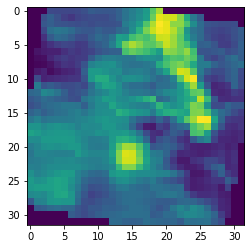

tensor([[-1.0000, -0.3647, -0.3725,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.4510, -0.4824,  ..., -0.3490, -0.3804, -0.4824],
        [-1.0000, -0.5216, -0.5294,  ..., -0.2000, -0.3098, -0.4588],
        ...,
        [-0.3569, -0.2941, -0.2627,  ..., -0.4667, -0.5137, -1.0000],
        [-0.3725, -0.2706, -0.2078,  ..., -0.4667, -0.4667, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4118, -0.4667, -1.0000]]) tensor(3)
tensor([-2.1015, -4.1338,  2.4495,  3.0318,  1.8199,  4.7560, -1.2507,  1.4992,
        -2.5652, -3.6802], grad_fn=<SelectBackward0>)


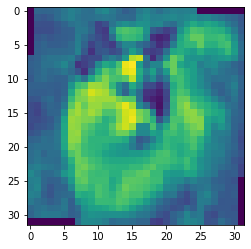

tensor([[-1.0000, -1.0000, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2471,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1686,  ...,  0.6392,  0.6000,  0.4902],
        ...,
        [ 0.5294,  0.4902,  0.1686,  ..., -0.7176, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6706, -1.0000, -1.0000]]) tensor(7)
tensor([-1.8388, -2.4340,  1.3563,  1.7544,  1.9970,  1.6702,  1.0771,  1.4082,
        -3.7657, -1.1141], grad_fn=<SelectBackward0>)


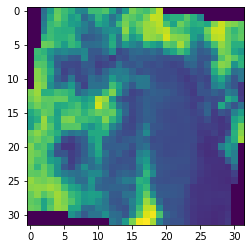

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.9514, -3.0031,  0.6051,  3.1753,  2.1586,  2.8830, -0.8916,  0.5945,
        -2.5797, -2.1885], grad_fn=<SelectBackward0>)


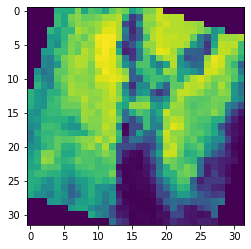

tensor([[-1.0000,  0.5059,  0.5059,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5059,  0.5059,  ...,  0.4980,  0.4667,  0.5059],
        [-1.0000,  0.4980,  0.4980,  ...,  0.4980,  0.4667,  0.5059],
        ...,
        [-0.4902, -0.4902, -0.1529,  ...,  0.4196,  0.4196, -1.0000],
        [-0.5059, -0.3176, -0.0118,  ...,  0.4588,  0.4667, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4510,  0.4667, -1.0000]]) tensor(7)
tensor([-0.5850, -2.3189,  1.2230,  0.8411,  1.2997,  2.0788, -0.2482,  1.9618,
        -3.1769, -1.5394], grad_fn=<SelectBackward0>)


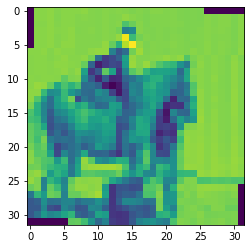

tensor([[-0.9608, -0.9451, -0.9294,  ..., -0.8667, -0.8667, -0.8510],
        [-0.9765, -0.9529, -0.9216,  ..., -0.8588, -0.8588, -0.8353],
        [-0.9843, -0.9608, -0.9294,  ..., -0.8431, -0.8275, -0.8196],
        ...,
        [ 0.2784,  0.2392, -0.0275,  ..., -0.8902, -0.8824, -0.8745],
        [ 0.1686,  0.2392,  0.0275,  ..., -0.8902, -0.8824, -0.8745],
        [ 0.0353,  0.1529,  0.2941,  ..., -0.8980, -0.8824, -0.8745]]) tensor(8)
tensor([ 1.3147, -1.4038, -0.1926,  1.2985,  0.8732,  0.5705, -1.8890,  1.1968,
         0.8971, -2.2688], grad_fn=<SelectBackward0>)


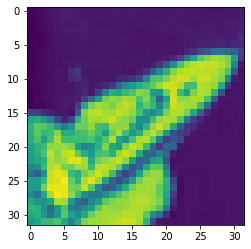

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.7569, -0.7569, -1.0000],
        [-0.7569, -0.7569, -0.7569,  ..., -0.7882, -0.7569, -1.0000],
        [-0.8196, -0.8196, -0.8039,  ..., -0.7961, -0.7412, -1.0000],
        ...,
        [-1.0000,  0.4510,  0.4745,  ...,  0.6078,  0.6157,  0.5843],
        [-1.0000,  0.5059,  0.5686,  ...,  0.6157,  0.6235,  0.5843],
        [-1.0000,  0.5059,  0.5059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-2.1348, -1.5656, -0.5345,  1.3756,  1.9245,  0.7937,  3.1896,  1.0986,
        -3.2471, -0.8890], grad_fn=<SelectBackward0>)


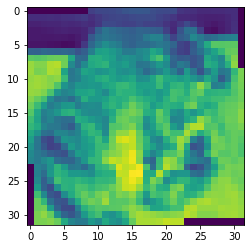

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-1.9645,  0.1185, -0.4527, -0.6570,  3.2649,  0.7971, -1.5893,  4.5169,
        -4.0729,  0.3396], grad_fn=<SelectBackward0>)


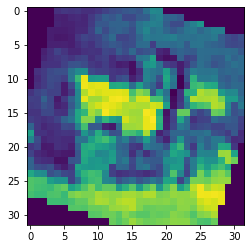

tensor([[-1.0000, -1.0000,  0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4039,  ...,  0.4667,  0.4667,  0.5059],
        ...,
        [ 0.4431,  0.4431,  0.4431,  ...,  0.5294, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5294, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5373, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.1597, -3.1302,  1.9662,  0.2908,  1.5586, -0.5108, -0.8895, -0.9077,
        -0.8759, -1.8053], grad_fn=<SelectBackward0>)


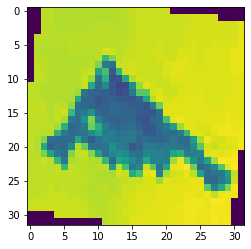

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.4104, -2.1350, -0.0179,  2.1891, -1.0123,  2.3513, -0.9572, -0.0380,
        -0.4929, -0.0114], grad_fn=<SelectBackward0>)


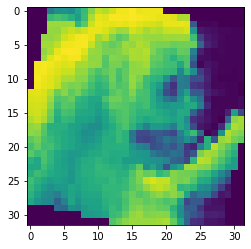

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3333, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1922, -1.0000, -1.0000],
        [ 0.4980,  0.5059,  0.5216,  ...,  0.2157, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0902,  ...,  0.0431,  0.0353,  0.0353],
        [-1.0000, -1.0000, -0.1373,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1608,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([-0.0832, -1.4042,  0.4907,  0.2990,  0.6371, -0.4957, -1.2866, -0.1166,
         1.1167,  0.7963], grad_fn=<SelectBackward0>)


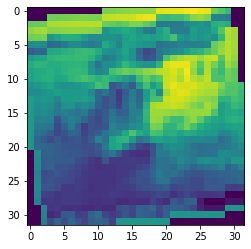

tensor([[-1.0000, -0.6078, -0.5765,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.6157, -0.5373,  ..., -0.3882, -0.5059, -0.4588],
        [-1.0000, -0.5137, -0.5216,  ..., -0.3020, -0.4588, -0.4667],
        ...,
        [-0.2863, -0.3255, -0.2784,  ..., -0.5608, -0.5294, -1.0000],
        [-0.4745, -0.4275, -0.3961,  ..., -0.4353, -0.5451, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2706, -0.5059, -1.0000]]) tensor(4)
tensor([-2.2234, -2.1154,  0.7921,  1.4020,  2.2972,  0.7440,  4.1534, -0.6435,
        -3.1642, -1.1351], grad_fn=<SelectBackward0>)


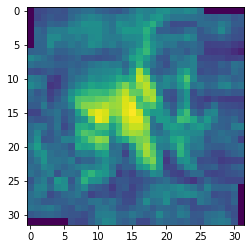

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-1.7547, -3.3829,  2.3058,  1.8547,  3.7262,  1.2447,  1.6671, -0.0285,
        -2.4668, -3.3854], grad_fn=<SelectBackward0>)


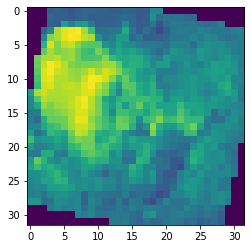

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3176, -1.0000, -1.0000],
        [-1.0000, -0.1922,  0.0431,  ..., -0.1843,  0.0118, -1.0000],
        [-0.3490,  0.0588,  0.1137,  ..., -0.1608,  0.0824, -1.0000],
        ...,
        [-1.0000,  0.4196,  0.4275,  ...,  0.2941,  0.3176,  0.3176],
        [-1.0000,  0.4196,  0.4353,  ...,  0.3255,  0.3176, -1.0000],
        [-1.0000, -1.0000,  0.4196,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 0.2965,  4.1727, -0.5221, -0.0196, -0.9680, -0.8569, -2.5934, -1.2677,
        -0.2241,  1.7306], grad_fn=<SelectBackward0>)


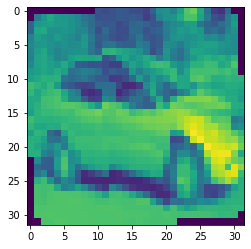

tensor([[-1.0000, -1.0000,  0.2784,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.2235,  0.2549,  ...,  0.3412,  0.3961, -1.0000],
        [-1.0000,  0.1922,  0.2863,  ...,  0.4039,  0.1529, -0.1216],
        ...,
        [-0.7961, -0.8039, -0.8353,  ...,  0.1922,  0.2314, -1.0000],
        [-1.0000, -0.8353, -0.8745,  ...,  0.1137,  0.1608, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0902, -1.0000, -1.0000]]) tensor(5)
tensor([-0.7324, -4.0032,  1.8817,  3.6135,  0.8913,  3.7849,  0.5595,  0.0116,
        -3.2692, -3.6294], grad_fn=<SelectBackward0>)


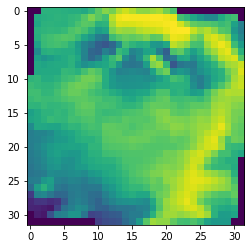

tensor([[ 0.1843,  0.1059, -0.0039,  ..., -0.0510, -0.0588, -0.3961],
        [-0.1529, -0.2157, -0.3412,  ..., -0.1608,  0.0431,  0.0588],
        [-0.1686, -0.2392, -0.4824,  ..., -0.1922, -0.0353, -0.0039],
        ...,
        [ 0.1765,  0.1216, -0.0510,  ...,  0.2863,  0.6941,  0.8902],
        [ 0.0824,  0.0588,  0.0588,  ...,  0.7725,  0.9059,  0.8980],
        [ 0.0510,  0.0667,  0.0980,  ...,  0.9137,  0.8902,  0.8902]]) tensor(1)
tensor([ 0.3284,  6.6766, -1.3108, -1.6128, -2.1091, -2.1899,  0.0084, -3.3726,
        -2.0877,  5.5608], grad_fn=<SelectBackward0>)


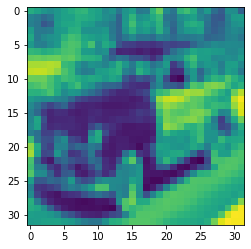

tensor([[-1.0000,  0.5608,  0.5451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5686,  0.5529,  ...,  0.4980,  0.4824,  0.4745],
        [-1.0000,  0.5765,  0.5608,  ...,  0.4980,  0.4824,  0.4745],
        ...,
        [ 0.1216,  0.1216,  0.0824,  ...,  0.6392,  0.6235, -1.0000],
        [ 0.0196,  0.0902,  0.0980,  ...,  0.6314,  0.6235, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5451,  0.6314, -1.0000]]) tensor(2)
tensor([ 3.1988e-02, -4.2637e+00,  3.1757e+00,  9.2172e-01,  1.1653e+00,
         9.1888e-01, -6.5116e-01,  9.8903e-02,  1.5289e-04, -1.8653e+00],
       grad_fn=<SelectBackward0>)


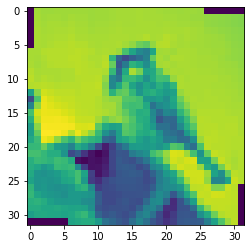

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 1.4879,  2.9047, -0.9414,  1.7802, -2.9627,  0.1587, -3.5672, -1.8213,
         3.3758, -0.1053], grad_fn=<SelectBackward0>)


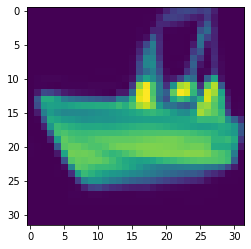

tensor([[-1.0000,  0.3255,  0.3333,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3255,  0.3333,  ...,  0.3490,  0.3490,  0.3490],
        [-1.0000,  0.3255,  0.3333,  ...,  0.3490,  0.3490,  0.3490],
        ...,
        [ 0.3725,  0.3882,  0.3882,  ...,  0.4275,  0.4275, -1.0000],
        [ 0.3804,  0.3882,  0.3882,  ...,  0.4510,  0.4431, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4431,  0.4431, -1.0000]]) tensor(0)
tensor([ 3.8532, -1.4700,  1.8183, -0.3743,  1.3297, -2.0646, -1.8296, -2.2464,
         0.3200, -1.2157], grad_fn=<SelectBackward0>)


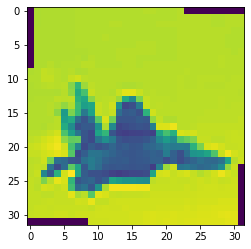

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-2.8036, -5.6830,  1.9309,  3.3414,  2.6984,  3.9363, -0.7649,  4.3078,
        -4.4146, -3.2521], grad_fn=<SelectBackward0>)


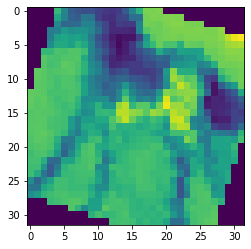

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.1137, -0.2000, -1.0000],
        [-0.6863, -0.6392, -0.5451,  ..., -0.1373, -0.2392, -1.0000],
        [-0.6157, -0.5294, -0.4588,  ..., -0.1216, -0.2392, -1.0000],
        ...,
        [-1.0000, -0.4275, -0.4431,  ..., -0.0431, -0.0431, -0.1059],
        [-1.0000, -0.5294, -0.4902,  ..., -0.2549, -0.2314, -0.1686],
        [-1.0000, -0.2157, -0.1922,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-0.5351, -3.0239,  1.5133,  1.2260,  0.9444,  1.8716, -0.7568,  0.5407,
        -1.1012, -0.5387], grad_fn=<SelectBackward0>)


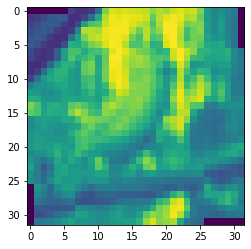

tensor([[-1.0000, -1.0000,  0.6706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.7647,  0.8902,  ...,  0.6784,  0.6863, -1.0000],
        [-1.0000,  0.8588,  0.9686,  ...,  0.8196,  0.7569,  0.6941],
        ...,
        [-0.2941, -0.2235, -0.6392,  ...,  0.8275,  0.7490, -1.0000],
        [-1.0000, -0.5529, -0.6706,  ...,  0.7098,  0.5608, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6392, -1.0000, -1.0000]]) tensor(9)
tensor([-0.7447,  1.4347, -2.1624,  0.2999, -1.3369, -1.2545,  0.0169, -0.9649,
         0.2966,  4.6937], grad_fn=<SelectBackward0>)


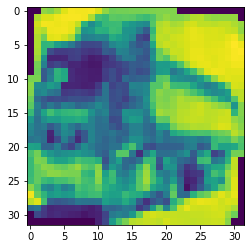

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.2455, -1.1213, -0.3344,  0.7170,  0.6800,  0.0548,  4.7040, -0.9256,
        -2.7771,  1.1763], grad_fn=<SelectBackward0>)


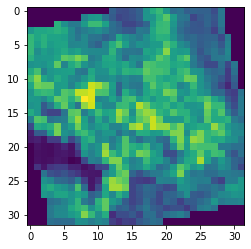

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.9922,  0.9922, -1.0000],
        [ 0.7882,  0.7961,  0.8039,  ...,  0.9765,  0.9765, -1.0000],
        [ 0.7961,  0.8039,  0.8118,  ...,  0.9686,  0.8196, -1.0000],
        ...,
        [-1.0000, -0.1608, -0.1451,  ..., -0.2314, -0.2157, -0.2392],
        [-1.0000, -0.1608, -0.1451,  ..., -0.2392, -0.2471, -0.2235],
        [-1.0000, -0.1765, -0.1686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 1.3983,  1.2465, -0.1596, -0.7427, -0.6792, -3.1774, -1.5929, -3.3545,
         5.5332,  1.7015], grad_fn=<SelectBackward0>)


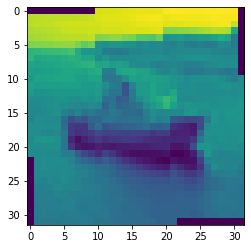

tensor([[-1.0000, -1.0000, -0.6471,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9137, -0.6863,  ..., -0.2471, -0.3255, -1.0000],
        [-1.0000, -0.5608, -0.7412,  ..., -0.6941, -0.6471, -0.4745],
        ...,
        [-0.3020,  0.0588,  0.0196,  ..., -0.0118,  0.1059, -1.0000],
        [-1.0000,  0.0196,  0.1137,  ..., -0.0510,  0.0275, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000]]) tensor(5)
tensor([-3.1736, -3.4869,  0.9695,  2.9122, -0.4602,  5.3074, -1.2864,  3.8639,
        -2.9716, -2.1019], grad_fn=<SelectBackward0>)


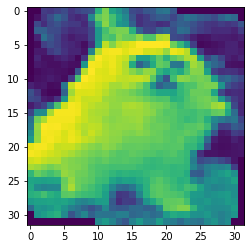

tensor([[-1.0000, -0.3255, -0.3961,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.4588, -0.4588,  ..., -0.1294, -0.1686, -0.1922],
        [-1.0000, -0.4902, -0.6000,  ..., -0.1059, -0.1216, -0.1373],
        ...,
        [-0.1059, -0.1059, -0.1137,  ...,  0.0431, -0.6471, -1.0000],
        [-0.0902, -0.1137, -0.1137,  ..., -0.0745, -0.6863, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6863, -0.8039, -1.0000]]) tensor(2)
tensor([ 0.5637, -1.1196,  0.9362,  0.2589,  1.0248, -0.4740, -0.0839,  0.1195,
        -1.3002, -0.1162], grad_fn=<SelectBackward0>)


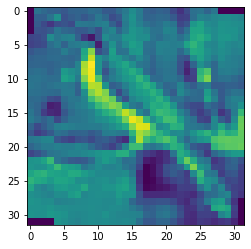

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2706, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2314, -1.0000, -1.0000],
        [ 0.4510,  0.3882,  0.4039,  ...,  0.2392, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.5529,  ..., -0.2941, -0.2314, -0.2078],
        [-1.0000, -1.0000,  0.2235,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2471,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.2776,  2.2664, -2.6126, -0.0995, -2.3091, -1.2739, -0.2994, -1.4601,
         0.2509,  5.6698], grad_fn=<SelectBackward0>)


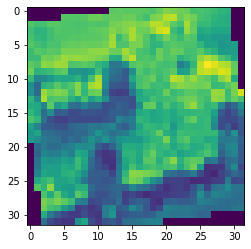

tensor([[-1.0000, -0.0431, -0.0353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.0431, -0.0353,  ...,  0.0980, -0.0039, -0.0745],
        [-1.0000, -0.0275, -0.0275,  ..., -0.0431, -0.1137, -0.1137],
        ...,
        [-0.0667,  0.0353,  0.1922,  ..., -0.4039, -0.4588, -1.0000],
        [ 0.2078,  0.2549,  0.1059,  ..., -0.3725, -0.4275, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3961, -0.4196, -1.0000]]) tensor(2)
tensor([-1.4914, -4.4054,  2.1782,  3.7723,  1.5874,  3.2447,  1.4312, -0.6463,
        -1.7549, -3.9900], grad_fn=<SelectBackward0>)


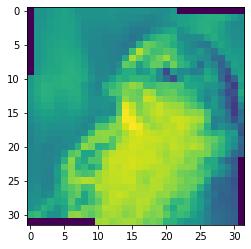

tensor([[-1.0000, -0.4745, -0.3490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.6706, -0.6000,  ..., -0.2000, -0.2941, -0.4118],
        [-1.0000, -0.5765, -0.7098,  ...,  0.1294, -0.0196, -0.2941],
        ...,
        [ 0.7098,  0.3647,  0.3098,  ..., -0.4902, -0.3647, -1.0000],
        [ 0.6863,  0.6627,  0.1373,  ..., -0.6235, -0.4667, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6235, -0.5843, -1.0000]]) tensor(6)
tensor([-2.3115e+00, -2.4120e+00,  2.4511e+00,  1.2682e+00,  3.3477e+00,
         4.1454e-01,  4.8978e+00, -3.8822e-03, -4.3894e+00, -3.0806e+00],
       grad_fn=<SelectBackward0>)


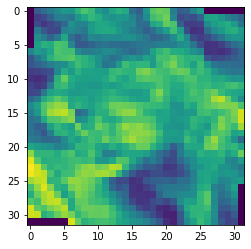

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 3.8491, -1.6000,  1.7606, -0.6555,  1.9927, -1.5607, -0.8731, -1.9960,
         0.0184, -1.8380], grad_fn=<SelectBackward0>)


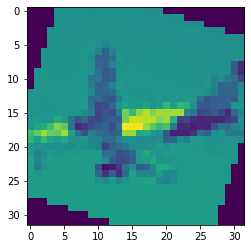

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 2.4366, -2.3160,  1.2718, -0.0586,  2.0115, -0.2684, -0.2782, -1.6566,
        -0.0614, -1.9260], grad_fn=<SelectBackward0>)


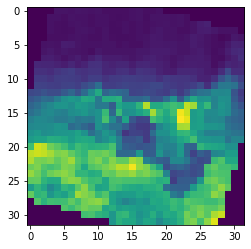

tensor([[-1.0000, -1.0000, -0.5686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5922,  ...,  0.0196, -0.2157, -0.4510],
        ...,
        [ 0.4275,  0.5137,  0.5216,  ...,  0.2314, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2471, -1.0000, -1.0000]]) tensor(4)
tensor([ 1.5435, -1.0062,  1.7041, -0.4967,  4.3049, -0.7675, -2.4969, -0.2118,
        -1.8010, -1.4459], grad_fn=<SelectBackward0>)


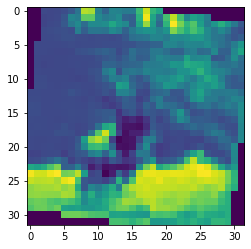

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 1.8628, -1.8764,  2.9375,  0.2730,  1.3292, -0.3924, -1.5379,  0.1833,
        -0.8993, -1.9252], grad_fn=<SelectBackward0>)


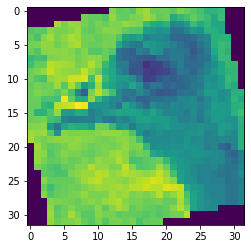

tensor([[ 0.1294,  0.1373,  0.1216,  ...,  0.1765,  0.1608,  0.1451],
        [ 0.1294,  0.1294,  0.1608,  ...,  0.2000,  0.1843,  0.1686],
        [ 0.1529,  0.1608,  0.2706,  ...,  0.2235,  0.2078,  0.2000],
        ...,
        [-0.2314, -0.2314, -0.2627,  ..., -0.1686, -0.2392, -0.2157],
        [-0.2235, -0.2078, -0.1686,  ..., -0.0745, -0.1765, -0.2078],
        [-0.2392, -0.2000, -0.2078,  ..., -0.0353, -0.0510, -0.1216]]) tensor(7)
tensor([-1.1528, -2.9805, -0.1245,  1.2886,  1.1494,  3.1428, -2.0815,  5.3909,
        -4.8716, -0.1944], grad_fn=<SelectBackward0>)


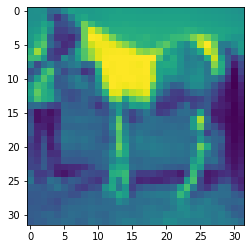

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-2.9201, -1.1325,  0.4227,  0.0090,  3.7978,  0.1869,  2.2541,  3.6024,
        -4.3988, -1.7380], grad_fn=<SelectBackward0>)


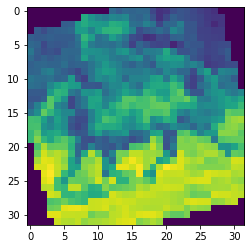

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8118,  ..., -0.6078, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0353,  ...,  0.6078, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.8641,  1.9347,  0.5546, -0.6733,  0.5155, -2.9803, -3.8172, -0.2525,
         2.3354, -1.3844], grad_fn=<SelectBackward0>)


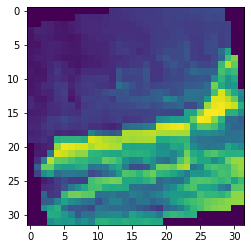

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3255, -0.3882, -1.0000],
        [-0.0039, -0.0902, -0.3569,  ..., -0.3020, -0.3333, -1.0000],
        [ 0.1608,  0.0745, -0.3020,  ..., -0.2471, -0.3255, -1.0000],
        ...,
        [-1.0000,  0.4118,  0.6000,  ...,  0.7255,  0.1451,  0.5843],
        [-1.0000, -0.1059, -0.1922,  ...,  0.3176,  0.1765,  0.7569],
        [-1.0000,  0.2314,  0.1529,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-3.0827, -4.4843,  1.5011,  0.9618,  5.8513,  1.8529,  0.6984,  8.0371,
        -7.5471, -4.9421], grad_fn=<SelectBackward0>)


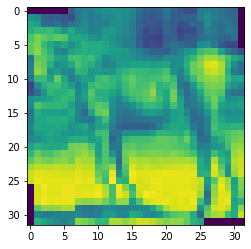

tensor([[-0.5922, -0.6078, -0.6078,  ...,  0.2000,  0.1765,  0.1686],
        [-0.5922, -0.6078, -0.6078,  ...,  0.2314,  0.1686,  0.1529],
        [-0.6000, -0.6078, -0.6078,  ...,  0.0588,  0.1529,  0.1059],
        ...,
        [ 0.8353,  0.7176,  0.6078,  ...,  0.1686, -0.0902, -0.0275],
        [ 0.6235,  0.6392,  0.6392,  ...,  0.2549,  0.2627,  0.0118],
        [ 0.6784,  0.5529,  0.5059,  ...,  0.6941,  0.6549,  0.2392]]) tensor(8)
tensor([ 3.0883, -0.4159,  0.9467, -0.1683,  0.1713, -2.3570, -2.4107, -1.8788,
         3.8236, -1.7048], grad_fn=<SelectBackward0>)


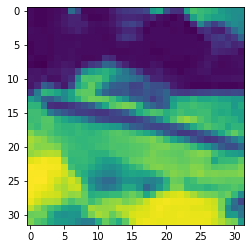

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.0482, -2.2207,  1.3988,  0.4474,  2.1901,  3.2889, -4.7900,  5.6054,
        -5.0630, -1.6313], grad_fn=<SelectBackward0>)


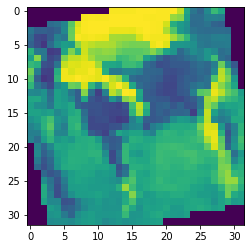

tensor([[-1.0000,  0.9843,  0.5922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.7255, -0.2549,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000,  0.3333, -0.4824,  ...,  1.0000,  1.0000,  0.9922],
        ...,
        [ 1.0000,  1.0000,  1.0000,  ...,  0.9922,  1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9922,  1.0000, -1.0000]]) tensor(1)
tensor([-1.2559,  2.3299, -2.1683,  1.4069, -0.0469,  0.5281,  0.4893, -1.0635,
        -2.7495,  2.3816], grad_fn=<SelectBackward0>)


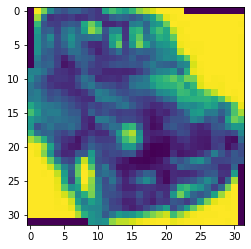

tensor([[-1.0000, -1.0000,  0.4196,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.4510,  0.2941,  ...,  0.3961,  0.1294, -1.0000],
        [-1.0000,  0.4118,  0.6157,  ...,  0.1843,  0.0275,  0.0275],
        ...,
        [ 0.6078,  0.5373,  0.5451,  ...,  0.3961,  0.4275, -1.0000],
        [-1.0000,  0.4431,  0.5373,  ...,  0.3961,  0.4588, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4275, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.3467, -1.8719,  1.6660,  1.7347, -0.0243,  0.6022, -2.9669, -0.4478,
        -0.2106, -2.2763], grad_fn=<SelectBackward0>)


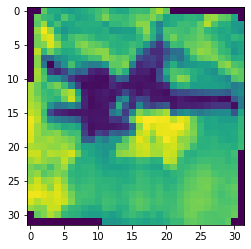

tensor([[-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ...,  0.8824,  0.9137,  0.9137],
        ...,
        [-0.0039,  0.0510,  0.0902,  ..., -0.0039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0980, -1.0000, -1.0000]]) tensor(7)
tensor([-0.1330, -2.0882, -0.4335,  0.3895,  1.9340,  1.7727, -1.6480,  4.5147,
        -3.9609, -0.4986], grad_fn=<SelectBackward0>)


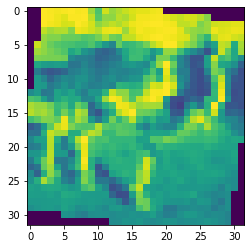

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.2752, -4.2101,  2.8054,  2.6947,  2.7932,  2.3822,  1.1011,  0.6769,
        -3.8555, -3.9474], grad_fn=<SelectBackward0>)


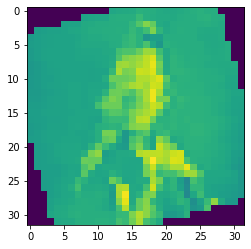

tensor([[-0.2314, -0.2392, -0.2157,  ...,  0.2392,  0.2784,  0.2863],
        [-0.3725, -0.4039, -0.3412,  ...,  0.2235,  0.2627,  0.2627],
        [-0.6235, -0.6157, -0.5529,  ...,  0.2314,  0.2627,  0.2627],
        ...,
        [-0.1216, -0.1137, -0.2235,  ..., -0.7098, -0.7725, -0.7176],
        [-0.2235, -0.3725, -0.4196,  ..., -0.7333, -0.7098, -0.7255],
        [-0.2549, -0.3961, -0.3961,  ..., -0.7098, -0.7333, -0.7725]]) tensor(5)
tensor([ 0.6859, -1.0897,  0.1371,  0.2406,  0.6886,  1.1718, -4.0552,  2.6836,
        -2.0796,  1.7836], grad_fn=<SelectBackward0>)


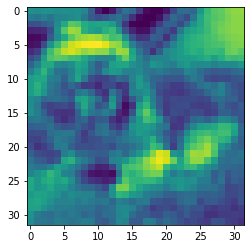

tensor([[-1.0000,  0.1294,  0.1765,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.1608,  0.2157,  ...,  0.0667,  0.0353, -0.0039],
        [-1.0000,  0.2078,  0.2627,  ...,  0.1059,  0.0745,  0.0353],
        ...,
        [-0.3882, -0.3804, -0.2627,  ..., -0.3961, -0.5373, -1.0000],
        [-0.5059, -0.4588, -0.3412,  ..., -0.4667, -0.5529, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6706, -0.7333, -1.0000]]) tensor(0)
tensor([ 5.0687, -0.7885,  1.5720, -1.5368,  0.3074, -3.2841, -3.3069, -2.7944,
         3.8742,  0.1847], grad_fn=<SelectBackward0>)


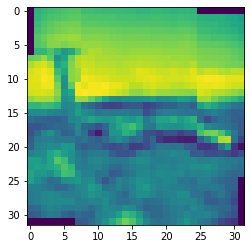

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.0812, -1.4822,  0.5883, -0.6850,  3.5432,  0.7947,  2.9297,  3.3628,
        -5.2033, -1.8881], grad_fn=<SelectBackward0>)


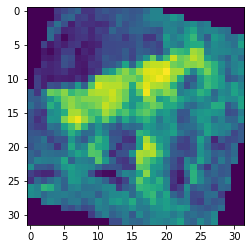

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.7569, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.7647, -1.0000, -1.0000],
        [-0.4667, -0.4588, -0.4510,  ..., -0.7804, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.7647,  ...,  0.0510,  0.0275,  0.1059],
        [-1.0000, -1.0000,  0.7569,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7647,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-1.4268, -1.5036,  0.4227,  2.6011, -0.8880,  2.7269, -0.1206,  1.0195,
        -2.7953, -0.1089], grad_fn=<SelectBackward0>)


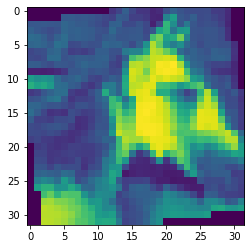

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2392, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4431, -1.0000, -1.0000],
        [-0.2314, -0.2000, -0.2314,  ..., -0.2627, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.2706,  ...,  0.3255,  0.3333,  0.3490],
        [-1.0000, -1.0000, -0.5294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5529,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-1.8972, -4.1777,  1.2090,  3.0592,  0.4817,  5.5949, -1.6105,  1.5172,
        -1.8280, -2.7882], grad_fn=<SelectBackward0>)


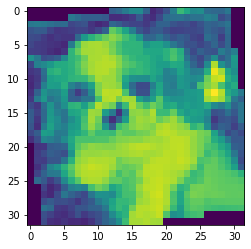

tensor([[-1.0000, -1.0000, -0.3804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3255,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2157,  ..., -0.5608, -0.6000, -0.6157],
        ...,
        [ 0.3647,  0.4275,  0.4824,  ..., -0.2784, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3255, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3412, -1.0000, -1.0000]]) tensor(5)
tensor([-1.0059, -3.8607,  3.4957,  2.3763,  1.5417,  2.8840, -1.0104,  0.9365,
        -2.1951, -3.3456], grad_fn=<SelectBackward0>)


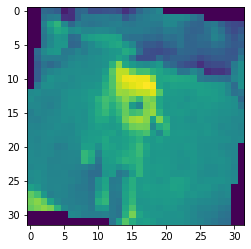

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4118, -0.5922, -1.0000],
        [-0.4902, -0.4745, -0.4745,  ..., -0.4275, -0.6392, -1.0000],
        [-0.4667, -0.4588, -0.4745,  ..., -0.5686, -0.6392, -1.0000],
        ...,
        [-1.0000,  0.1686,  0.4745,  ..., -0.3255, -0.3255, -0.3490],
        [-1.0000,  0.1686,  0.3255,  ..., -0.3569, -0.3569, -0.4039],
        [-1.0000,  0.0275,  0.2078,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.5970, -2.5194,  1.9036,  0.4387,  4.0373,  0.3178,  2.9907,  0.2438,
        -3.8171, -2.4703], grad_fn=<SelectBackward0>)


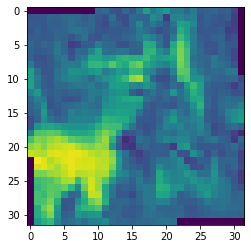

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.9843,  0.9608, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9608, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9608, -1.0000],
        ...,
        [-1.0000,  0.9765,  0.9843,  ...,  1.0000,  1.0000,  0.9922],
        [-1.0000,  0.9843,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000,  0.9843,  1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([ 0.5742, -2.9631,  0.8206,  2.1649,  0.8591,  1.4309, -0.9654, -0.0416,
        -0.5848, -1.9100], grad_fn=<SelectBackward0>)


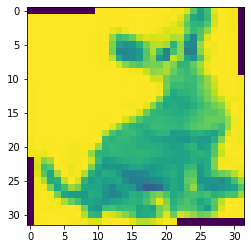

tensor([[-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.9922,  ..., -0.7020, -0.8118, -0.6627],
        ...,
        [ 0.6471,  0.6706,  0.7098,  ...,  0.5608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6549, -1.0000, -1.0000]]) tensor(6)
tensor([-1.5191, -1.0622, -0.0125,  1.5243,  3.2390,  1.6353, -0.8756,  1.8640,
        -2.4508, -2.5240], grad_fn=<SelectBackward0>)


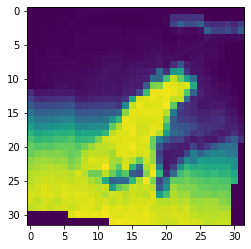

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 1.4265,  4.1381, -1.9979, -1.4426, -1.1955, -2.4338, -1.6612, -2.1151,
         0.9520,  4.0346], grad_fn=<SelectBackward0>)


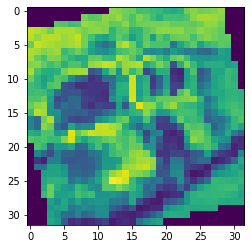

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3176, -1.0000, -1.0000],
        [-0.4196, -0.3255, -0.3725,  ..., -0.4588, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4275,  ..., -0.3725, -0.3882, -0.1843],
        [-1.0000, -1.0000,  0.4431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4353,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 0.8389, -0.4959,  0.7333,  0.2762,  0.2136,  0.5923, -1.2394,  0.5651,
        -1.1020, -0.1717], grad_fn=<SelectBackward0>)


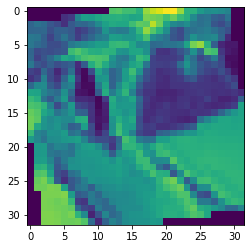

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.5135,  1.4610, -1.9302, -0.7046, -0.2073, -1.6934, -2.0781, -0.4656,
         0.8813,  5.1518], grad_fn=<SelectBackward0>)


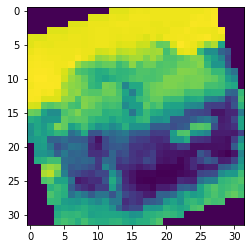

tensor([[-1.0000, -1.0000,  0.2941,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2549,  ..., -0.0196, -0.0039,  0.0667],
        ...,
        [-0.0510, -0.0118, -0.0039,  ...,  0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2706, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2549, -1.0000, -1.0000]]) tensor(2)
tensor([-0.4328, -5.0782,  4.9241,  0.9167,  4.0202,  1.3669,  1.5633,  0.2648,
        -3.9287, -4.2051], grad_fn=<SelectBackward0>)


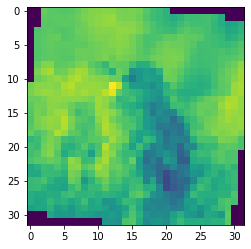

tensor([[ 0.4745,  0.4980,  0.4824,  ...,  0.3412,  0.3647,  0.3725],
        [ 0.4353,  0.4588,  0.4667,  ...,  0.3176,  0.3804,  0.4196],
        [ 0.3569,  0.4196,  0.4510,  ...,  0.4196,  0.4510,  0.4118],
        ...,
        [ 0.3490,  0.1451,  0.1216,  ...,  0.6392,  0.6000,  0.6314],
        [ 0.2392,  0.0196, -0.0196,  ...,  0.5451,  0.5294,  0.5608],
        [ 0.1529,  0.0039, -0.0118,  ...,  0.4902,  0.4196,  0.5373]]) tensor(4)
tensor([-0.8931, -4.0023,  2.0241,  2.3300,  3.7138,  1.9382,  1.7303,  0.0495,
        -3.6984, -4.1352], grad_fn=<SelectBackward0>)


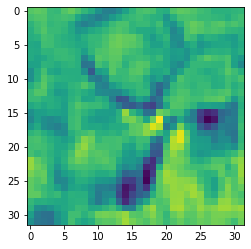

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 2.4185,  3.2406,  0.0383, -1.9532, -0.1830, -2.8408, -2.6665, -1.2856,
         0.1108,  3.3797], grad_fn=<SelectBackward0>)


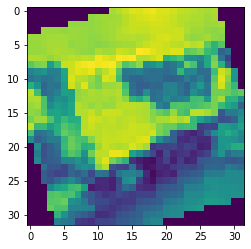

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 0.0655, -5.3221,  4.2661,  1.7925,  4.2179,  1.7087,  0.8946, -0.2983,
        -3.3323, -5.1063], grad_fn=<SelectBackward0>)


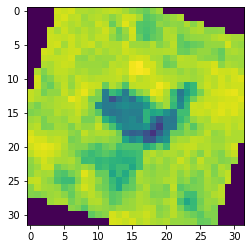

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.5897,  2.0067, -1.4580, -0.3162, -1.4398, -0.4788, -2.4899, -0.8461,
         0.7359,  3.7890], grad_fn=<SelectBackward0>)


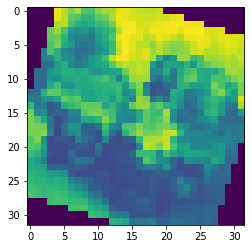

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2314, -0.7725, -1.0000],
        [-0.4431, -0.4275, -0.4667,  ..., -0.5686, -0.7804, -1.0000],
        [-0.3647, -0.3176, -0.3412,  ..., -0.7882, -0.8275, -1.0000],
        ...,
        [-1.0000, -0.8353, -0.9373,  ..., -0.7333, -0.7333, -0.8431],
        [-1.0000, -0.7882, -0.8510,  ..., -0.8196, -0.7412, -0.7961],
        [-1.0000, -0.7098, -0.5765,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.2622, -2.1981,  2.1757,  1.5757,  3.0033,  0.6969,  1.4705,  0.1872,
        -3.2299, -2.0572], grad_fn=<SelectBackward0>)


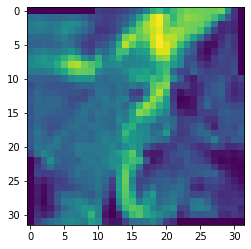

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.2940,  4.1668, -0.4093, -1.8996, -0.1297, -2.6203, -2.4899, -1.2051,
        -0.8122,  2.8398], grad_fn=<SelectBackward0>)


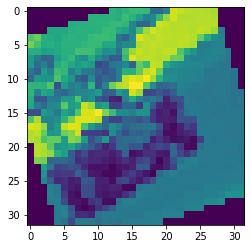

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.7671,  1.2636, -1.2057,  0.4817,  0.2968, -0.3952, -2.1012, -0.3506,
        -0.5952,  1.9908], grad_fn=<SelectBackward0>)


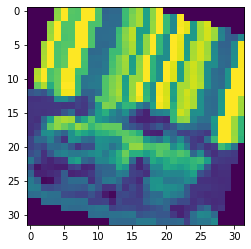

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2235, -1.0000, -1.0000],
        [ 0.3176,  0.3569,  0.3961,  ...,  0.2157, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4353,  ..., -0.1608, -0.1765, -0.1922],
        [-1.0000, -1.0000, -0.2941,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3333,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.8087,  0.6877, -0.2163, -0.8263, -0.3656, -2.3072, -1.2800, -2.4581,
         3.2847,  1.5939], grad_fn=<SelectBackward0>)


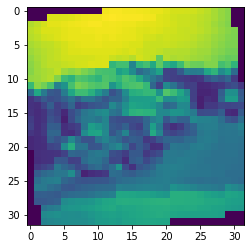

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 0.6001, -0.9078,  0.6747,  0.3168,  0.8671,  1.6978, -1.7824,  0.3634,
        -2.4360, -0.1987], grad_fn=<SelectBackward0>)


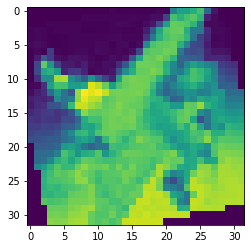

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.8871, -0.9571,  1.8970,  1.6592, -0.9621, -0.3505, -1.1755,  0.8437,
        -0.4168,  0.0781], grad_fn=<SelectBackward0>)


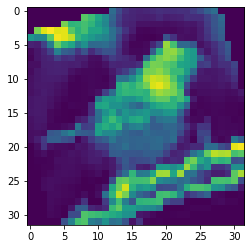

tensor([[ 0.7490,  0.3176, -0.4039,  ..., -0.2314, -0.2941,  0.0667],
        [ 0.6627,  0.8118, -0.0196,  ...,  0.2157,  0.4431,  0.2078],
        [ 0.2941,  0.6314,  0.6549,  ...,  0.6784,  0.7020,  0.3020],
        ...,
        [-0.6471, -0.2392,  0.2941,  ...,  0.8745,  0.9451,  0.9059],
        [-0.5137,  0.1059, -0.1765,  ...,  0.8980,  0.9608,  1.0000],
        [-0.2627,  0.1922, -0.3333,  ...,  0.6706,  0.7412,  0.8431]]) tensor(6)
tensor([-1.8819, -2.5691,  0.8576,  1.6861,  1.5150,  1.4798,  1.5712,  0.8381,
        -2.4718, -1.0778], grad_fn=<SelectBackward0>)


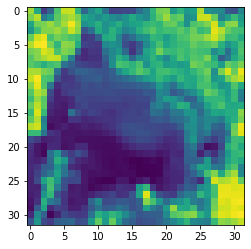

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.5219, -2.4332, -0.6711,  0.8329,  0.9373,  1.2364, -1.8314,  2.7053,
        -1.6086,  1.8828], grad_fn=<SelectBackward0>)


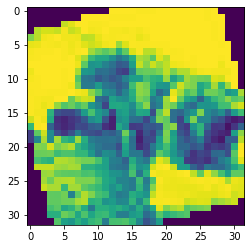

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0745, -1.0000, -1.0000],
        [-0.0902, -0.0980, -0.0980,  ..., -0.0510, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0745,  ...,  0.0275, -0.0118,  0.0353],
        [-1.0000, -1.0000,  0.0431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1216,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-1.0305, -5.5745,  5.5243,  1.7223,  4.5615,  2.0220,  1.3806,  0.0349,
        -4.5035, -5.1457], grad_fn=<SelectBackward0>)


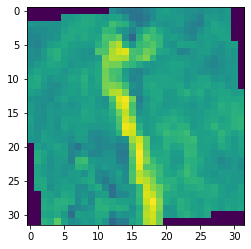

tensor([[-0.0588, -0.0353,  0.0039,  ..., -0.6314, -0.6627, -0.6078],
        [ 0.0824,  0.1451,  0.0980,  ..., -0.5451, -0.6471, -0.5451],
        [ 0.1373,  0.2235,  0.0431,  ..., -0.3176, -0.3961, -0.3255],
        ...,
        [ 0.1765,  0.1843,  0.1608,  ..., -0.8431, -0.4118, -0.0588],
        [ 0.2157,  0.2078,  0.2235,  ..., -0.5843, -0.1608, -0.1137],
        [ 0.1137,  0.0745,  0.2000,  ..., -0.2392, -0.0118, -0.1059]]) tensor(5)
tensor([-0.4755, -1.7748,  0.5407,  2.0697,  0.8863,  2.2139, -0.5012,  0.8822,
        -3.1035, -0.4963], grad_fn=<SelectBackward0>)


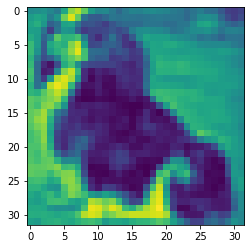

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6863,  ..., -0.2863, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.2627,  ..., -0.5294, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.6965,  0.0743,  0.0708, -0.8939,  0.5106, -1.6041, -0.9428, -1.0841,
         1.2858,  0.4094], grad_fn=<SelectBackward0>)


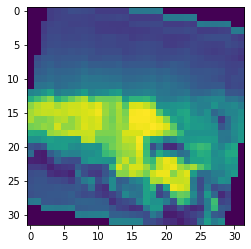

tensor([[-1.0000,  0.7333,  0.5137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.7255,  0.6784,  ...,  0.7255,  0.7255,  0.7333],
        [-1.0000,  0.7176,  0.7569,  ...,  0.7098,  0.7020,  0.7098],
        ...,
        [ 0.7098,  0.7098,  0.7098,  ...,  0.6941,  0.6863, -1.0000],
        [ 0.7098,  0.7098,  0.7098,  ...,  0.7176,  0.6941, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.7176,  0.6941, -1.0000]]) tensor(3)
tensor([ 0.3648, -2.9835,  1.0936,  1.4061,  1.9254,  0.8077,  1.0053, -0.4000,
        -1.5011, -2.3535], grad_fn=<SelectBackward0>)


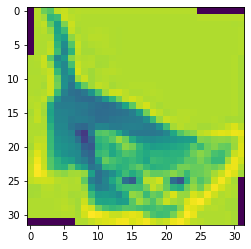

tensor([[-1.0000, -1.0000, -0.6784,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7020,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6471,  ..., -0.4902, -0.5373, -0.5451],
        ...,
        [-0.2157, -0.1686, -0.1137,  ..., -0.6706, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6392, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6784, -1.0000, -1.0000]]) tensor(4)
tensor([-1.0562, -4.5163,  2.9254,  2.1287,  2.9830,  2.3531,  0.5935,  0.8340,
        -2.9735, -3.9175], grad_fn=<SelectBackward0>)


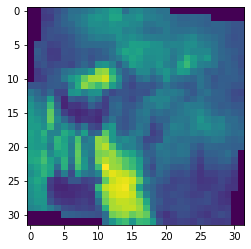

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.4088,  4.3829, -1.0362, -1.0069, -2.2096, -2.7274, -1.4513, -3.3232,
         0.8463,  3.0092], grad_fn=<SelectBackward0>)


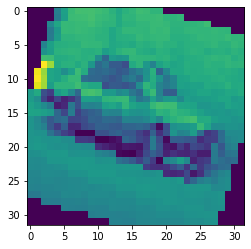

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-1.5178,  0.7709,  0.7716,  1.8623, -2.3866,  2.2288, -0.8125, -0.0320,
        -3.1941,  3.2731], grad_fn=<SelectBackward0>)


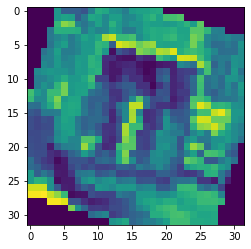

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.5778, -1.2910,  0.2015,  1.0542, -0.1767,  1.0634, -1.7525,  0.6464,
        -0.2783,  0.1442], grad_fn=<SelectBackward0>)


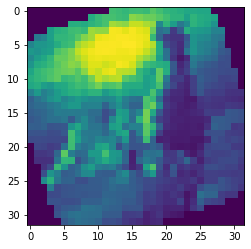

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4039,  0.4667, -1.0000],
        [ 0.0824,  0.1059,  0.1137,  ...,  0.4902,  0.5059, -1.0000],
        [ 0.1059,  0.1373,  0.1451,  ...,  0.5765,  0.5686, -1.0000],
        ...,
        [-1.0000,  0.4902,  0.4824,  ...,  0.4039,  0.3333,  0.3176],
        [-1.0000,  0.5137,  0.5059,  ...,  0.4510,  0.4039,  0.3961],
        [-1.0000,  0.5373,  0.5059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 2.3058, -8.9843,  6.5338,  3.4444,  2.8759,  4.0547, -3.1733,  1.6514,
        -3.6216, -6.5481], grad_fn=<SelectBackward0>)


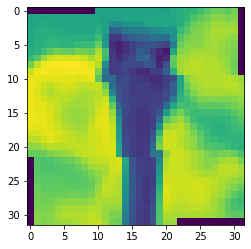

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 1.9065,  2.3444, -1.1421, -0.2276, -1.6060, -1.5461, -1.8841, -3.3940,
         3.0700,  1.9054], grad_fn=<SelectBackward0>)


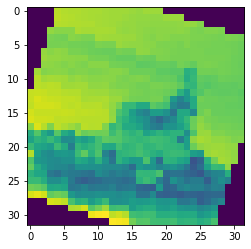

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.6839, -0.5729,  1.1647, -0.9218,  1.5038, -2.2168, -2.9833, -1.9382,
         3.6905, -1.0404], grad_fn=<SelectBackward0>)


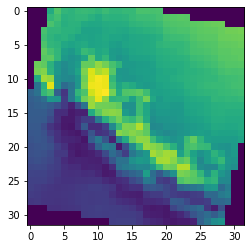

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 0.0630, -0.3495,  0.6539,  0.5129,  0.1721,  0.5476, -0.6560, -0.6715,
         0.5027, -1.0931], grad_fn=<SelectBackward0>)


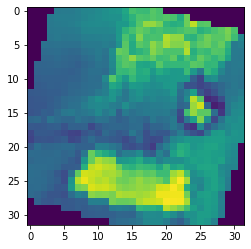

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.3716, -2.2895,  0.0680,  1.8044,  0.9478,  2.0631,  1.3899,  2.3556,
        -4.7848, -0.8525], grad_fn=<SelectBackward0>)


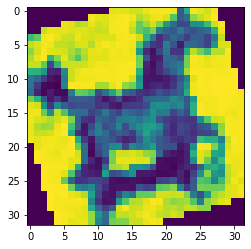

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1843,  ..., -0.2000, -1.0000, -1.0000],
        [-0.1216, -0.1686, -0.1843,  ...,  0.0588,  0.0588, -1.0000],
        ...,
        [-1.0000,  0.3020,  0.3020,  ...,  0.4824,  0.4510,  0.3961],
        [-1.0000, -1.0000, -0.2078,  ...,  0.4824, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.8902,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 2.1044,  9.4652, -2.3023, -2.9243, -3.9233, -4.6592, -1.3127, -3.7631,
         0.1458,  6.7207], grad_fn=<SelectBackward0>)


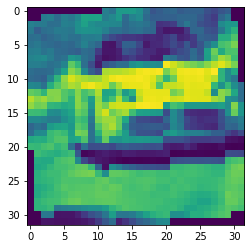

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.8459, -2.7033,  0.3683,  1.1110,  2.1975,  1.7616,  1.4228,  1.2791,
        -3.3578, -1.4136], grad_fn=<SelectBackward0>)


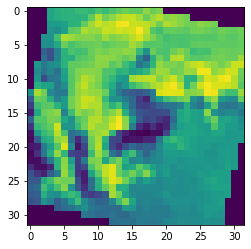

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.3849, -1.9940,  1.9400,  2.2946,  1.2195,  1.7687, -1.7750,  1.1017,
        -2.3637, -2.0493], grad_fn=<SelectBackward0>)


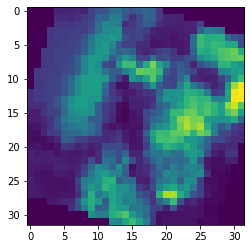

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.6527, -3.6241,  1.8408,  1.9629,  2.1211,  2.4194,  1.2942,  0.2895,
        -2.4518, -2.2508], grad_fn=<SelectBackward0>)


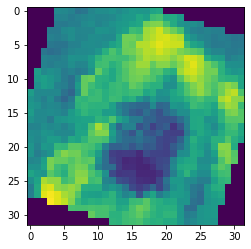

tensor([[-1.0000, -1.0000, -0.1922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.2392, -0.1765,  ...,  0.4824,  0.4745, -1.0000],
        [-1.0000, -0.2235, -0.1529,  ...,  0.3725,  0.3098,  0.3412],
        ...,
        [ 0.6235,  0.6078,  0.5059,  ..., -0.0588, -0.0588, -1.0000],
        [-1.0000,  0.6157,  0.5451,  ..., -0.0431, -0.0588, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000]]) tensor(4)
tensor([-1.2324, -3.6562,  1.8408,  2.7849,  3.2164,  1.5743,  2.1823, -0.4795,
        -3.2383, -3.2507], grad_fn=<SelectBackward0>)


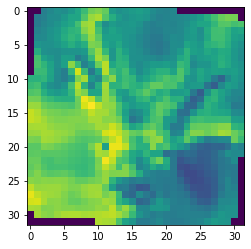

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.7973, -5.9601,  5.8099,  2.1242,  3.9239,  2.1669,  0.4658,  0.3871,
        -4.0887, -5.2189], grad_fn=<SelectBackward0>)


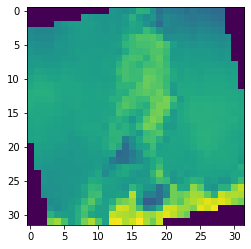

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.5952,  4.0190, -3.0025, -0.5824, -0.9984, -0.7378, -0.9152, -1.2993,
        -0.2227,  4.5477], grad_fn=<SelectBackward0>)


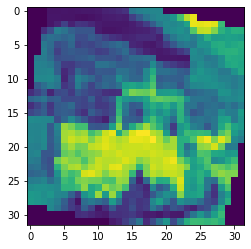

tensor([[-1.0000, -1.0000, -0.1686,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2784,  ...,  0.3647,  0.2000,  0.0824],
        ...,
        [ 0.8196,  0.8588,  0.8745,  ...,  0.7647, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.8039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.7882, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.6507, -3.6220,  2.4246,  1.6100,  3.4796,  1.0504,  0.7572, -0.1134,
        -2.8223, -4.0929], grad_fn=<SelectBackward0>)


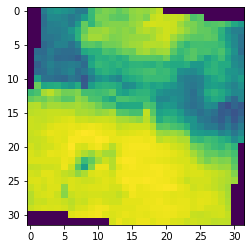

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-2.0651, -2.9648,  2.5915,  0.5763,  4.2151,  0.2066,  4.0085,  0.7686,
        -4.7302, -2.7053], grad_fn=<SelectBackward0>)


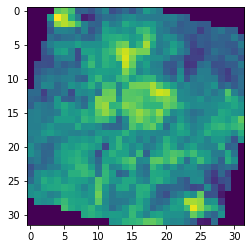

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.1529, -0.1922, -1.0000],
        [ 0.0667,  0.1608,  0.0745,  ..., -0.3098, -0.3255, -1.0000],
        [ 0.0902,  0.1843,  0.1294,  ..., -0.3725, -0.4196, -1.0000],
        ...,
        [-1.0000, -0.7176, -0.8902,  ..., -0.8275, -0.6706, -0.4824],
        [-1.0000, -0.7804, -0.8588,  ..., -0.7725, -0.7020, -0.5608],
        [-1.0000, -0.7569, -0.8118,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.5624,  1.9797, -1.5141, -0.0086, -2.7794, -0.8794, -0.6501, -1.6863,
         1.7213,  2.1731], grad_fn=<SelectBackward0>)


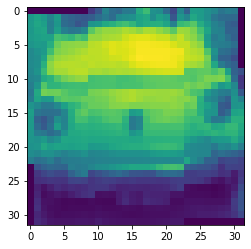

tensor([[-1.0000,  0.3804,  0.3725,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3882,  0.3725,  ...,  0.4275,  0.4118,  0.3961],
        [-1.0000,  0.3804,  0.3569,  ...,  0.3961,  0.3804,  0.3725],
        ...,
        [-0.1922, -0.2078, -0.2078,  ..., -0.3333, -0.2157, -1.0000],
        [-0.2157, -0.2235, -0.2314,  ..., -0.3255, -0.2235, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3020, -0.2235, -1.0000]]) tensor(8)
tensor([ 2.2664, -0.1928,  0.1738, -0.2630, -0.5712, -2.7441, -2.3272, -3.0768,
         5.5620,  0.5436], grad_fn=<SelectBackward0>)


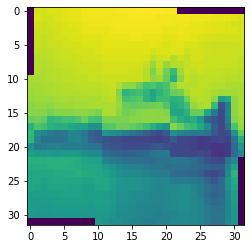

tensor([[-1.0000, -1.0000,  0.6078,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.4824,  0.5216,  ...,  0.1843,  0.1608, -1.0000],
        [-1.0000,  0.4118,  0.4353,  ...,  0.4118,  0.3725,  0.1922],
        ...,
        [ 0.1529,  0.2157,  0.1922,  ..., -0.4431, -0.3961, -1.0000],
        [-1.0000,  0.0745,  0.1216,  ..., -0.4118, -0.3961, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5373, -1.0000, -1.0000]]) tensor(2)
tensor([ 1.0409, -3.0990,  4.4193,  1.8659,  0.4191,  2.5226, -2.0927, -0.2503,
        -2.9657, -2.2797], grad_fn=<SelectBackward0>)


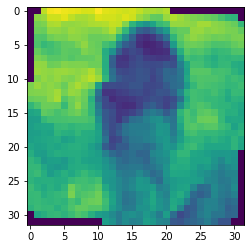

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([ 0.4342, -3.8044,  2.8029,  0.8239,  2.3069,  1.4402, -2.1707,  1.9719,
        -2.0244, -1.8053], grad_fn=<SelectBackward0>)


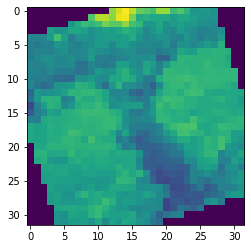

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-2.2994, -1.5450, -0.6109,  1.9484,  1.4150,  1.5167,  1.6644,  0.6981,
        -2.1719, -0.3593], grad_fn=<SelectBackward0>)


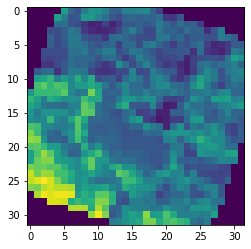

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.5459, -1.8825,  0.3755,  0.8769,  1.5396,  1.3545,  0.1537,  1.6549,
        -1.3625, -1.2931], grad_fn=<SelectBackward0>)


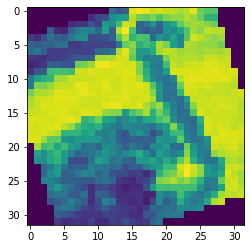

tensor([[-1.0000,  1.0000,  0.9608,  ...,  0.9608, -1.0000, -1.0000],
        [-1.0000,  1.0000,  0.9922,  ...,  0.9922,  0.9686,  0.9608],
        [ 1.0000,  0.9765,  0.9765,  ...,  0.9843,  0.9922,  1.0000],
        ...,
        [ 0.9843,  0.9294,  0.7490,  ...,  0.9765,  0.9765,  1.0000],
        [ 0.9608,  0.9608,  0.8745,  ...,  0.9765,  1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9529,  ...,  0.9765,  1.0000, -1.0000]]) tensor(1)
tensor([ 0.9685,  7.0655, -2.6059, -0.8395, -1.8603, -2.5540, -1.7931, -3.1682,
        -1.3622,  6.2284], grad_fn=<SelectBackward0>)


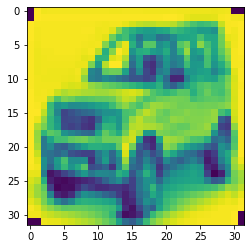

tensor([[-1.0000, -1.0000,  0.3961,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3255,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3020,  ...,  0.4039,  0.4039,  0.3882],
        ...,
        [-0.1059, -0.1137, -0.1216,  ..., -0.2000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2314, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.7839, -1.8429,  0.5840,  0.7681, -0.0975, -0.7653, -0.7084, -2.2570,
         3.6669, -0.6728], grad_fn=<SelectBackward0>)


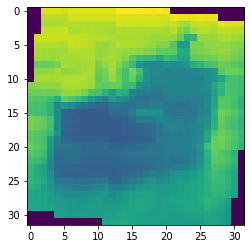

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.7390, -3.7552,  2.2890,  2.7350,  2.1612,  2.7155,  0.6957,  0.1681,
        -2.6039, -4.0165], grad_fn=<SelectBackward0>)


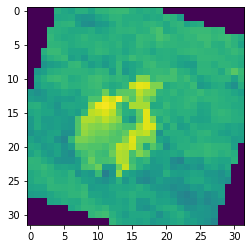

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3412, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3961, -1.0000, -1.0000],
        [-0.3961, -0.4196, -0.3569,  ..., -0.4667, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.1686,  ...,  0.2314,  0.2157,  0.2314],
        [-1.0000, -1.0000,  0.1843,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-0.2872,  5.1381, -2.1810, -2.1454, -0.5615, -1.9115, -0.5955, -0.5056,
        -1.9463,  4.5981], grad_fn=<SelectBackward0>)


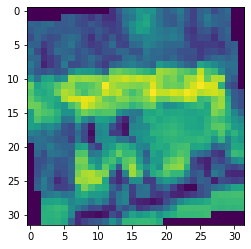

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-2.1252, -3.9760,  0.7472,  5.2689,  2.1098,  3.2535,  2.3939,  0.2124,
        -3.9687, -3.8213], grad_fn=<SelectBackward0>)


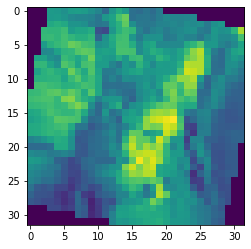

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.1997, -3.1543,  1.1840,  0.1705,  1.8694,  0.2782, -2.8021,  1.6614,
         0.4928,  0.0189], grad_fn=<SelectBackward0>)


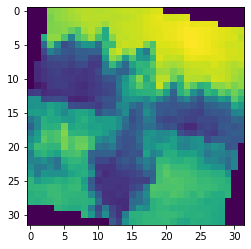

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.0055,  0.9401,  1.5757, -0.3334,  0.8681, -0.7845, -2.1499, -0.4452,
        -1.2156, -0.9896], grad_fn=<SelectBackward0>)


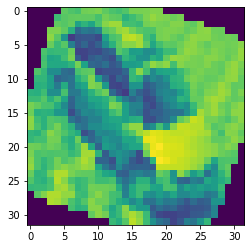

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 1.5267, -4.2338,  3.6229,  0.3653,  1.8661,  1.2049, -2.5409,  1.0866,
        -0.5904, -2.3327], grad_fn=<SelectBackward0>)


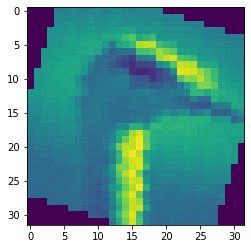

tensor([[-1.0000,  0.0353,  0.0902,  ...,  0.0980, -0.2235, -1.0000],
        [ 0.0196,  0.2314,  0.2784,  ...,  0.0039,  0.1451, -0.1765],
        [-0.0275,  0.2706,  0.2706,  ...,  0.0824,  0.1294, -0.1922],
        ...,
        [ 0.1373,  0.6784, -0.4275,  ..., -0.4824, -0.4667, -0.9922],
        [-0.6235, -0.4510, -1.0000,  ..., -1.0000, -1.0000, -0.9843],
        [-1.0000, -1.0000, -0.9843,  ..., -0.9843, -0.9843, -1.0000]]) tensor(6)
tensor([-0.0360, -3.6245,  3.1728,  2.3742,  2.0891,  0.7436,  2.3842, -2.0048,
        -2.1393, -3.9044], grad_fn=<SelectBackward0>)


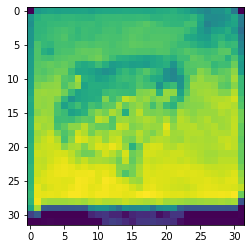

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.4180, -2.7877,  2.8867,  1.4547,  3.0574,  0.0481,  1.3174, -0.5400,
        -2.0601, -3.0109], grad_fn=<SelectBackward0>)


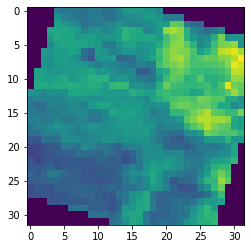

tensor([[-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9608,  ...,  0.8353,  0.7176,  0.7725],
        ...,
        [ 0.2078,  0.1608,  0.1137,  ...,  0.4431, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3961, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3961, -1.0000, -1.0000]]) tensor(8)
tensor([-0.4839, -0.4591, -0.8455,  1.3311, -0.7188,  0.5216,  0.2731, -0.2665,
        -0.1010,  0.7088], grad_fn=<SelectBackward0>)


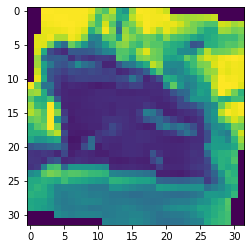

tensor([[-1.0000,  0.6706,  0.6784,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.7020,  0.6941,  ...,  0.8353,  0.8039,  0.7804],
        [-1.0000,  0.7098,  0.7020,  ...,  0.8275,  0.7882,  0.7725],
        ...,
        [-0.7725, -0.7255, -0.7333,  ..., -0.2706, -0.2235, -1.0000],
        [-0.7098, -0.6706, -0.7098,  ..., -0.2549, -0.2000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -0.2078, -1.0000]]) tensor(4)
tensor([-0.5654, -3.6620,  1.0044,  0.8973,  1.8836,  1.1120, -1.4659,  2.1895,
        -0.7634, -0.8713], grad_fn=<SelectBackward0>)


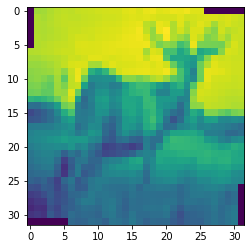

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-2.5863, -3.1464, -0.2731,  2.3044,  0.6805,  3.1636, -1.0730,  3.4325,
        -0.9714, -2.1123], grad_fn=<SelectBackward0>)


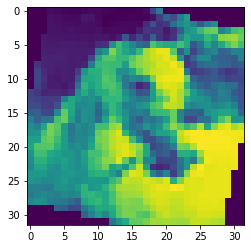

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ...,  0.9922, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9922,  ...,  1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.0938,  5.6456, -3.4671, -0.6877, -1.9701, -2.8898, -0.7883, -3.7494,
         0.1218,  7.4948], grad_fn=<SelectBackward0>)


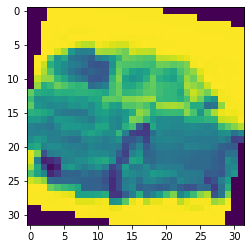

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 0.4818,  1.0672,  1.4906, -0.6883,  0.0937, -1.0863, -1.3267, -0.2536,
        -0.7061,  1.4249], grad_fn=<SelectBackward0>)


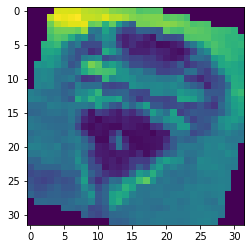

tensor([[-1.0000, -1.0000,  0.3490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2941,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2392,  ...,  0.2235,  0.1843,  0.1765],
        ...,
        [-0.0902, -0.0902, -0.0824,  ..., -0.2314, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2157, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1922, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.9759, -1.6077,  2.4425, -0.9291,  1.3488, -2.0898, -0.4328, -3.1405,
         1.8688, -2.5177], grad_fn=<SelectBackward0>)


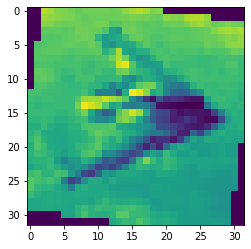

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8745,  ...,  0.5059,  0.5608, -1.0000],
        ...,
        [-1.0000, -0.6627, -0.2627,  ...,  0.8275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.7961, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([-0.5099, -0.7410,  0.3481,  0.2280,  2.1862,  0.2130, -0.7320,  3.9290,
        -4.4882,  0.0851], grad_fn=<SelectBackward0>)


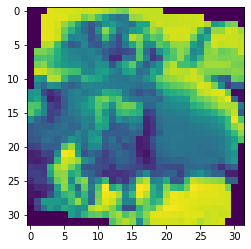

tensor([[-1.0000, -1.0000, -0.0039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1137,  ..., -0.0431,  0.2078,  0.3569],
        ...,
        [ 0.5373,  0.5137,  0.5294,  ...,  0.2235, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1686, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6784, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.2723,  1.0408,  0.1284, -1.1225,  0.3040, -2.7870, -1.8534, -2.5083,
         0.8392,  1.8577], grad_fn=<SelectBackward0>)


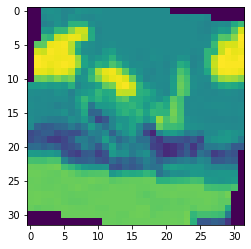

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 2.1892, -1.9455,  3.2408,  0.7757,  1.9511,  0.8921, -2.4191,  0.1941,
        -2.1867, -3.3187], grad_fn=<SelectBackward0>)


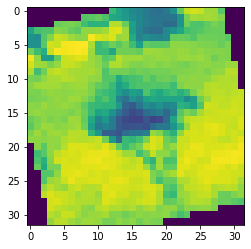

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-2.0744, -1.4180, -0.3010,  2.7319, -0.6095,  3.1537, -0.1537,  1.5418,
        -3.4660,  1.4704], grad_fn=<SelectBackward0>)


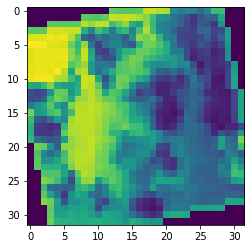

tensor([[-1.0000,  0.6863,  0.6392,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.6314,  0.6078,  ...,  0.7255,  0.7333,  0.7333],
        [-1.0000,  0.5765,  0.5686,  ...,  0.7098,  0.7333,  0.7490],
        ...,
        [ 0.1529,  0.3412,  0.3255,  ...,  0.2078,  0.3804, -1.0000],
        [ 0.0980,  0.1843,  0.2314,  ...,  0.3804,  0.3961, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3647,  0.3804, -1.0000]]) tensor(0)
tensor([ 4.1904,  0.4664,  1.7162, -1.1769,  0.6288, -2.6746, -1.5935, -2.0554,
        -0.1786, -0.0443], grad_fn=<SelectBackward0>)


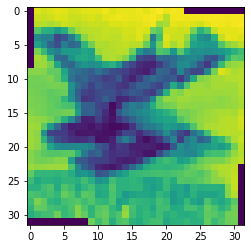

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9294, -1.0000, -1.0000],
        [-1.0000, -0.3490, -0.3176,  ..., -0.8902, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0510,  ...,  0.5765,  0.4824, -1.0000],
        [-1.0000, -1.0000,  0.1137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-0.5033, -5.3668,  1.5020,  3.5704,  2.5300,  4.8519, -1.3225,  1.9289,
        -2.6454, -5.1821], grad_fn=<SelectBackward0>)


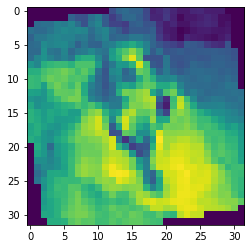

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 4.4633,  4.6036, -0.5011, -3.3675,  0.9856, -4.6613, -4.3024, -1.7801,
         0.4211,  3.6700], grad_fn=<SelectBackward0>)


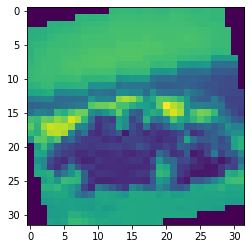

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.7387, -1.3531,  0.3803,  1.8438,  1.2834,  0.8206, -1.9396,  1.4135,
        -0.6091, -1.1244], grad_fn=<SelectBackward0>)


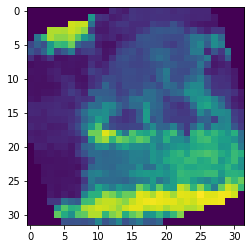

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3412, -1.0000, -1.0000],
        [-1.0000,  0.5059,  0.4667,  ...,  0.4275, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.7176,  ...,  0.2157,  0.2863, -1.0000],
        [-1.0000, -1.0000,  0.6706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.0100, -1.4176,  1.1937,  0.5576, -0.0930, -0.2283, -0.9336, -0.7097,
         1.1787,  0.1977], grad_fn=<SelectBackward0>)


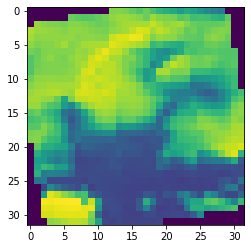

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3020, -1.0000, -1.0000],
        [-1.0000,  0.1137,  0.1059,  ..., -0.3255, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0118,  ..., -0.2000, -0.3725, -1.0000],
        [-1.0000, -1.0000, -0.3412,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-1.7125, -5.8261,  1.1484,  5.8685,  0.1780,  6.3236, -2.9287,  2.6932,
        -2.0217, -3.7874], grad_fn=<SelectBackward0>)


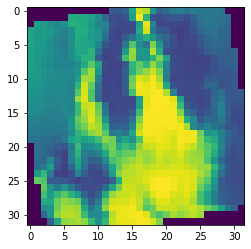

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 0.4482,  7.2538, -1.5484, -3.2928, -0.7593, -3.8641, -0.8302, -1.5075,
        -1.0313,  5.1632], grad_fn=<SelectBackward0>)


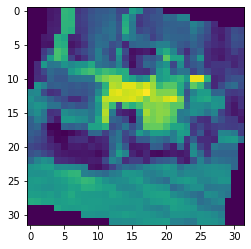

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.5765, -1.0000, -1.0000],
        [-1.0000,  0.5686,  0.5922,  ...,  0.6000,  0.5843, -1.0000],
        [ 0.5137,  0.5451,  0.5765,  ...,  0.6157,  0.5922, -1.0000],
        ...,
        [-1.0000, -0.0588, -0.0824,  ...,  0.0588,  0.0902,  0.1059],
        [-1.0000, -0.0353, -0.0745,  ...,  0.1765,  0.1765, -1.0000],
        [-1.0000, -1.0000, -0.0039,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([-0.0191, -1.4078,  0.3183,  0.8990, -0.7852, -0.5482, -0.7600, -1.6778,
         3.2562,  0.4661], grad_fn=<SelectBackward0>)


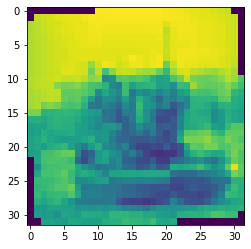

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5843, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6157, -1.0000, -1.0000],
        [-0.3490, -0.4902, -0.4353,  ..., -0.6549, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.3882,  ..., -0.3255, -0.3176, -0.3176],
        [-1.0000, -1.0000, -0.3333,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.4196,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.9984,  2.3869, -0.3464, -1.0482, -1.5498, -0.6944, -1.4043,  0.5561,
        -1.3659,  2.2276], grad_fn=<SelectBackward0>)


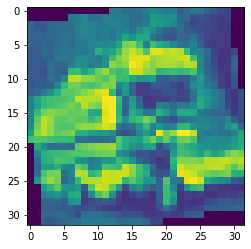

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 2.6061,  7.5745, -1.7067, -1.8646, -2.9611, -2.3348, -2.2466, -0.5593,
        -0.4620,  2.7220], grad_fn=<SelectBackward0>)


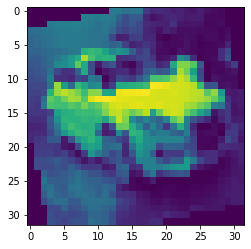

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.2926, -2.1403,  0.7897,  0.3560,  2.1951,  0.7481,  2.9236,  0.6175,
        -3.6090, -0.6995], grad_fn=<SelectBackward0>)


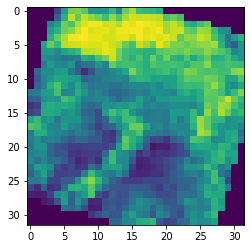

tensor([[-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.2471,  0.2000,  0.1922,  ...,  0.0353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0431, -1.0000, -1.0000]]) tensor(9)
tensor([ 1.6405,  1.6431, -1.0304, -0.4949, -1.4966, -2.1720, -2.2895, -2.1238,
         1.6471,  4.4771], grad_fn=<SelectBackward0>)


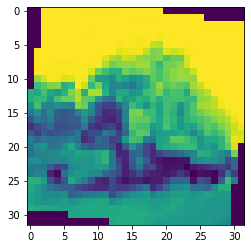

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8431,  ...,  0.9686,  0.9686, -1.0000],
        ...,
        [-1.0000,  0.0667,  0.0824,  ...,  0.0275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-0.9137, -2.8464,  0.0608,  0.1623,  3.2640,  1.7531, -2.9286,  8.4769,
        -6.5802, -0.5156], grad_fn=<SelectBackward0>)


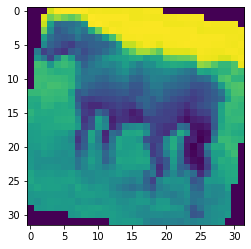

tensor([[-1.0000, -1.0000,  0.9216,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8980,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8980,  ...,  0.7961,  0.7882,  0.7725],
        ...,
        [ 0.1686,  0.1686,  0.1608,  ..., -0.1608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2314, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0588, -1.0000, -1.0000]]) tensor(1)
tensor([ 2.4288,  4.5488, -1.4690, -1.0591, -2.1836, -3.6374, -3.3414, -2.9327,
         3.5311,  3.2020], grad_fn=<SelectBackward0>)


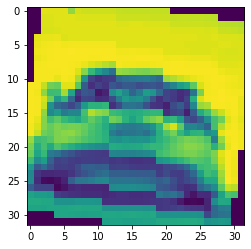

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4353, -1.0000, -1.0000],
        [-1.0000,  0.4588,  0.4667,  ...,  0.4667, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.1137,  ..., -0.3176, -0.3020, -1.0000],
        [-1.0000, -1.0000, -0.0353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.1178,  2.1936, -1.0168,  0.0876, -0.7784, -0.3197, -1.6833, -0.5824,
        -0.2817,  2.2370], grad_fn=<SelectBackward0>)


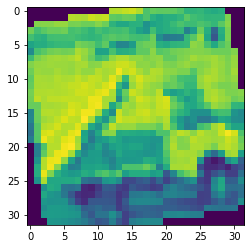

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 0.6941,  3.7874, -1.6270, -0.3643, -0.3473, -1.9258, -1.2434, -1.7523,
         0.5107,  2.0671], grad_fn=<SelectBackward0>)


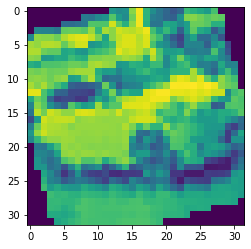

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 1.7456, -2.2162,  1.5823,  1.6339,  1.0144,  0.8707, -0.1845, -1.2831,
        -0.3864, -3.1286], grad_fn=<SelectBackward0>)


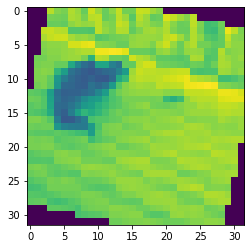

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.5796, -2.2995,  0.7194, -0.1131,  0.8486, -1.4871, -2.7244, -2.3231,
         5.1739, -1.0109], grad_fn=<SelectBackward0>)


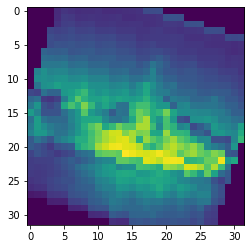

tensor([[-1.0000, -0.3412, -0.3255,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.2000, -0.2863,  ...,  0.1765,  0.1529,  0.1686],
        [-1.0000, -0.0980, -0.0824,  ...,  0.0431, -0.0196, -0.0275],
        ...,
        [-0.4118, -0.4353, -0.4353,  ..., -0.3647, -0.2706, -1.0000],
        [-0.4745, -0.4824, -0.4745,  ..., -0.3804, -0.2784, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4196, -0.3176, -1.0000]]) tensor(8)
tensor([ 1.9954,  0.7888,  0.0709, -0.9686,  0.2803, -2.0095, -0.5635, -1.8431,
         1.7209, -0.2110], grad_fn=<SelectBackward0>)


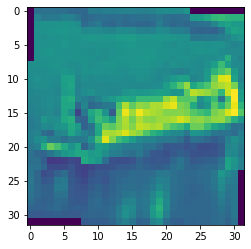

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6784, -1.0000, -1.0000],
        [-1.0000,  0.6235,  0.6392,  ...,  0.6941,  0.6863, -1.0000],
        [ 0.5843,  0.6314,  0.6471,  ...,  0.7020,  0.6863, -1.0000],
        ...,
        [-1.0000,  0.5686,  0.5843,  ...,  0.5922,  0.5843,  0.5765],
        [-1.0000,  0.5922,  0.6157,  ...,  0.6078,  0.5843, -1.0000],
        [-1.0000, -1.0000,  0.6784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 3.3720,  3.7023, -2.6519, -2.0466, -0.9176, -3.4446, -3.6360, -1.0992,
        -0.2307,  6.5518], grad_fn=<SelectBackward0>)


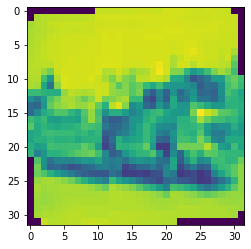

tensor([[ 0.4353, -0.0353, -0.3725,  ..., -0.2784, -0.3255, -0.3961],
        [ 0.4588, -0.0902, -0.3490,  ..., -0.3098, -0.3333, -0.3490],
        [ 0.3882, -0.1137, -0.3333,  ..., -0.3020, -0.3255, -0.3412],
        ...,
        [ 0.2392, -0.0431, -0.0824,  ..., -0.2784, -0.3333, -0.2392],
        [ 0.0824, -0.1843, -0.1451,  ..., -0.3569, -0.3804, -0.2627],
        [-0.0588, -0.3490, -0.3098,  ..., -0.3490, -0.3333, -0.3804]]) tensor(4)
tensor([-1.9689, -4.2144,  2.3885,  1.3439,  4.4869,  2.3596,  2.0565,  1.5274,
        -4.8674, -3.7959], grad_fn=<SelectBackward0>)


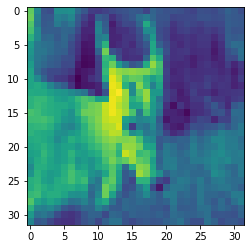

tensor([[-1.0000, -1.0000,  0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.3490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7020,  ...,  0.3882,  0.3882,  0.3333],
        ...,
        [-0.0431, -0.0431, -0.0353,  ..., -0.4667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0196, -1.0000, -1.0000]]) tensor(1)
tensor([ 0.6924,  4.6893, -1.6857, -1.2859, -0.3527, -2.0979, -2.1684, -2.5186,
         1.7906,  1.8732], grad_fn=<SelectBackward0>)


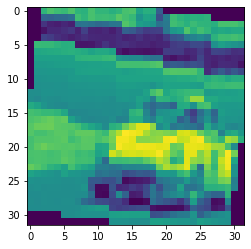

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2157,  ...,  0.2078, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0980,  ...,  0.1137, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.7730, -4.1868,  3.3114,  0.7946,  1.2139,  1.1513, -2.4864, -0.4027,
         0.2106, -2.7047], grad_fn=<SelectBackward0>)


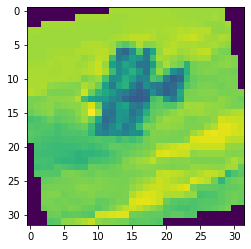

tensor([[ 0.1451,  0.1608,  0.1608,  ...,  0.3804,  0.3804,  0.3961],
        [ 0.1137,  0.1216,  0.1216,  ...,  0.3882,  0.3725,  0.3961],
        [ 0.0745,  0.0980,  0.0980,  ...,  0.3882,  0.3725,  0.4118],
        ...,
        [-0.3255, -0.3176, -0.3255,  ..., -0.0980, -0.1294, -0.1294],
        [-0.2941, -0.3098, -0.3176,  ..., -0.0275, -0.0510, -0.0431],
        [-0.2941, -0.2941, -0.3255,  ..., -0.0431, -0.0588, -0.0588]]) tensor(0)
tensor([ 4.4046, -3.7614,  2.8205,  0.1035,  1.3035, -0.5986, -0.3705, -2.4313,
         1.8308, -3.7221], grad_fn=<SelectBackward0>)


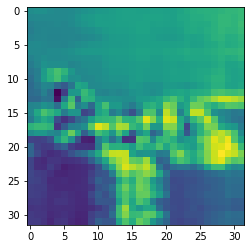

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-1.6986, -4.0738,  2.0003,  2.5925,  3.2195,  1.6818,  1.6843,  0.5479,
        -3.0417, -3.7263], grad_fn=<SelectBackward0>)


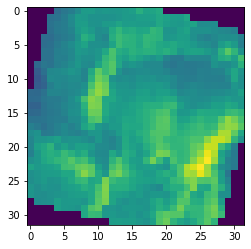

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.3490, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4510,  ...,  0.3412, -1.0000, -1.0000],
        [ 0.3333,  0.3647,  0.4745,  ...,  0.2235,  0.3020, -1.0000],
        ...,
        [-1.0000, -0.6000, -0.6078,  ...,  0.1059,  0.3098,  0.4118],
        [-1.0000, -1.0000, -0.6078,  ...,  0.1608, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6627,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-2.4796, -5.6253,  0.9367,  4.7848,  1.3654,  3.4324,  1.7930,  0.3310,
        -1.9218, -3.2905], grad_fn=<SelectBackward0>)


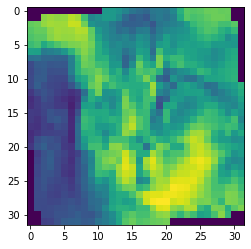

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-2.5208, -1.2854,  1.1498,  1.3831,  1.0595,  1.7852,  1.6954,  1.8649,
        -3.0468, -2.0600], grad_fn=<SelectBackward0>)


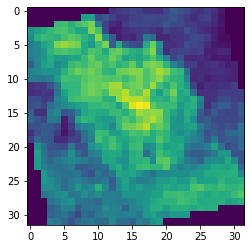

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.6706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7020,  ..., -0.6157, -0.6392, -1.0000],
        ...,
        [-1.0000, -0.2000, -0.2314,  ..., -0.4118, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3569, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-0.8512, -2.7619,  1.5938,  2.1359,  2.4690,  1.5394,  0.7980,  0.8452,
        -2.4962, -3.5044], grad_fn=<SelectBackward0>)


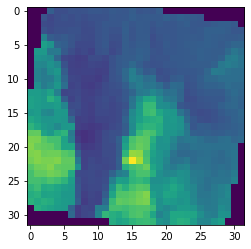

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.1354,  3.0586, -1.6669, -0.7723, -1.9287, -0.8686, -0.1048, -1.4038,
        -1.1190,  5.3413], grad_fn=<SelectBackward0>)


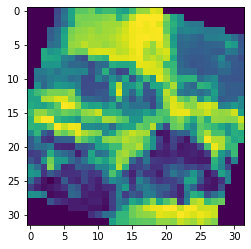

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.4942,  1.3536, -0.5125,  0.8214, -1.0346, -0.5514,  1.4069, -1.1787,
        -1.7275,  2.0296], grad_fn=<SelectBackward0>)


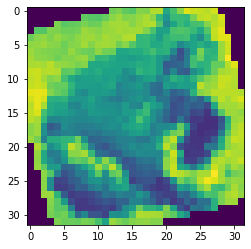

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.0798, -2.5662,  0.7352,  2.2531,  2.0242,  0.9561,  2.2275,  0.8129,
        -2.3284, -1.9164], grad_fn=<SelectBackward0>)


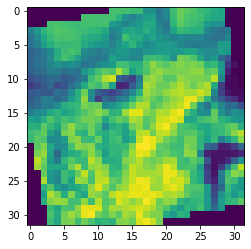

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.1294, -0.0980, -1.0000],
        [ 0.4196,  0.5765, -0.2000,  ..., -0.0980, -0.0824, -1.0000],
        [ 0.3020,  0.4588, -0.0431,  ..., -0.0824, -0.0588, -1.0000],
        ...,
        [-1.0000, -0.8353, -0.8353,  ...,  0.1686,  0.4118,  0.3725],
        [-1.0000, -0.8353, -0.8196,  ...,  0.0431,  0.1686,  0.1529],
        [-1.0000, -0.8118, -0.8118,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-2.3533, -3.2233,  0.9198,  3.5752, -0.1626,  4.2571, -0.2931,  1.3794,
        -2.9068, -1.5525], grad_fn=<SelectBackward0>)


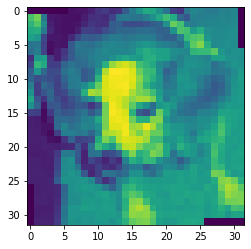

tensor([[-1.0000, -1.0000,  0.9059,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9294,  ...,  0.9765, -1.0000, -1.0000],
        [-1.0000,  0.9373,  0.9451,  ...,  1.0000,  0.9843,  0.9843],
        ...,
        [-0.1843, -0.2706, -0.1137,  ...,  0.1294,  0.1686, -1.0000],
        [-1.0000, -1.0000, -0.3255,  ...,  0.1294, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0510, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.1874, -2.5793,  0.9335,  1.2810, -1.1373,  0.3801, -0.8574, -1.0618,
         2.2098,  0.1115], grad_fn=<SelectBackward0>)


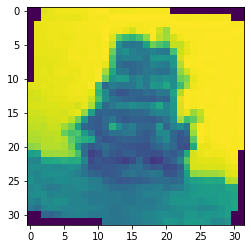

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0745,  0.0039, -1.0000],
        [-0.1686, -0.6941, -0.9843,  ...,  0.0275,  0.0667, -1.0000],
        [-0.0667, -0.2941, -0.8118,  ...,  0.0824,  0.0275, -1.0000],
        ...,
        [-1.0000,  0.1765,  0.0667,  ...,  0.2784,  0.1059, -0.0667],
        [-1.0000,  0.1137,  0.0431,  ...,  0.1216,  0.2706,  0.0667],
        [-1.0000,  0.1294,  0.1843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-1.6729, -0.8138, -0.5741,  2.4333,  0.6243,  1.8633,  0.9062, -0.5909,
        -1.7915, -0.2081], grad_fn=<SelectBackward0>)


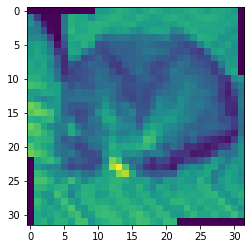

tensor([[ 0.0196,  0.7412,  0.9294,  ...,  0.9608,  0.9608,  0.9529],
        [-0.3804,  0.1529,  0.4667,  ...,  0.9373,  0.9922,  0.9765],
        [-0.5843, -0.4039, -0.2392,  ...,  0.6706,  0.8980,  0.6627],
        ...,
        [-0.0118,  0.0431,  0.1294,  ...,  0.2157,  0.1686,  0.1137],
        [-0.0039, -0.0431,  0.1686,  ...,  0.1686,  0.1137,  0.0588],
        [-0.0118, -0.0510,  0.1216,  ...,  0.0039,  0.0431,  0.0431]]) tensor(7)
tensor([-1.3747, -3.3470,  1.2026, -0.6519,  6.2135,  0.7044, -3.8601,  9.5353,
        -6.1918, -2.7292], grad_fn=<SelectBackward0>)


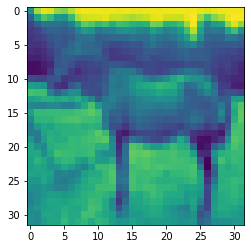

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6549,  ...,  0.6706, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.4039,  ...,  0.3412, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 5.1720,  2.1922, -0.2399, -2.2677, -1.0592, -5.2171, -3.1912, -3.9918,
         6.0776,  1.5261], grad_fn=<SelectBackward0>)


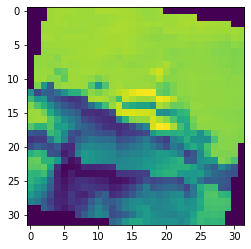

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.6252,  2.2432,  0.3383,  1.1237, -0.5122,  0.0324, -2.0566,  0.3025,
        -0.1017, -0.0373], grad_fn=<SelectBackward0>)


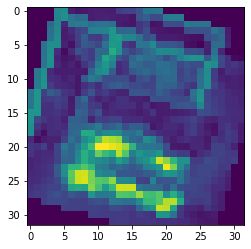

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.7413, -4.2894,  0.6542,  3.4736,  0.3767,  5.5628, -1.5280,  0.5816,
        -1.0000, -3.2144], grad_fn=<SelectBackward0>)


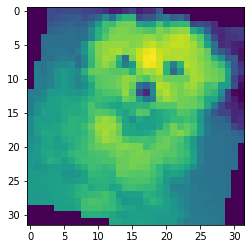

tensor([[-1.0000,  0.7255,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.7255,  0.7255,  ...,  0.7725,  0.7725,  0.7569],
        [-1.0000,  0.7333,  0.7255,  ...,  0.7569,  0.7569,  0.7490],
        ...,
        [ 0.3804,  0.3490,  0.3569,  ...,  0.2235,  0.2471, -1.0000],
        [ 0.3804,  0.3804,  0.3569,  ...,  0.3020,  0.3333, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3882,  0.4039, -1.0000]]) tensor(1)
tensor([ 0.9769,  0.4445,  0.8086,  0.2296, -0.2326, -2.0600, -0.4802, -1.7762,
         0.8856,  1.4732], grad_fn=<SelectBackward0>)


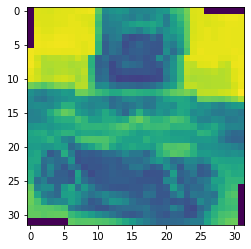

tensor([[-1.0000, -1.0000, -0.2314,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2157,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2078,  ...,  0.3176,  0.3020,  0.2941],
        ...,
        [ 0.1137,  0.1216,  0.1529,  ..., -0.3725, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0902, -1.0000, -1.0000]]) tensor(7)
tensor([-1.1486, -1.0552, -0.0725,  1.4961,  1.2897,  0.6310, -0.0471, -0.0556,
        -1.3163,  0.4403], grad_fn=<SelectBackward0>)


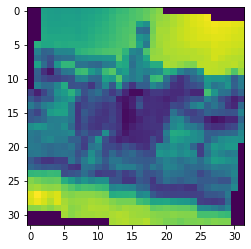

tensor([[-1.0000, -1.0000, -0.7255,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.1059,  0.0824,  ..., -0.3647, -0.2706, -1.0000],
        [-1.0000,  0.1059,  0.1294,  ..., -0.3804, -0.2471,  0.2000],
        ...,
        [-0.6706, -0.8824, -0.8196,  ..., -0.0588,  0.0824, -1.0000],
        [-1.0000, -0.5373, -0.4510,  ..., -0.0510,  0.0353, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0510, -1.0000, -1.0000]]) tensor(3)
tensor([-1.2523, -2.3802,  0.6772,  3.1327,  1.1033,  3.0695,  0.4724,  0.4905,
        -1.6724, -3.5440], grad_fn=<SelectBackward0>)


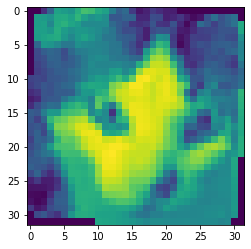

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7098,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.6706,  ...,  0.4510,  0.4667, -1.0000],
        ...,
        [-1.0000,  0.3725,  0.3804,  ...,  0.2471, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2863, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(5)
tensor([-0.7527, -3.5608,  1.1899,  2.1743,  0.1696,  2.0817,  1.7263, -0.1922,
        -1.9130, -1.2462], grad_fn=<SelectBackward0>)


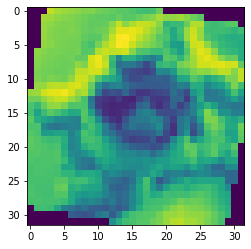

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.3476, -2.5402,  1.8460,  1.7547,  2.3781, -0.3715,  4.7370, -1.2228,
        -3.1511, -2.2965], grad_fn=<SelectBackward0>)


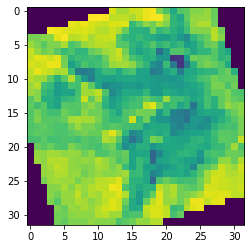

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 0.0039, -1.4369,  0.8960,  2.7152, -2.7299,  2.3767,  2.6035, -2.1250,
        -2.7953,  0.1598], grad_fn=<SelectBackward0>)


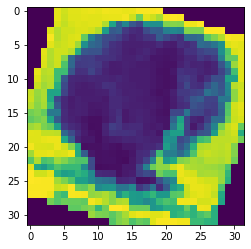

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 2.5156,  1.1119, -0.7080, -1.2769, -0.4196, -2.8660, -3.4667, -1.3270,
         3.2117,  3.1911], grad_fn=<SelectBackward0>)


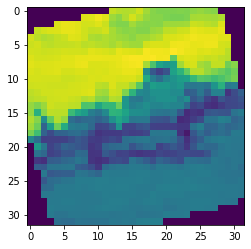

tensor([[-1.0000, -0.9294, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9529, -0.9843,  ..., -0.6078, -0.7098, -0.8118],
        [-1.0000, -0.9373, -0.9529,  ..., -0.6549, -0.7725, -0.8980],
        ...,
        [-0.9529, -0.9529, -0.9451,  ..., -0.6863, -0.7882, -1.0000],
        [-0.9451, -0.9451, -0.9216,  ..., -0.6941, -0.7569, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.6078, -0.6157, -1.0000]]) tensor(6)
tensor([-2.0449, -3.1125,  1.6431,  1.5740,  1.9591,  1.7139, -0.2438,  1.5109,
        -1.3972, -1.3427], grad_fn=<SelectBackward0>)


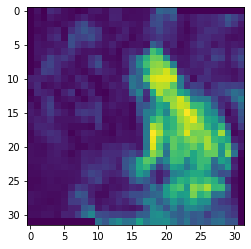

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.9638, -1.6273,  0.4402,  2.1850,  2.3717,  2.4750,  0.0695,  2.4892,
        -3.4600, -3.1191], grad_fn=<SelectBackward0>)


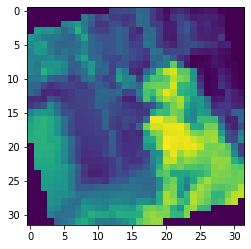

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9294, -1.0000],
        [-0.8667, -0.8588, -0.8588,  ..., -1.0000, -0.9294, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9216, -1.0000],
        ...,
        [-1.0000, -0.9216, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9216, -1.0000,  ..., -0.8275, -0.8118, -0.8118],
        [-1.0000, -0.9137, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-0.9129, -3.4335,  1.7486,  2.8779,  2.4878,  1.5919,  0.8266,  0.7584,
        -2.2966, -3.6129], grad_fn=<SelectBackward0>)


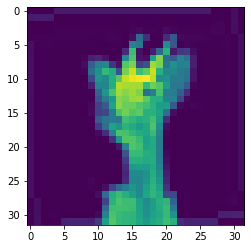

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.9373, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6941, -1.0000, -1.0000],
        [ 0.9922,  0.9843,  1.0000,  ...,  0.3804, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  1.0000,  ...,  0.2863,  0.2863,  0.2784],
        [-1.0000, -1.0000,  0.9922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.9110, -1.3804, -0.5812,  1.6520,  0.8230, -0.2710,  2.3524,  0.1860,
        -1.4966,  0.9541], grad_fn=<SelectBackward0>)


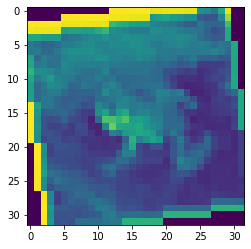

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5765,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5137,  ...,  0.1686,  0.3647, -1.0000],
        ...,
        [-1.0000, -0.8902, -0.8980,  ..., -0.8588, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8510, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 0.7827, -1.4580,  1.8888, -0.0379,  1.3805, -0.9571, -0.3510, -0.9510,
         0.5414, -1.4166], grad_fn=<SelectBackward0>)


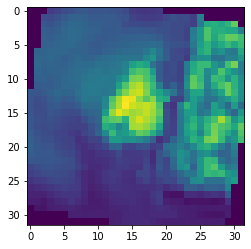

tensor([[-1.0000, -1.0000,  0.3804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3725,  0.3804,  ...,  0.3647,  0.3647, -1.0000],
        [-1.0000,  0.3647,  0.3804,  ...,  0.1529, -0.2157,  0.2627],
        ...,
        [ 0.3098,  0.4431,  0.4510,  ...,  0.5451,  0.5137, -1.0000],
        [-1.0000,  0.3647,  0.3804,  ...,  0.4902,  0.5843, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.4431, -1.0000, -1.0000]]) tensor(0)
tensor([ 4.1023,  1.0954,  0.3270, -1.4260, -0.0782, -3.7802, -2.0874, -1.2680,
         0.7453,  1.5689], grad_fn=<SelectBackward0>)


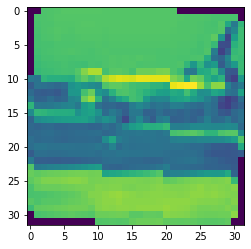

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.8039,  0.8196, -1.0000],
        [ 0.7333,  0.7333,  0.7569,  ...,  0.7647,  0.7804, -1.0000],
        [ 0.7882,  0.7882,  0.7961,  ...,  0.7412,  0.7412, -1.0000],
        ...,
        [-1.0000,  0.4745,  0.4667,  ...,  0.2235,  0.3569,  0.4039],
        [-1.0000,  0.4980,  0.4980,  ...,  0.4118,  0.4275,  0.4275],
        [-1.0000,  0.5059,  0.5137,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([-0.3729,  2.7270, -0.9243, -1.0082, -1.4297, -1.3402, -0.1485, -0.3207,
        -1.2618,  4.5192], grad_fn=<SelectBackward0>)


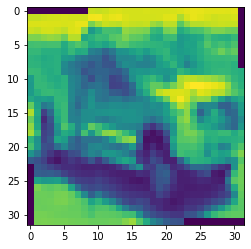

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.2341, -1.8248,  0.5103,  1.6795,  0.2497,  1.1583,  1.3334, -0.6777,
        -1.7713, -0.7014], grad_fn=<SelectBackward0>)


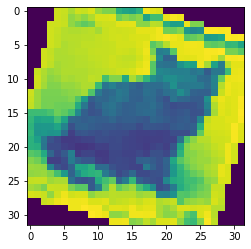

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.2230, -1.8236,  0.5305,  2.5970,  1.1328,  0.7865,  3.4094,  0.2338,
        -3.0680, -1.2703], grad_fn=<SelectBackward0>)


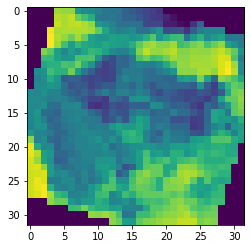

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-0.9975, -1.8835,  0.7827,  1.5117,  3.3688,  2.6812, -2.1185,  4.3450,
        -5.3393, -1.8350], grad_fn=<SelectBackward0>)


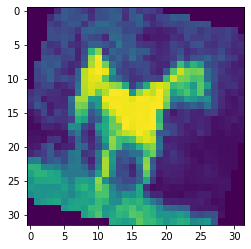

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 1.4065, -2.4744, -0.1929,  1.3826,  0.4680,  1.9341, -1.1320,  0.0090,
         0.7427, -2.2519], grad_fn=<SelectBackward0>)


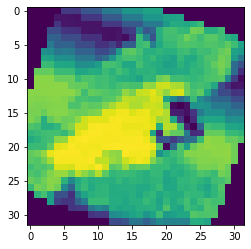

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 2.9885, -0.0454,  0.8980, -0.3660,  0.3303, -1.3520, -2.9217,  1.0872,
        -1.2684,  0.4821], grad_fn=<SelectBackward0>)


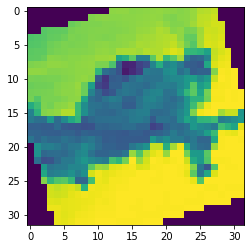

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.8667,  1.0000, -1.0000],
        [ 0.9922,  1.0000,  0.9843,  ...,  0.3020,  0.9843, -1.0000],
        [ 0.8745,  0.8431,  0.8431,  ...,  0.2863,  0.9922, -1.0000],
        ...,
        [-1.0000,  0.7961, -0.5137,  ...,  0.3333,  0.3412,  0.5843],
        [-1.0000,  0.8196, -0.4431,  ...,  0.9843,  0.9843,  0.9765],
        [-1.0000,  0.9294,  0.4431,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 1.5280,  3.1603, -1.1793, -1.3576, -1.1439, -2.6241, -1.5085, -2.5264,
         3.3780,  1.9802], grad_fn=<SelectBackward0>)


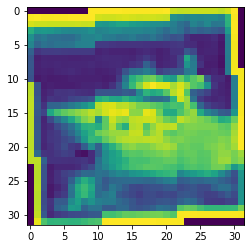

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-0.2991, -0.3304,  0.1638,  0.1303, -0.0606,  0.0942, -1.7465,  0.8184,
         0.1103,  1.7558], grad_fn=<SelectBackward0>)


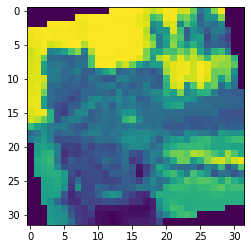

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5529, -0.4667, -1.0000],
        [-0.6000, -0.6314, -0.6549,  ..., -0.5529, -0.4431, -1.0000],
        [-0.5922, -0.6392, -0.6549,  ..., -0.5451, -0.4353, -1.0000],
        ...,
        [-1.0000,  0.6784,  0.7020,  ...,  0.7804,  0.7882,  0.7961],
        [-1.0000,  0.7255,  0.7255,  ...,  0.7490,  0.7725,  0.7804],
        [-1.0000,  0.7490,  0.7333,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 1.2316,  7.1866, -1.9591, -1.6428, -0.4344, -4.4946, -3.3003, -2.6903,
         1.9211,  3.4379], grad_fn=<SelectBackward0>)


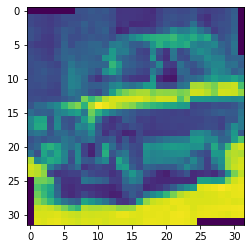

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4902, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0353,  ...,  0.3961, -1.0000, -1.0000],
        [ 0.0824, -0.7255, -0.2863,  ..., -0.0510,  0.3333, -1.0000],
        ...,
        [-1.0000, -0.4745, -0.3569,  ..., -0.4431, -0.4353, -0.5922],
        [-1.0000, -1.0000, -0.4431,  ..., -0.2471, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(7)
tensor([-0.6406, -2.4584,  1.3894,  0.8638,  2.3481,  1.9903, -4.1249,  4.9319,
        -2.8759, -1.2395], grad_fn=<SelectBackward0>)


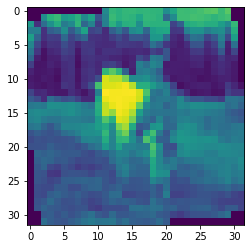

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-1.2720, -3.1474,  1.2755,  1.7501,  2.2720,  1.7382, -0.0823,  2.5980,
        -3.7669, -1.4359], grad_fn=<SelectBackward0>)


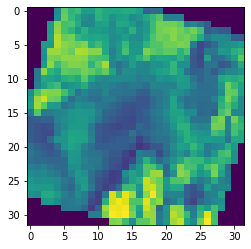

tensor([[-1.0000, -0.4275, -0.4039,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.3569, -0.3255,  ..., -0.3255, -0.3333, -0.3333],
        [-1.0000, -0.3098, -0.2627,  ..., -0.2627, -0.2784, -0.2941],
        ...,
        [-0.3490, -0.3412, -0.3333,  ..., -0.4980, -0.5686, -1.0000],
        [-0.3725, -0.3647, -0.3647,  ..., -0.4980, -0.5451, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4745, -0.4980, -1.0000]]) tensor(8)
tensor([-0.4089, -5.0995,  2.8251,  0.9274,  0.0090, -0.0195, -0.8955, -0.7679,
         3.2655,  0.1873], grad_fn=<SelectBackward0>)


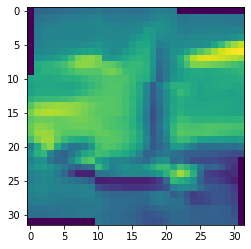

tensor([[-1.0000, -1.0000, -0.5529,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5529,  ...,  0.7333, -1.0000, -1.0000],
        [-1.0000, -0.5451, -0.4588,  ...,  0.6863,  0.7255,  0.6941],
        ...,
        [-0.6941, -0.7255, -0.7882,  ...,  0.1922, -0.1137, -1.0000],
        [-1.0000, -1.0000, -0.7490,  ..., -0.4275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5294, -1.0000, -1.0000]]) tensor(8)
tensor([ 3.3931, -1.0086,  1.5000, -0.8154,  0.5270, -1.7348, -1.5382, -2.7982,
         3.9266, -1.9374], grad_fn=<SelectBackward0>)


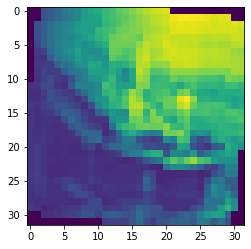

tensor([[0.0588, 0.0588, 0.0667,  ..., 0.0980, 0.0980, 0.1294],
        [0.0745, 0.0745, 0.0824,  ..., 0.1059, 0.1059, 0.1373],
        [0.0745, 0.0745, 0.0824,  ..., 0.1216, 0.1137, 0.1373],
        ...,
        [0.1294, 0.1294, 0.1294,  ..., 0.1373, 0.1373, 0.1608],
        [0.1216, 0.1294, 0.1294,  ..., 0.1373, 0.1373, 0.1608],
        [0.1137, 0.1137, 0.1137,  ..., 0.1294, 0.1294, 0.1608]]) tensor(2)
tensor([ 4.5378, -2.9514,  3.3804, -0.0328,  2.0650, -0.8204, -2.5223, -1.6421,
         0.4709, -3.4454], grad_fn=<SelectBackward0>)


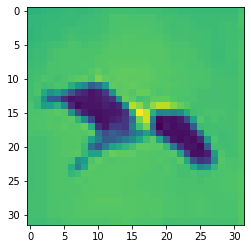

tensor([[0.9059, 0.7176, 0.7569,  ..., 0.8196, 0.8275, 0.9765],
        [0.8902, 0.4824, 0.4667,  ..., 0.8275, 0.8275, 0.9294],
        [0.8431, 0.7569, 0.7255,  ..., 0.7412, 0.7961, 0.8588],
        ...,
        [0.1529, 0.3333, 0.4353,  ..., 0.3098, 0.2471, 0.4588],
        [0.6078, 0.6471, 0.7255,  ..., 0.7098, 0.7020, 0.7804],
        [0.8902, 0.7804, 0.7725,  ..., 0.8353, 0.8667, 0.9216]]) tensor(3)
tensor([-1.5759, -3.4931,  0.0604,  2.7409,  1.5493,  2.0942,  2.0238,  0.3540,
        -2.3682, -1.8420], grad_fn=<SelectBackward0>)


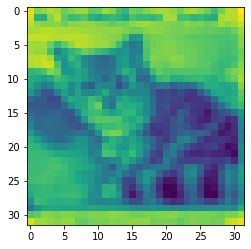

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.3469, -2.8664,  1.8248,  1.9697,  0.4427,  2.3468,  0.3560,  0.8163,
        -3.3230, -1.3438], grad_fn=<SelectBackward0>)


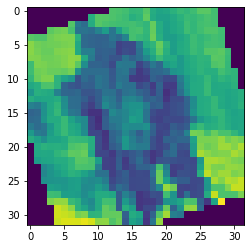

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([ 0.5499, -0.4434,  2.6574,  1.0534, -0.3721,  0.8214, -1.2835,  1.1156,
        -2.5405, -1.0666], grad_fn=<SelectBackward0>)


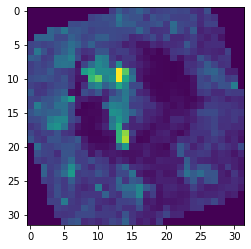

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3804, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2235,  ..., -0.3333, -1.0000, -1.0000],
        [-0.3020, -0.2471, -0.2235,  ..., -0.3490, -1.0000, -1.0000],
        ...,
        [-1.0000, -0.3333, -0.3333,  ..., -0.0667, -0.1843, -0.2157],
        [-1.0000, -1.0000, -0.3804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.4196,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.3932, -3.2798,  3.1473,  0.2281,  5.1621,  0.9063,  2.0817,  1.1752,
        -4.8516, -3.6378], grad_fn=<SelectBackward0>)


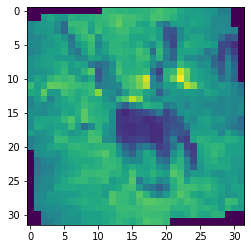

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 6.7737, -3.9623,  5.9643, -0.5117,  2.8252, -0.4608, -5.1576, -1.3667,
        -1.1082, -4.6648], grad_fn=<SelectBackward0>)


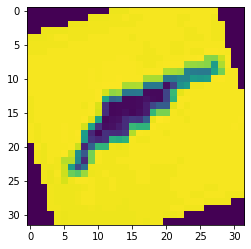

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([-2.3267, -3.6502,  3.3505,  0.5731,  3.1554,  1.7937,  2.3904,  2.9637,
        -5.2023, -3.2778], grad_fn=<SelectBackward0>)


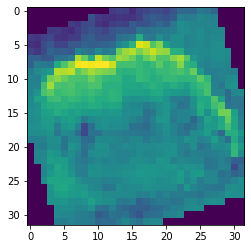

tensor([[-1.0000, -1.0000,  0.2863,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3098,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2157,  ...,  0.3176,  0.8980,  0.8510],
        ...,
        [ 0.1451,  0.0745,  0.4431,  ...,  0.0196, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0275, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0039, -1.0000, -1.0000]]) tensor(6)
tensor([-2.0052, -1.0620,  0.0736,  0.4043,  2.1480,  0.8516,  3.2567,  2.7153,
        -5.7072, -0.6124], grad_fn=<SelectBackward0>)


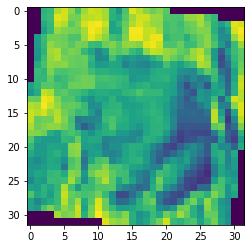

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.7412, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9137, -1.0000, -1.0000],
        [-0.6157, -0.9529, -0.8275,  ..., -0.8902, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.3490,  ...,  0.4431,  0.3961,  0.3255],
        [-1.0000, -1.0000,  0.4275,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3725,  ..., -1.0000, -1.0000, -1.0000]]) tensor(3)
tensor([-0.2727, -1.3532,  0.1317,  0.9794,  0.6859,  1.6533, -1.4050,  1.0120,
        -1.7963,  0.3630], grad_fn=<SelectBackward0>)


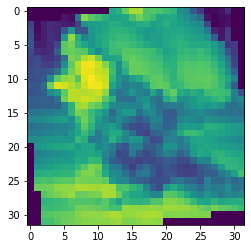

tensor([[-1.0000,  0.5059,  0.5137,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.5216,  0.5373,  ...,  0.4353,  0.6314,  0.7255],
        [-1.0000,  0.5373,  0.5451,  ...,  0.6863,  0.8196,  0.8275],
        ...,
        [-0.6784, -0.7412, -0.2863,  ..., -0.1059, -0.0824, -1.0000],
        [-0.5608, -0.5843, -0.4667,  ..., -0.1843, -0.1373, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1137, -0.0902, -1.0000]]) tensor(9)
tensor([ 0.7634,  2.8066, -0.5564, -0.9220, -1.5021, -1.8986, -2.6521, -0.5465,
         0.3021,  4.8883], grad_fn=<SelectBackward0>)


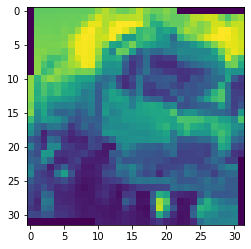

tensor([[-1.0000,  0.4118,  0.2392,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.1294,  0.1529,  ...,  0.7961,  0.7804,  0.7804],
        [-1.0000,  0.1686,  0.3882,  ...,  0.4745,  0.4275,  0.7490],
        ...,
        [-0.0353, -0.1451, -0.2549,  ...,  0.2471,  0.2627, -1.0000],
        [ 0.0431,  0.0196, -0.0039,  ...,  0.2627,  0.2941, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3098,  0.3333, -1.0000]]) tensor(1)
tensor([ 1.3452,  4.9592, -2.3806, -0.6935, -0.3595, -1.0737, -0.6584, -2.5802,
        -0.8977,  1.8880], grad_fn=<SelectBackward0>)


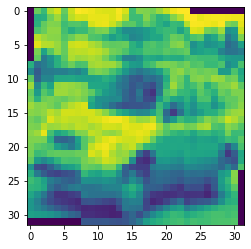

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0980, -0.0902, -1.0000],
        [ 0.5059,  0.5529,  0.6000,  ..., -0.0824, -0.0745, -1.0000],
        [ 0.4667,  0.5216,  0.6157,  ..., -0.0510, -0.0510, -1.0000],
        ...,
        [-1.0000, -0.1451, -0.0980,  ..., -0.3804, -0.3804, -0.3647],
        [-1.0000, -0.1373, -0.1137,  ..., -0.3804, -0.3647, -0.3569],
        [-1.0000, -0.1451, -0.1216,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 4.4350,  4.9657, -1.2478, -3.2600, -0.4624, -6.0860, -4.3168, -4.4090,
         5.2349,  4.0095], grad_fn=<SelectBackward0>)


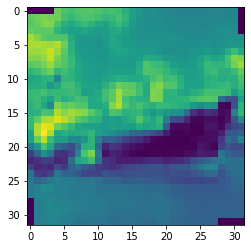

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2235, -0.1059, -1.0000],
        [ 0.1373,  0.0980, -0.1373,  ..., -0.2471, -0.1294, -1.0000],
        [ 0.0980,  0.0431,  0.0118,  ..., -0.2471, -0.1608, -1.0000],
        ...,
        [-1.0000, -0.0588, -0.1529,  ..., -0.4510, -0.4824, -0.2000],
        [-1.0000, -0.0431, -0.1608,  ..., -0.4039, -0.4118, -0.1922],
        [-1.0000, -0.0667, -0.1686,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-1.3397, -2.6296,  0.8170,  2.3838,  2.1093,  2.5064,  0.9200,  1.1516,
        -2.9825, -3.0657], grad_fn=<SelectBackward0>)


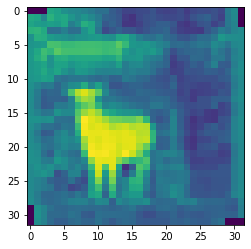

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([ 1.0039, -4.5672,  2.6492,  1.3806,  0.4061,  0.9038,  0.2093, -0.9558,
         0.7213, -2.4074], grad_fn=<SelectBackward0>)


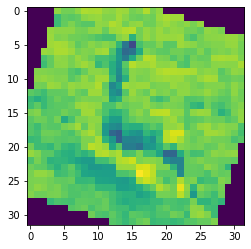

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.6698, -0.2338, -0.3417,  0.4924,  1.5353, -0.1528, -0.5661,  2.6903,
        -1.4582, -1.2491], grad_fn=<SelectBackward0>)


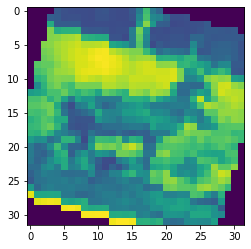

tensor([[-1.0000,  0.8510,  0.8510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.8510,  0.8431,  ...,  0.8039,  0.8039,  0.7882],
        [-1.0000,  0.8510,  0.8510,  ...,  0.8118,  0.8118,  0.8039],
        ...,
        [ 0.6549,  0.6549,  0.6549,  ...,  0.6157,  0.6235, -1.0000],
        [ 0.6235,  0.6235,  0.6235,  ...,  0.6000,  0.6078, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6000,  0.6078, -1.0000]]) tensor(0)
tensor([ 3.2303, -4.1816,  3.2910,  1.2354,  1.9035,  0.5154, -1.1250, -1.5677,
        -0.7746, -3.5181], grad_fn=<SelectBackward0>)


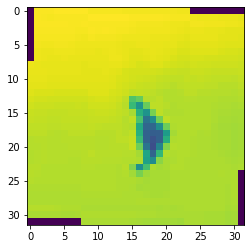

tensor([[-1.0000,  0.0431,  0.0510,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0431,  0.0510,  ...,  0.3569,  0.3804,  0.3804],
        [-1.0000, -0.2000, -0.1529,  ...,  0.3176,  0.3333,  0.3333],
        ...,
        [-0.6863, -0.7647, -0.7804,  ...,  0.7020,  0.7098, -1.0000],
        [-0.7255, -0.7725, -0.7961,  ...,  0.6627,  0.6706, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6471,  0.6863, -1.0000]]) tensor(7)
tensor([-0.2674, -3.8411,  1.2999,  1.2341,  0.7778,  1.1838, -3.0669,  2.3703,
        -0.6698,  0.7208], grad_fn=<SelectBackward0>)


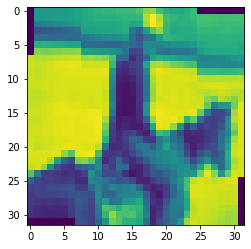

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-1.6746, -3.3904,  0.5765,  3.0640, -1.0831,  4.9058, -2.5640,  2.3093,
        -0.6210, -1.3674], grad_fn=<SelectBackward0>)


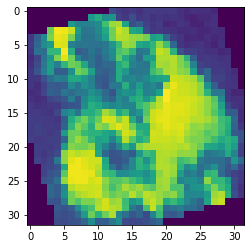

tensor([[-1.0000, -1.0000,  0.1294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1451,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.2549,  ..., -0.3020, -0.2784, -0.2235],
        ...,
        [ 0.3176,  0.3333,  0.3255,  ...,  0.1765, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2078, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2941, -1.0000, -1.0000]]) tensor(0)
tensor([ 4.7073, -0.2540,  2.8540, -1.7028,  1.6060, -2.8653, -3.9170, -1.7256,
         0.9607, -0.3317], grad_fn=<SelectBackward0>)


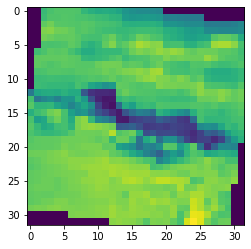

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(0)
tensor([ 4.8799, -4.1935,  3.3757,  0.5962,  2.1037, -0.0671, -1.8537, -2.2015,
         1.2632, -4.5906], grad_fn=<SelectBackward0>)


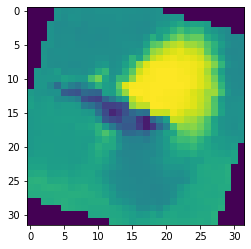

tensor([[-1.0000, -0.2784, -0.2627,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.2784, -0.2706,  ..., -0.5843, -0.5451, -0.4902],
        [-1.0000, -0.3804, -0.3804,  ..., -0.7020, -0.6706, -0.6314],
        ...,
        [ 0.2471,  0.4275,  0.6314,  ..., -0.5843, -0.5765, -1.0000],
        [ 0.2863,  0.4196,  0.5922,  ..., -0.6078, -0.6471, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4824, -0.5216, -1.0000]]) tensor(2)
tensor([-1.1446, -2.9574,  0.8233,  1.7185,  0.2598,  2.5463,  0.0330,  0.2408,
        -0.4927, -1.5094], grad_fn=<SelectBackward0>)


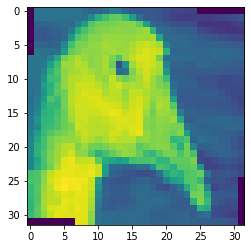

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.2078, -0.2784, -1.0000],
        [-0.1922, -0.3020, -0.3804,  ..., -0.2471, -0.2549, -1.0000],
        [-0.2235, -0.2471, -0.2314,  ..., -0.2941, -0.2784, -1.0000],
        ...,
        [-1.0000,  0.4902,  0.5529,  ..., -0.2471, -0.2784, -0.4118],
        [-1.0000,  0.4980,  0.5294,  ..., -0.2706, -0.2784, -0.3725],
        [-1.0000,  0.4118,  0.5059,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([-2.2481e+00, -4.5512e+00,  1.6895e+00,  2.0632e+00,  3.1799e+00,
         2.9190e+00, -2.0850e-04,  2.3066e+00, -3.2868e+00, -3.1408e+00],
       grad_fn=<SelectBackward0>)


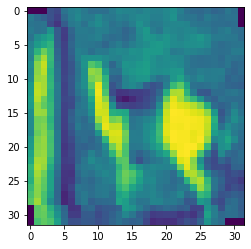

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([-1.1704,  2.2942, -0.8804, -1.0856,  0.3590, -1.7559,  1.5422, -2.6148,
        -1.1405,  4.5339], grad_fn=<SelectBackward0>)


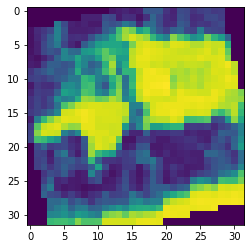

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.4353, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4039, -1.0000, -1.0000],
        [ 0.5059,  0.4118,  0.5294,  ..., -0.4588, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.2784,  ..., -0.1137, -0.0510, -0.2235],
        [-1.0000, -1.0000,  0.3098,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1608,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([-2.3382, -3.1296,  0.8963,  3.3790,  0.7953,  1.7338,  2.4042,  0.5093,
        -3.1988, -0.6251], grad_fn=<SelectBackward0>)


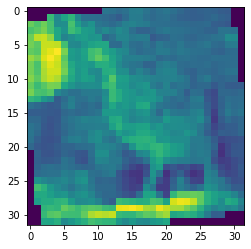

tensor([[-0.7725, -0.3961,  0.0980,  ..., -0.8824, -0.8980, -0.8824],
        [-0.7490, -0.1059,  0.0275,  ..., -0.8667, -0.8824, -0.8667],
        [-0.7725, -0.4353, -0.3725,  ..., -0.8431, -0.8196, -0.8039],
        ...,
        [ 0.1059,  0.2471,  0.2706,  ...,  0.4980,  0.4588,  0.4353],
        [ 0.1059,  0.2078,  0.2235,  ...,  0.3882,  0.3804,  0.3333],
        [ 0.1294,  0.1216,  0.1765,  ...,  0.2863,  0.2863,  0.2471]]) tensor(4)
tensor([ 0.5328, -3.4897,  1.5381,  1.6513,  3.6655,  1.7763, -1.2756,  1.2585,
        -1.6554, -4.2166], grad_fn=<SelectBackward0>)


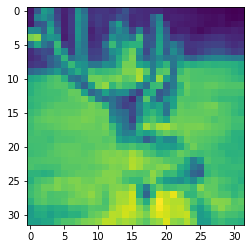

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([-0.2609, -4.8724,  1.8564,  2.0523,  1.2011,  2.5295,  0.4835,  0.0785,
        -0.6654, -3.0458], grad_fn=<SelectBackward0>)


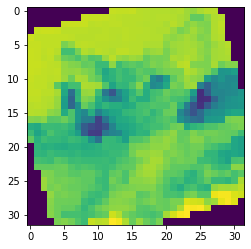

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.9698, -0.9462, -0.1436,  1.3983,  1.1159, -0.5770,  5.7001, -0.4992,
        -3.2126, -0.2345], grad_fn=<SelectBackward0>)


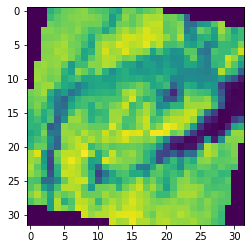

tensor([[-1.0000, -1.0000, -0.1294,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0118,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.1137,  ..., -0.2549, -0.2706, -0.2471],
        ...,
        [ 0.6784,  0.7490,  1.0000,  ...,  0.5529, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.5843, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6314, -1.0000, -1.0000]]) tensor(4)
tensor([-1.4580, -3.1329,  2.8724,  2.4935,  3.7316,  1.9922, -0.2465,  0.4493,
        -3.7138, -3.7495], grad_fn=<SelectBackward0>)


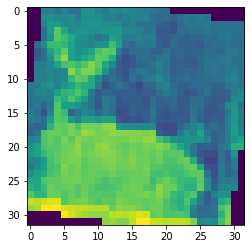

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3882,  ...,  0.2941, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.4196,  ...,  0.3020, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(2)
tensor([ 1.9745, -6.9688,  4.6116,  1.8430,  2.2630,  1.3087,  0.1695, -0.7672,
        -0.9973, -5.1088], grad_fn=<SelectBackward0>)


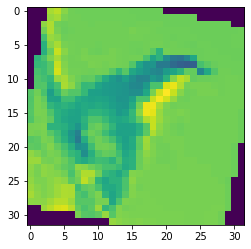

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(7)
tensor([ 0.1293, -4.0825,  2.9832,  1.2170,  3.7310,  2.9562, -3.7500,  7.3253,
        -6.4848, -4.1595], grad_fn=<SelectBackward0>)


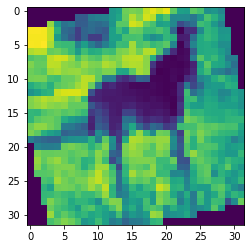

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([ 2.4694, -1.9381,  1.5373, -0.4737,  0.9077, -1.4987, -1.6349, -2.1415,
         4.3365, -1.2833], grad_fn=<SelectBackward0>)


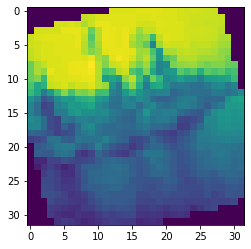

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.6959, -2.2108,  0.9811,  2.0914,  1.4816,  2.3006, -1.1973,  1.7330,
        -2.3504, -0.8046], grad_fn=<SelectBackward0>)


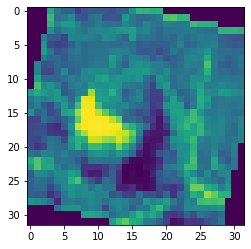

tensor([[ 0.3020,  0.3569,  0.3804,  ...,  0.2000,  0.1451,  0.1059],
        [ 0.3804,  0.4118,  0.4353,  ...,  0.2314,  0.1843,  0.1529],
        [ 0.4039,  0.4196,  0.4353,  ...,  0.2392,  0.2000,  0.1765],
        ...,
        [-0.2078, -0.1137,  0.0118,  ...,  0.4667,  0.4745,  0.5216],
        [-0.1843, -0.1294, -0.1294,  ...,  0.4902,  0.4745,  0.4902],
        [-0.2000, -0.1529, -0.1608,  ...,  0.5059,  0.4745,  0.4902]]) tensor(1)
tensor([ 1.3675,  5.0740, -3.1594, -0.4925, -0.9084, -1.2515, -0.4935, -3.5323,
        -0.1560,  3.3874], grad_fn=<SelectBackward0>)


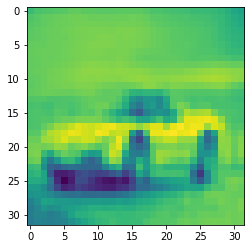

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.6627,  0.6863, -1.0000],
        [ 0.7569,  0.7333,  0.7333,  ...,  0.6000,  0.6314, -1.0000],
        [ 0.7647,  0.7490,  0.7647,  ...,  0.6078,  0.6471, -1.0000],
        ...,
        [-1.0000, -0.6471, -0.6078,  ..., -0.1843, -0.4196, -0.4588],
        [-1.0000, -0.4118, -0.3176,  ..., -0.2549, -0.4039, -0.3333],
        [-1.0000, -0.5137, -0.4353,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 2.8902, -2.0046,  2.5547, -0.2693,  1.7901, -0.9863, -4.6840,  0.4593,
         0.2106, -0.3830], grad_fn=<SelectBackward0>)


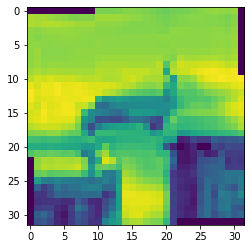

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.9992, -2.0343,  0.3203,  2.4481,  1.0364,  3.5014, -0.6044,  1.6099,
        -3.7377, -1.3695], grad_fn=<SelectBackward0>)


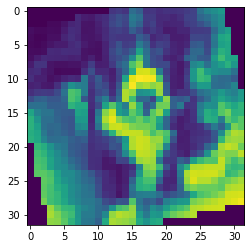

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(9)
tensor([ 2.4624,  4.2724, -0.9118, -1.5137, -0.3696, -2.8904, -2.3396, -2.6399,
         0.5853,  2.8519], grad_fn=<SelectBackward0>)


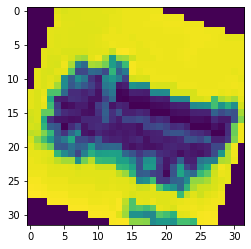

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.0980, -0.0510, -1.0000],
        [-0.0588, -0.0196, -0.0824,  ...,  0.0510,  0.0902, -1.0000],
        [-0.1608, -0.1686, -0.1529,  ..., -0.1608, -0.1216, -1.0000],
        ...,
        [-1.0000, -0.2706, -0.3020,  ..., -0.4039, -0.4196, -0.4039],
        [-1.0000, -0.2314, -0.2549,  ..., -0.2706, -0.3725, -0.3725],
        [-1.0000, -0.2078, -0.2314,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.1671,  0.4562,  0.2509,  1.1330, -0.1858, -0.1041, -1.8302, -0.6585,
         1.2767, -1.1386], grad_fn=<SelectBackward0>)


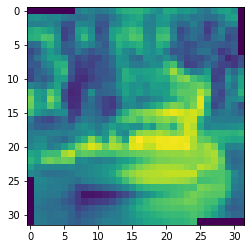

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.5216, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6000, -1.0000, -1.0000],
        [ 0.4667,  0.4980,  0.5294,  ...,  0.6627, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0039,  ..., -0.4510, -0.2471, -0.1216],
        [-1.0000, -1.0000,  0.0431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2784,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 2.4280,  2.7481, -0.2316, -2.2429,  0.2292, -3.6013, -3.0525, -1.5388,
         1.0837,  4.6105], grad_fn=<SelectBackward0>)


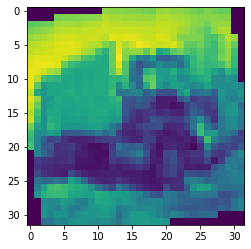

tensor([[-1.0000, -0.9373, -0.5765,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9765, -0.6706,  ..., -0.7176, -0.7020, -0.6471],
        [-1.0000, -0.9294, -0.7098,  ..., -0.9137, -0.9059, -0.8902],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9922, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-2.6422, -2.9295, -0.1039,  4.8234, -0.5694,  1.8585,  4.2581, -1.5652,
        -0.2877, -2.5402], grad_fn=<SelectBackward0>)


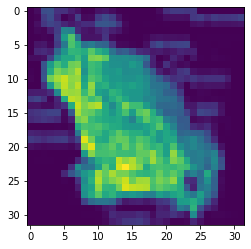

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-1.2262, -3.3095,  2.3282,  2.5987,  1.7456,  1.6484,  0.7531,  0.5814,
        -1.6778, -3.1848], grad_fn=<SelectBackward0>)


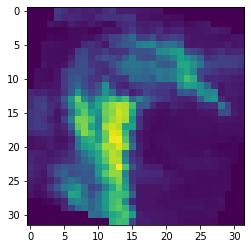

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([ 0.0126, -1.8490,  0.6679,  0.3602,  2.1503,  0.8054,  0.4277, -0.4367,
        -0.7630, -2.0496], grad_fn=<SelectBackward0>)


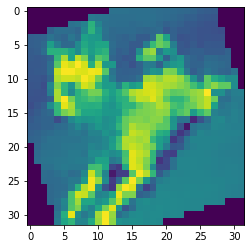

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.5294, -2.2662,  1.2793,  1.4285,  0.5967,  2.8299, -1.1985,  1.4499,
        -2.5589, -1.5019], grad_fn=<SelectBackward0>)


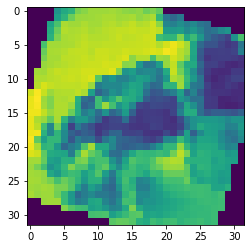

tensor([[0.8039, 0.7882, 0.8039,  ..., 0.8902, 0.8980, 0.8980],
        [0.7804, 0.7647, 0.7725,  ..., 0.8275, 0.8431, 0.8353],
        [0.7961, 0.7725, 0.7882,  ..., 0.8039, 0.8196, 0.8353],
        ...,
        [1.0000, 0.9922, 1.0000,  ..., 0.7882, 0.8039, 0.8275],
        [1.0000, 0.9922, 0.9922,  ..., 0.7882, 0.8118, 0.8353],
        [1.0000, 1.0000, 1.0000,  ..., 0.7961, 0.8196, 0.8353]]) tensor(0)
tensor([ 1.4468, -0.4440, -0.0548,  1.8359, -1.3352,  0.4568, -0.6292, -1.4266,
        -0.5346,  0.0729], grad_fn=<SelectBackward0>)


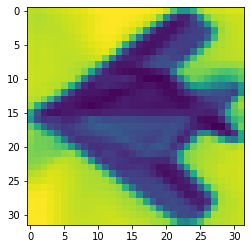

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-1.7455,  1.6779, -0.5565,  0.4342, -1.1554, -1.7932,  4.2040, -2.3975,
        -1.0434,  2.9901], grad_fn=<SelectBackward0>)


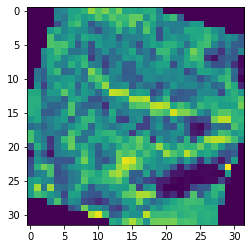

tensor([[-1.0000,  0.2941,  0.2706,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3176,  0.2941,  ...,  0.3098,  0.3647,  0.3882],
        [-1.0000,  0.3412,  0.3098,  ...,  0.3569,  0.3882,  0.4275],
        ...,
        [ 0.1608,  0.1765,  0.1686,  ...,  0.4118,  0.2235, -1.0000],
        [-0.1294, -0.1059, -0.1137,  ...,  0.3961,  0.1922, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1373,  0.0196, -1.0000]]) tensor(2)
tensor([ 2.0801, -3.9552,  4.1280,  1.5167,  1.7177,  1.6769, -0.6697, -0.9362,
        -2.9935, -4.0385], grad_fn=<SelectBackward0>)


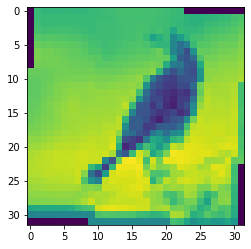

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.3020, -0.3412, -1.0000],
        [ 0.4745,  0.4667,  0.4196,  ..., -0.4431, -0.4667, -1.0000],
        [ 0.2157,  0.2000,  0.1608,  ..., -0.4902, -0.5059, -1.0000],
        ...,
        [-1.0000, -0.7569, -0.8824,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.7333, -0.8667,  ..., -0.4510, -0.4588, -0.4510],
        [-1.0000, -0.7961, -0.9137,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 0.7332, -1.5372, -0.7186,  0.9880, -0.8013,  0.1859, -2.1767,  0.2570,
         3.7073, -0.6805], grad_fn=<SelectBackward0>)


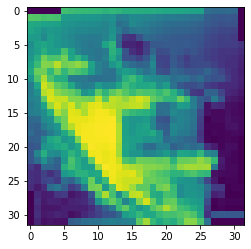

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.0348, -2.3953,  1.4452,  2.8406,  2.8110,  0.7405,  5.3539, -1.1356,
        -4.6692, -3.2201], grad_fn=<SelectBackward0>)


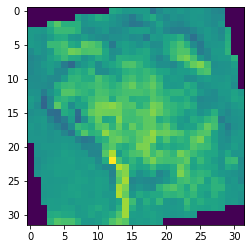

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.8745, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0196,  ...,  0.8510, -1.0000, -1.0000],
        [-0.0196, -0.0039,  0.4667,  ...,  0.8510,  0.8510, -1.0000],
        ...,
        [-1.0000, -0.1529, -0.0431,  ..., -0.0980, -0.5451, -0.5216],
        [-1.0000, -1.0000, -0.0510,  ..., -0.5529, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.0196,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 1.0311, -1.3865,  1.0138,  0.0372, -0.1487, -1.5463,  0.5807, -2.5968,
         2.8594,  0.1693], grad_fn=<SelectBackward0>)


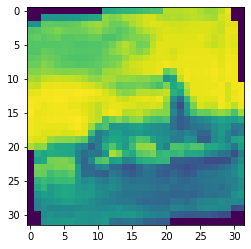

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0745, -1.0000, -1.0000],
        [-1.0000, -0.4745, -0.2706,  ..., -0.1608, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.6784,  ..., -0.9922, -0.9922, -1.0000],
        [-1.0000, -1.0000, -0.5373,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(6)
tensor([-1.7836, -2.6831, -0.0714,  3.9679, -1.5418,  1.9843,  2.0006, -1.2812,
         1.3289, -1.5312], grad_fn=<SelectBackward0>)


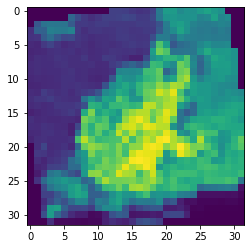

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-2.5226, -2.1089,  1.3071,  0.5286,  2.7150, -0.1179,  4.7782, -0.4044,
        -2.8903, -1.0220], grad_fn=<SelectBackward0>)


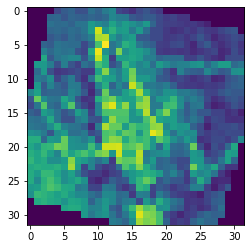

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9843, -1.0000, -1.0000],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9843, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9922,  ...,  0.9137,  0.9373, -1.0000],
        [-1.0000, -1.0000,  0.9922,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.1398,  2.6454, -0.9763,  0.4331, -1.3704, -1.3096, -1.6036, -1.1220,
         0.1180,  3.7141], grad_fn=<SelectBackward0>)


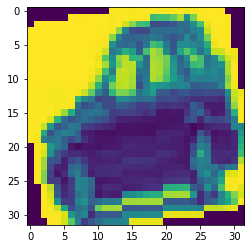

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(4)
tensor([-0.2046, -3.1821,  1.1468,  1.9308,  1.3686,  1.9872,  0.0953,  0.1681,
        -1.2037, -2.0819], grad_fn=<SelectBackward0>)


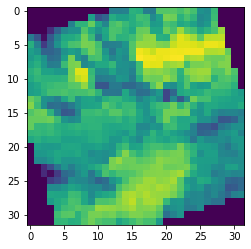

tensor([[-1.0000,  0.3882,  0.3412,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.3490,  0.2941,  ...,  0.2706,  0.3098,  0.2784],
        [-1.0000,  0.3412,  0.2863,  ...,  0.3020,  0.3098,  0.2784],
        ...,
        [ 0.6392,  0.6314,  0.6392,  ...,  0.6784,  0.6627, -1.0000],
        [ 0.6549,  0.6863,  0.6784,  ...,  0.6549,  0.6549, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.6392,  0.6235, -1.0000]]) tensor(9)
tensor([ 2.5939,  3.3399, -0.2327, -2.2359,  1.0287, -3.0084, -3.1346, -0.7791,
        -2.6932,  5.1299], grad_fn=<SelectBackward0>)


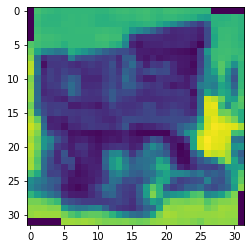

tensor([[-1.0000, -0.7961, -0.8353,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.8667, -0.8824,  ..., -0.5529, -0.5529, -0.5529],
        [-1.0000, -0.8980, -0.8980,  ..., -0.5137, -0.5216, -0.5216],
        ...,
        [-0.9529, -0.9686, -0.9765,  ..., -0.7647, -0.7333, -1.0000],
        [-0.9686, -0.9686, -0.9686,  ..., -0.8196, -0.7647, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.8353, -0.8118, -1.0000]]) tensor(8)
tensor([ 4.4153, -1.2446,  1.4662, -0.9163,  0.7265, -1.9938, -1.6712, -3.2283,
         3.9341, -2.4084], grad_fn=<SelectBackward0>)


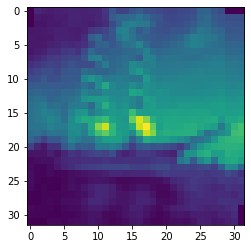

tensor([[-1.0000, -1.0000, -0.3490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.3804, -0.4431,  ..., -0.5843, -0.6078, -1.0000],
        [-1.0000, -0.3647, -0.4980,  ..., -0.6392, -0.6078, -0.6078],
        ...,
        [-0.4510, -0.4039, -0.4667,  ..., -0.2392, -0.2784, -1.0000],
        [-1.0000, -0.4745, -0.5529,  ..., -0.1529, -0.2627, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.2863, -1.0000, -1.0000]]) tensor(3)
tensor([-2.0746, -3.9717,  0.6225,  3.5988,  1.5489,  1.8939,  1.8908, -0.2417,
        -1.1633, -2.0322], grad_fn=<SelectBackward0>)


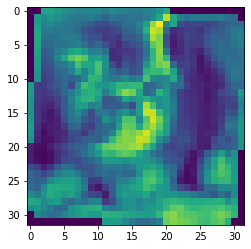

tensor([[ 0.5922,  0.6157,  0.6392,  ...,  0.5608,  0.5294,  0.4980],
        [ 0.6000,  0.6235,  0.6392,  ...,  0.5765,  0.5373,  0.5059],
        [ 0.6078,  0.6235,  0.6392,  ...,  0.5922,  0.5373,  0.5137],
        ...,
        [-0.3098, -0.3647, -0.3882,  ..., -0.5137, -0.5373, -0.4980],
        [-0.2314, -0.2471, -0.2863,  ..., -0.5373, -0.5373, -0.5137],
        [-0.2941, -0.3176, -0.3176,  ..., -0.6000, -0.5922, -0.5765]]) tensor(8)
tensor([ 4.9987, -0.0836,  0.8294, -1.2348, -0.2887, -4.3316, -4.1141, -4.6814,
         8.1745, -0.5208], grad_fn=<SelectBackward0>)


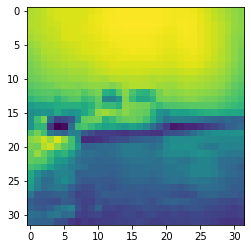

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-0.2524, -2.9306,  2.1747,  1.1013,  2.2887,  1.8203, -0.2750,  1.4640,
        -3.0365, -2.9128], grad_fn=<SelectBackward0>)


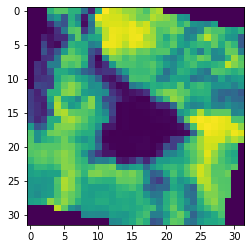

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.4755, -3.2056,  4.2818,  1.2004,  3.2987, -0.0625,  1.9337, -0.6115,
        -3.1021, -3.5397], grad_fn=<SelectBackward0>)


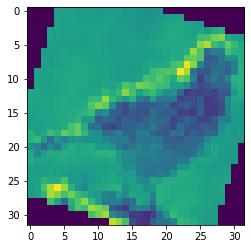

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(3)
tensor([ 0.6043, -2.1552,  1.2962,  1.5448,  0.7183,  1.4376, -2.6619,  1.7051,
        -1.5203, -1.2156], grad_fn=<SelectBackward0>)


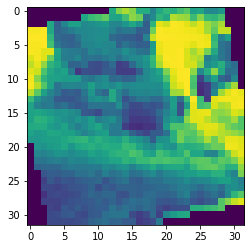

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8667,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.8588,  ...,  0.7333,  0.7333, -1.0000],
        ...,
        [-1.0000,  0.0275, -0.0196,  ..., -0.1059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.4039, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 3.9289, -0.7142,  2.0006,  0.3314,  0.6118, -0.4744, -4.3495, -0.8036,
         1.5415, -2.2357], grad_fn=<SelectBackward0>)


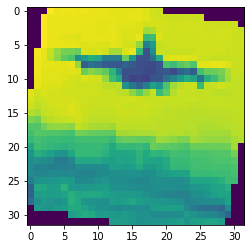

tensor([[ 0.8902,  0.9059,  0.8980,  ...,  0.7490,  0.7176,  0.7176],
        [ 0.7804,  0.7882,  0.7804,  ...,  0.4588,  0.4745,  0.5529],
        [ 0.6157,  0.6157,  0.6000,  ...,  0.1137,  0.1294,  0.3804],
        ...,
        [-0.5843, -0.5294, -0.4667,  ..., -0.8196, -0.8039, -0.8118],
        [-0.5843, -0.5608, -0.6235,  ..., -0.8353, -0.8275, -0.8353],
        [-0.5608, -0.6235, -0.7098,  ..., -0.8353, -0.8353, -0.8431]]) tensor(8)
tensor([ 2.5765,  1.2377,  0.2420, -1.1787, -0.4178, -3.5404, -1.4527, -3.9747,
         5.0814,  0.6241], grad_fn=<SelectBackward0>)


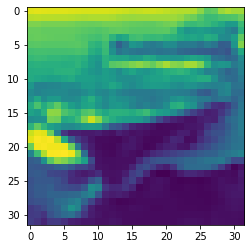

tensor([[-1.0000, -1.0000,  0.4431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.3647,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4196,  ..., -0.0824, -0.0980, -0.1059],
        ...,
        [ 0.1529,  0.1686,  0.1922,  ...,  0.1059, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0667, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.0510, -1.0000, -1.0000]]) tensor(1)
tensor([ 2.8906,  3.0105, -1.4762, -2.0646, -0.1804, -3.4854, -2.8798, -0.6889,
         0.8895,  3.7302], grad_fn=<SelectBackward0>)


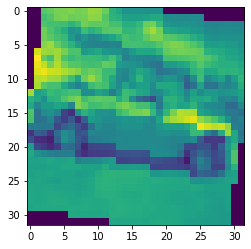

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-2.4399, -2.3903,  1.4710,  2.5440, -1.6602,  3.0471,  1.4670,  1.3173,
        -0.9783, -2.3074], grad_fn=<SelectBackward0>)


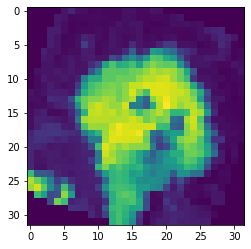

tensor([[-0.8196, -0.9059, -0.8745,  ..., -0.8431, -0.7882, -0.7725],
        [-0.8039, -0.9059, -0.8980,  ..., -0.7882, -0.7490, -0.7882],
        [-0.8510, -0.8902, -0.8902,  ..., -0.7725, -0.7176, -0.7569],
        ...,
        [-0.8745, -0.8824, -0.9137,  ..., -0.8588, -0.8431, -0.8353],
        [-0.8980, -0.9137, -0.9451,  ..., -0.8667, -0.9216, -0.8588],
        [-0.9216, -0.9373, -0.9451,  ..., -0.8667, -0.9137, -0.8980]]) tensor(2)
tensor([ 0.3050, -3.1584,  3.8393,  2.3088,  1.5922,  1.6972, -2.2874,  0.8951,
        -2.2470, -2.9605], grad_fn=<SelectBackward0>)


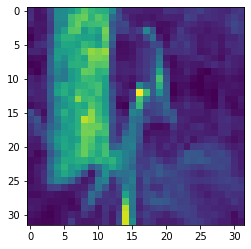

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.9922, -1.0000, -1.0000],
        [-1.0000, -0.6941, -0.7412,  ...,  0.9451, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.0353,  ..., -0.0824, -0.1216, -1.0000],
        [-1.0000, -1.0000,  0.0745,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([-0.2529,  0.9026, -0.1806, -0.0939, -1.3909,  0.0147, -2.0856,  0.5044,
        -1.3701,  4.4088], grad_fn=<SelectBackward0>)


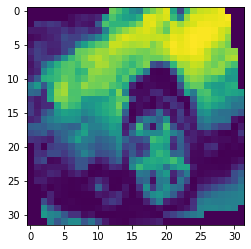

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.4431, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.4824,  ...,  0.4431, -1.0000, -1.0000],
        [ 0.4745,  0.4824,  0.4667,  ...,  0.4510,  0.4353, -1.0000],
        ...,
        [-1.0000,  0.0745, -0.0196,  ..., -0.3961, -0.4353, -0.4275],
        [-1.0000, -1.0000,  0.0902,  ..., -0.3333, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1608,  ..., -1.0000, -1.0000, -1.0000]]) tensor(9)
tensor([ 0.0376,  0.1677, -0.9904,  0.5047, -0.5399,  0.1759, -0.2198,  0.8729,
        -2.1702,  2.5312], grad_fn=<SelectBackward0>)


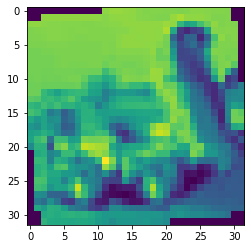

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(2)
tensor([-0.0702, -2.2636,  2.4770,  0.8917,  2.5867,  0.4053, -0.0353,  0.3149,
        -1.6303, -2.6673], grad_fn=<SelectBackward0>)


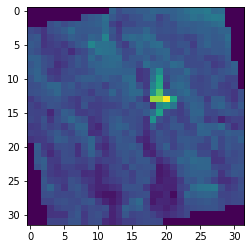

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(8)
tensor([-0.4807,  0.2355, -0.4745,  0.4390, -1.1105,  0.1260,  0.0156, -0.0147,
         0.3021,  1.0646], grad_fn=<SelectBackward0>)


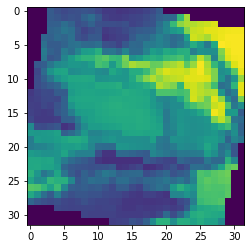

tensor([[-1.0000, -1.0000, -1.0000,  ...,  0.2000,  0.2078, -1.0000],
        [ 0.0510,  0.0667,  0.0745,  ...,  0.2000,  0.2000, -1.0000],
        [ 0.0510,  0.0510,  0.0745,  ...,  0.2157,  0.2314, -1.0000],
        ...,
        [-1.0000, -0.7804, -0.7725,  ..., -0.8118, -0.8118, -0.8353],
        [-1.0000, -0.6314, -0.6863,  ..., -0.7961, -0.8196, -0.7882],
        [-1.0000, -0.5765, -0.6235,  ..., -1.0000, -1.0000, -1.0000]]) tensor(1)
tensor([ 2.3798,  4.1194, -0.8914, -1.2935, -2.9348, -3.3312, -2.0132, -1.5444,
         2.6089,  2.0997], grad_fn=<SelectBackward0>)


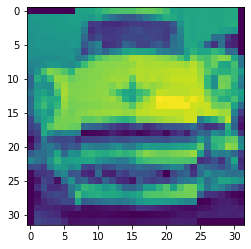

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(1)
tensor([ 1.2660,  3.5813, -2.1322, -1.4392, -0.7015, -1.2787, -2.8263, -1.1026,
         0.5915,  4.2785], grad_fn=<SelectBackward0>)


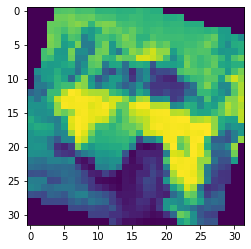

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.0745, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.1843, -1.0000, -1.0000],
        [ 0.2392,  0.2235,  0.2784,  ..., -0.3412, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.0039,  ..., -0.1294, -0.3020,  0.1294],
        [-1.0000, -1.0000,  0.0588,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.1843,  ..., -1.0000, -1.0000, -1.0000]]) tensor(4)
tensor([ 0.1983, -2.6265, -0.0139,  2.5360,  1.1186,  2.8084, -0.9297,  1.9230,
        -2.9271, -1.6642], grad_fn=<SelectBackward0>)


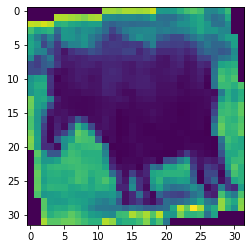

tensor([[-1.0000, -1.0000, -0.7333,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.2235,  ..., -0.1765, -1.0000, -1.0000],
        [-1.0000,  0.6706,  0.8039,  ...,  0.7412, -0.6314, -0.7490],
        ...,
        [ 0.3255,  0.3176,  0.2235,  ...,  0.4902,  0.4667, -1.0000],
        [-1.0000, -1.0000,  0.2549,  ...,  0.3569, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.3020, -1.0000, -1.0000]]) tensor(5)
tensor([ 0.2137, -0.7635, -0.7370, -0.0088,  0.4171, -0.0793, -1.8148,  1.7079,
        -1.4484,  2.7800], grad_fn=<SelectBackward0>)


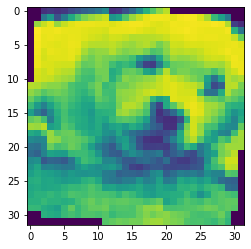

tensor([[-1.0000, -1.0000,  0.7490,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.7569,  ...,  0.7882, -1.0000, -1.0000],
        [-1.0000,  0.7725,  0.7804,  ...,  0.7961,  0.7961,  0.7961],
        ...,
        [-0.0118, -0.0588, -0.1843,  ..., -0.2941, -0.2706, -1.0000],
        [-1.0000, -1.0000, -0.0824,  ..., -0.3961, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.3176, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.5498,  0.0563, -0.4042, -0.4999, -0.3926, -1.5521, -1.9060, -0.5943,
         1.1300,  2.1834], grad_fn=<SelectBackward0>)


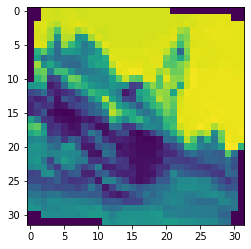

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5294, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.5137, -1.0000, -1.0000],
        [-0.9608, -0.9059, -0.8824,  ..., -0.4824, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -0.7961,  ..., -0.7961, -0.7961, -0.7569],
        [-1.0000, -1.0000, -0.7804,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.7725,  ..., -1.0000, -1.0000, -1.0000]]) tensor(0)
tensor([ 1.1324, -3.8485,  1.5240,  1.8732,  1.0314,  2.3743, -0.6656,  0.2735,
        -0.9781, -2.8555], grad_fn=<SelectBackward0>)


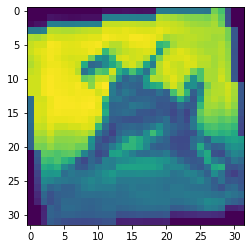

tensor([[-1.0000,  0.0431,  0.0431,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.0745,  0.0667,  ...,  0.2314,  0.2314,  0.2314],
        [-1.0000,  0.0902,  0.0902,  ...,  0.2314,  0.2314,  0.2392],
        ...,
        [-0.3098, -0.3725, -0.3255,  ..., -0.4902, -0.4510, -1.0000],
        [-0.3020, -0.4275, -0.4196,  ..., -0.1922, -0.1922, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -0.0588, -0.0902, -1.0000]]) tensor(0)
tensor([ 6.4650, -0.3416,  2.5208, -2.4439,  1.5621, -4.0433, -4.3083, -2.4341,
         2.7097, -0.7681], grad_fn=<SelectBackward0>)


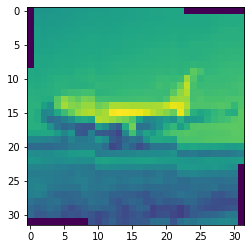

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(6)
tensor([-0.9827, -2.2628,  0.6072,  0.3652,  3.3173,  0.8929,  4.0737,  0.2319,
        -5.3424, -1.4890], grad_fn=<SelectBackward0>)


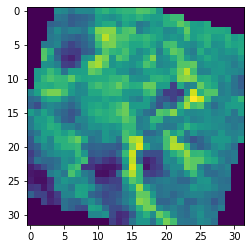

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.8431, -0.8431, -1.0000],
        [-0.8353, -0.8353, -0.8275,  ..., -0.8510, -0.8510, -1.0000],
        [-0.8353, -0.8353, -0.8353,  ..., -0.8431, -0.8431, -1.0000],
        ...,
        [-1.0000, -0.8667, -0.8510,  ..., -0.8353, -0.8353, -0.8353],
        [-1.0000, -0.8353, -0.8431,  ..., -0.8353, -0.8353, -0.8353],
        [-1.0000, -0.8431, -0.8510,  ..., -1.0000, -1.0000, -1.0000]]) tensor(8)
tensor([ 3.6002,  3.2289, -0.5685, -1.0203, -0.9715, -3.8183, -4.4113, -1.6828,
         4.8577, -0.0294], grad_fn=<SelectBackward0>)


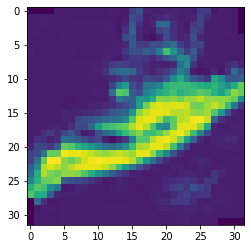

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]]) tensor(5)
tensor([-2.7251, -4.8077,  0.8792,  1.6520,  2.4357,  3.5750,  0.5712,  3.2601,
        -3.4571, -1.9402], grad_fn=<SelectBackward0>)


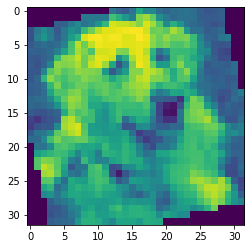

tensor([[-1.0000, -1.0000, -0.6000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5608,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -0.5608,  ..., -0.3333, -0.3333, -0.2157],
        ...,
        [-0.3804, -0.6471, -0.6471,  ...,  0.2078, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.2078, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ...,  0.1451, -1.0000, -1.0000]]) tensor(3)
tensor([-0.5010, -2.1655,  1.3542,  2.7196,  0.0184,  3.7740, -1.9266,  1.2339,
        -2.5557, -2.0930], grad_fn=<SelectBackward0>)


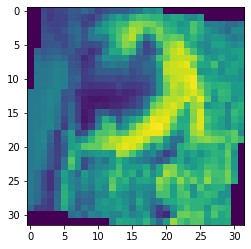

tensor([[-0.7490, -0.6549, -0.5137,  ..., -0.7020, -0.7255, -0.7098],
        [-0.7882, -0.5922, -0.5373,  ..., -0.7098, -0.6863, -0.6706],
        [-0.5686, -0.5137, -0.5373,  ..., -0.7020, -0.7725, -0.6549],
        ...,
        [ 0.4353,  0.4667,  0.4510,  ...,  0.2471,  0.2549,  0.4118],
        [ 0.4353,  0.4510,  0.4353,  ...,  0.5137,  0.5137,  0.4745],
        [ 0.3412,  0.3490,  0.3569,  ...,  0.4039,  0.4118,  0.3961]]) tensor(7)
tensor([-1.8260, -3.6806,  1.2853,  1.8891,  3.0677,  2.2974,  0.0910,  2.6747,
        -3.3504, -3.1976], grad_fn=<SelectBackward0>)


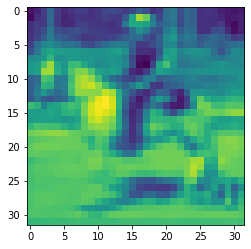

In [43]:
import matplotlib.pyplot as plt
for data_test, target_test in test_loader:
    print(data_test[0][0], target_test[0])
    predict = model(data_test)
    print(predict[0])
    plt.imshow(data_test[0][0])
    plt.show()